# Mitigating Skin Tone Bias in Skin Cancer Detection: A Low Rank Adaptation Approach
Skin cancer remains a major public health concern, with melanoma posing a particularly high risk when diagnosis is delayed. While lighter skin tones experience higher overall incidence, individuals with darker skin often face poorer outcomes due to underrepresentation in datasets and delayed detection. These challenges motivate the need for fairness-aware diagnostic systems. 

In this notebook, we explore the use of Low-Rank Adaptation (LoRA) as a parameter-efficient fine-tuning strategy for Vision Transformer–based skin cancer detection models. Using the DDI dataset, we analyse how LoRA influences overall performance, skin tone–stratified fairness metrics, and computational efficiency across different model sizes and adapter ranks. Although the dataset spanned the entire DDI groups from FST I - VI, our focus groups were thhe lighter (FSTI-II) and darker(V-VI) skin tone subgroups.

Through quantitative evaluation and qualitative explainability analysis, we aim to understand whether LoRA can reduce skin tone–related performance disparities while maintaining strong diagnostic performance.

In [ ]:

from pathlib import Path
import os, time, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from transformers import AutoModelForImageClassification, AutoImageProcessor

import torch.nn.functional as F
from PIL import Image
import cv2

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from tqdm.auto import tqdm # Using tqdm for progress bars

from peft import LoraConfig, get_peft_model, PeftModel
import time, math
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import AutoImageProcessor, AutoModelForImageClassification, get_cosine_schedule_with_warmup
# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#define Base Directory
BASE_DIR = Path().resolve().parent

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

Define Path for Metadata and base image directory

In [ ]:

#Define path for metadata
ddi_path = BASE_DIR / "data/ddi/ddidiversedermatologyimages/ddi_metadata.csv"
# Define the image directory for DDI
ddi_image_base_dir = BASE_DIR /'data/ddi/ddidiversedermatologyimages'


##  EXPLORATORY DATA ANALYSIS

In [912]:
ddi_df = pd.read_csv(ddi_path)
ddi_df.head()

Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
0           0       1  000001.png         56       True   
1           1       2  000002.png         56       True   
2           2       3  000003.png         56       True   
3           3       4  000004.png         56       True   
4           4       5  000005.png         12       True   

                           disease  
0                 melanoma-in-situ  
1                 melanoma-in-situ  
2                mycosis-fungoides  
3  squamous-cell-carcinoma-in-situ  
4             basal-cell-carcinoma

In [ ]:
def print_basic_info(df):
  print("======shape ====== \n", df.shape)
  print("\n======data types ====== \n" , df.dtypes)
  print("\n======number of unique values ====== \n" , df.nunique())

print_basic_info(ddi_df)

======shape ====== 
 (656, 6)

======data types ====== 
 Unnamed: 0     int64
DDI_ID         int64
DDI_file      object
skin_tone      int64
malignant       bool
disease       object
dtype: object

======number of unique values ====== 
 Unnamed: 0    656
DDI_ID        656
DDI_file      656
skin_tone       3
malignant       2
disease        78
dtype: int64


In [12]:
ddi_df["skin_tone"].unique()

array([56, 12, 34])

In [853]:
ddi_df["disease"].unique()

array(['melanoma-in-situ', 'mycosis-fungoides', 'squamous-cell-carcinoma-in-situ', 'basal-cell-carcinoma', 'squamous-cell-carcinoma', 'melanoma-acral-lentiginous', 'basal-cell-carcinoma-superficial', 'squamous-cell-carcinoma-keratoacanthoma', 'subcutaneous-t-cell-lymphoma', 'melanocytic-nevi',
       'seborrheic-keratosis-irritated', 'focal-acral-hyperkeratosis', 'hyperpigmentation', 'lipoma', 'foreign-body-granuloma', 'blue-nevus', 'verruca-vulgaris', 'acrochordon', 'wart', 'abrasions-ulcerations-and-physical-injuries', 'basal-cell-carcinoma-nodular', 'epidermal-cyst', 'acquired-digital-fibrokeratoma',
       'epidermal-nevus', 'seborrheic-keratosis', 'trichilemmoma', 'pyogenic-granuloma', 'neurofibroma', 'syringocystadenoma-papilliferum', 'nevus-lipomatosus-superficialis', 'benign-keratosis', 'inverted-follicular-keratosis', 'onychomycosis', 'dermatofibroma', 'trichofolliculoma', 'lymphocytic-infiltrations',
       'prurigo-nodularis', 'kaposi-sarcoma', 'scar', 'eccrine-poroma', 'ang

In [914]:
# Create a new column with FST groups mapped to ranges
fst_mapping = {
    1: "I-II",
    2: "III-IV",
    3: "V-VI"
}

ddi_df['fst_group'] = ddi_df['skin_tone'].replace(to_replace=[12,34,56],value=["I-II","III-IV","V-VI"])

# Display the mapping
print("FST Group Mapping:")
print(ddi_df[['skin_tone', 'fst_group']].drop_duplicates().sort_values('skin_tone'))
print("\nValue counts of new FST groups:")
print(ddi_df['fst_group'].value_counts())

FST Group Mapping:
   skin_tone fst_group
4         12      I-II
9         34    III-IV
0         56      V-VI

Value counts of new FST groups:
fst_group
III-IV    241
I-II      208
V-VI      207
Name: count, dtype: int64


In [13]:
ddi_df.isna().sum()

Unnamed: 0    0
DDI_ID        0
DDI_file      0
skin_tone     0
malignant     0
disease       0
dtype: int64

Value count of target label (Malignant)

Top 10 diseases in malignant cases:
disease
basal-cell-carcinoma                       41
mycosis-fungoides                          32
squamous-cell-carcinoma-in-situ            28
squamous-cell-carcinoma                    17
squamous-cell-carcinoma-keratoacanthoma     8
melanoma-acral-lentiginous                  7
melanoma                                    7
melanoma-in-situ                            6
kaposi-sarcoma                              6
basal-cell-carcinoma-nodular                6
Name: count, dtype: int64




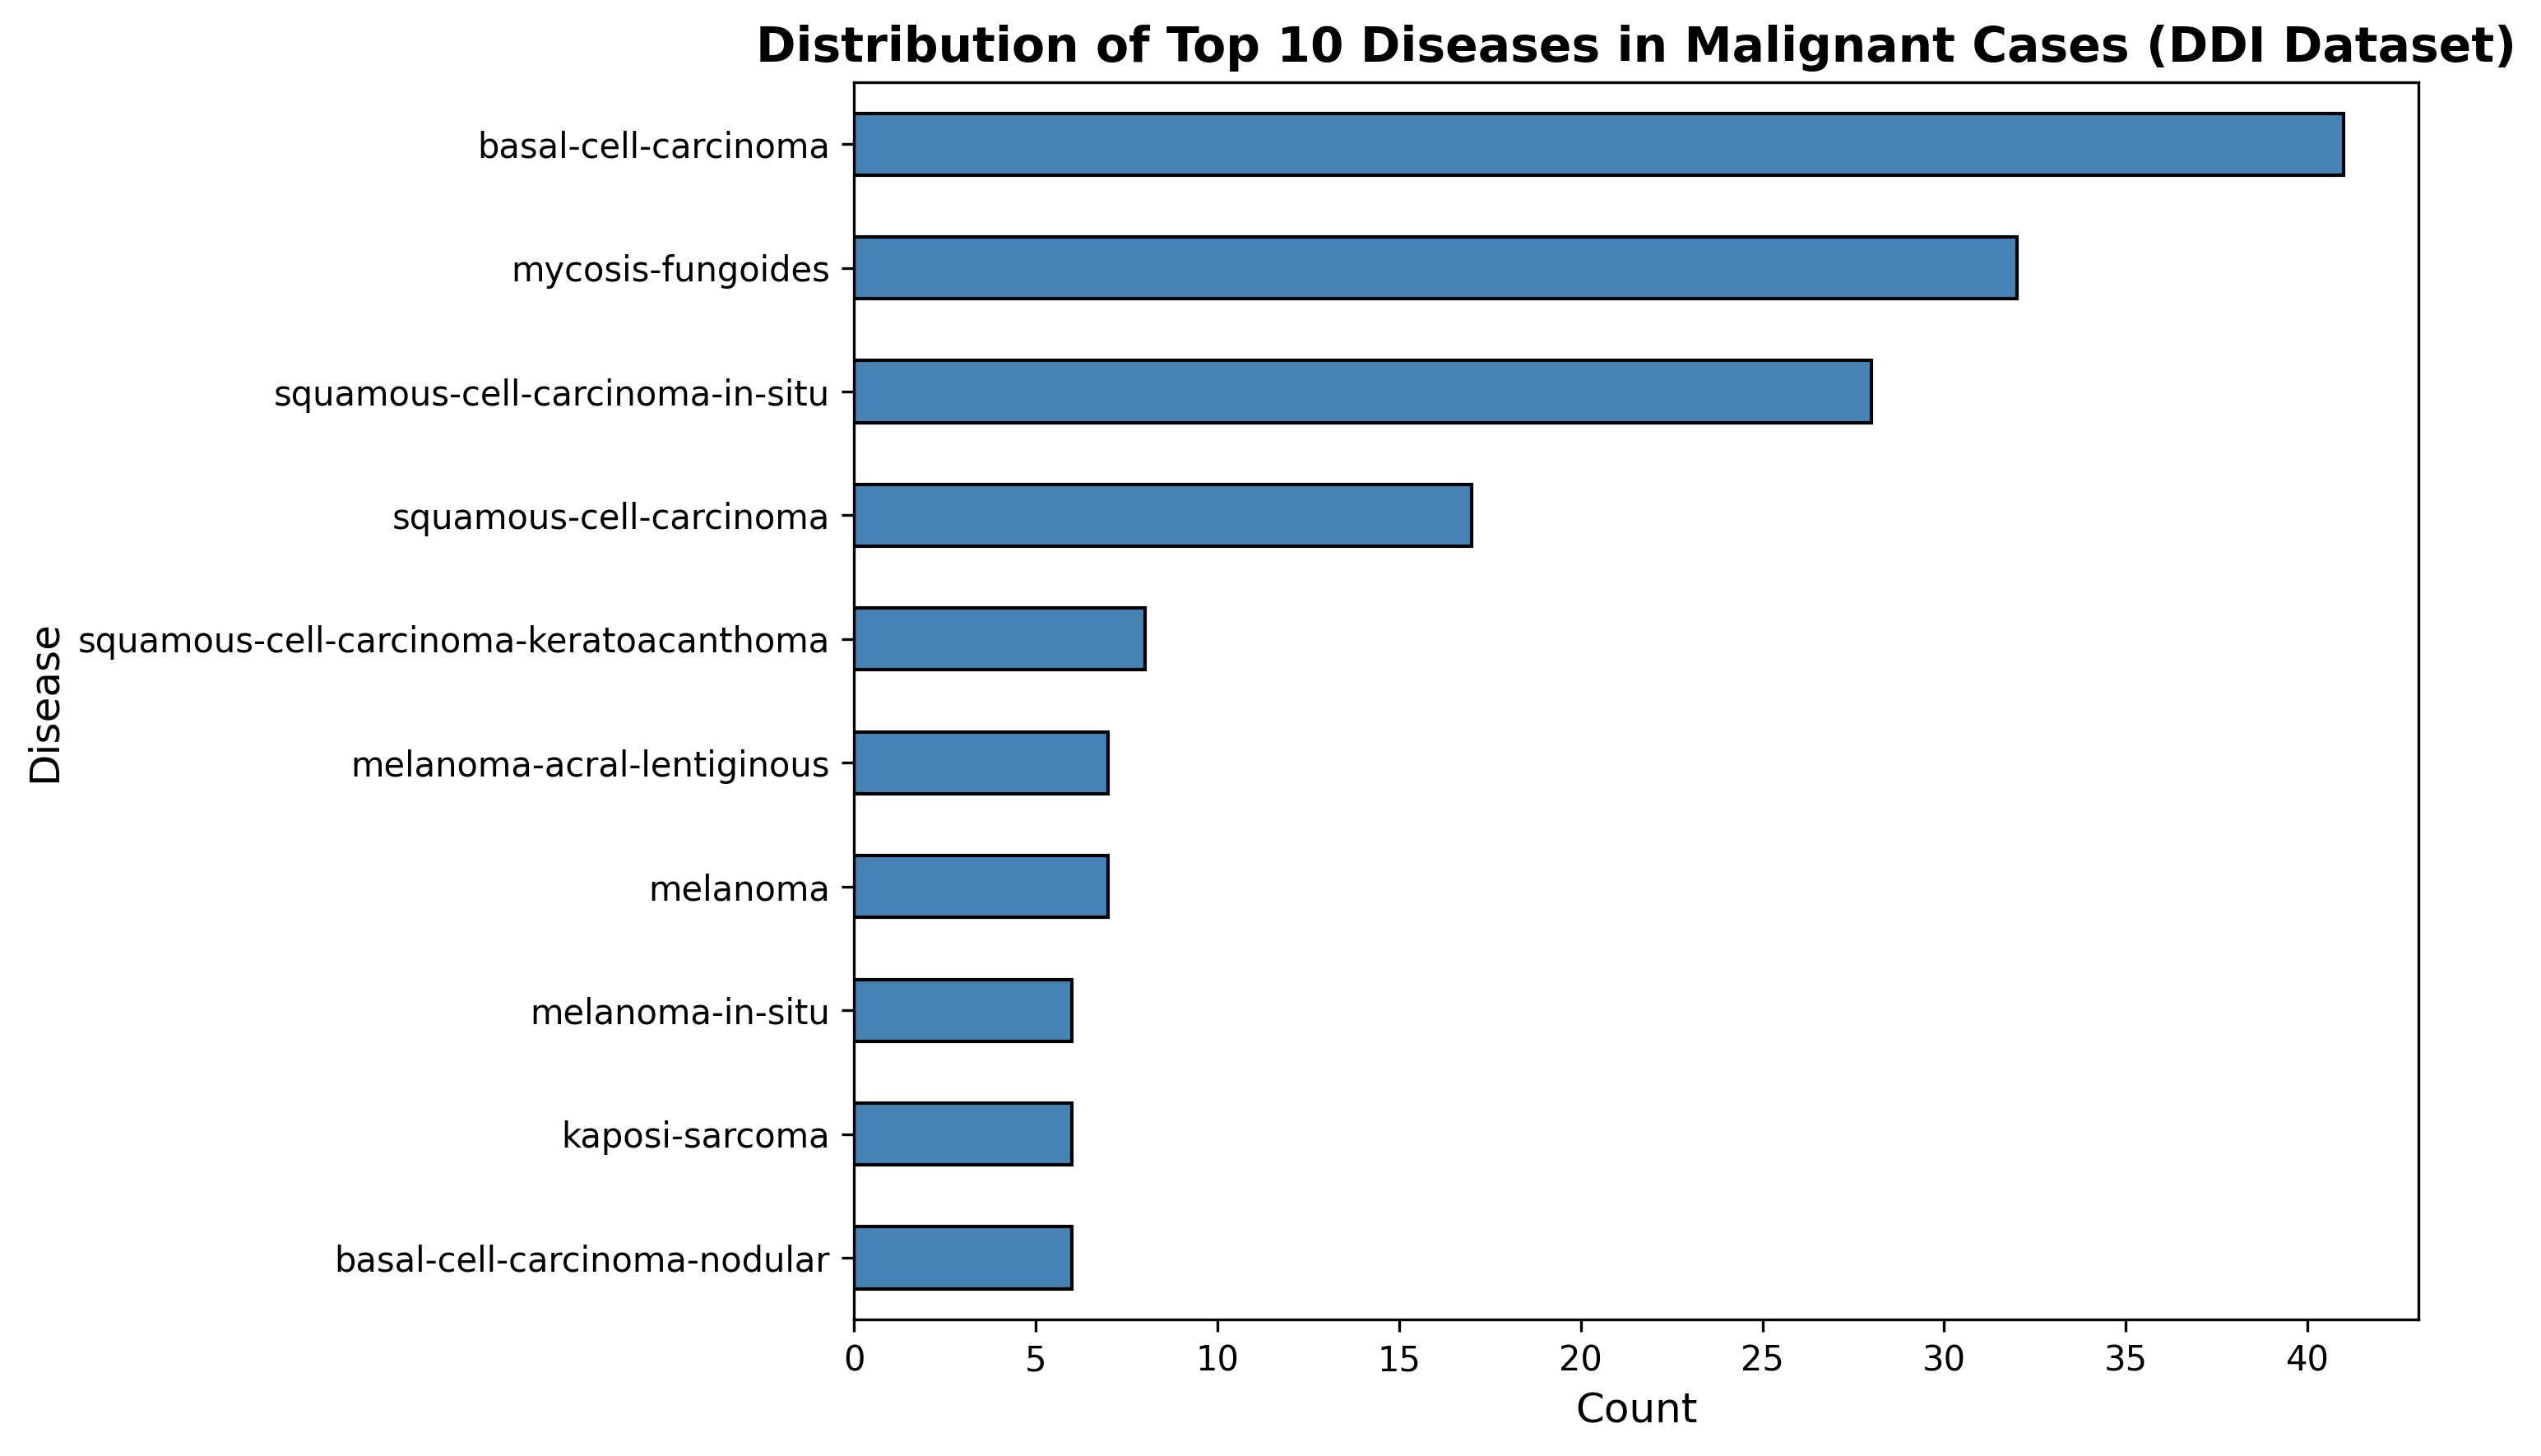

In [858]:
# Filter for malignant cases only and show top diseases
malignant_diseases = ddi_df[ddi_df['malignant'] == True]['disease'].value_counts().head(10)
print("Top 10 diseases in malignant cases:")
print(malignant_diseases)

print("\n" + "="*50 + "\n")

# Visualize top 10 malignant diseases
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
malignant_diseases.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Disease', fontsize=12)
ax.set_title('Distribution of Top 10 Diseases in Malignant Cases (DDI Dataset)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


This visualisation shows the distribution of the most frequent disease categories among malignant cases in the dataset. Basal cell carcinoma and squamous cell carcinoma variants constitute a large proportion of malignant samples, while melanoma and its subtypes appear less frequently but remain clinically significant due to their higher associated mortality risk. 

Grouped disease counts:
disease_grouped
Squamous Cell Carcinoma    53
Basal Cell Carcinoma       49
Melanoma                   21
Name: count, dtype: int64


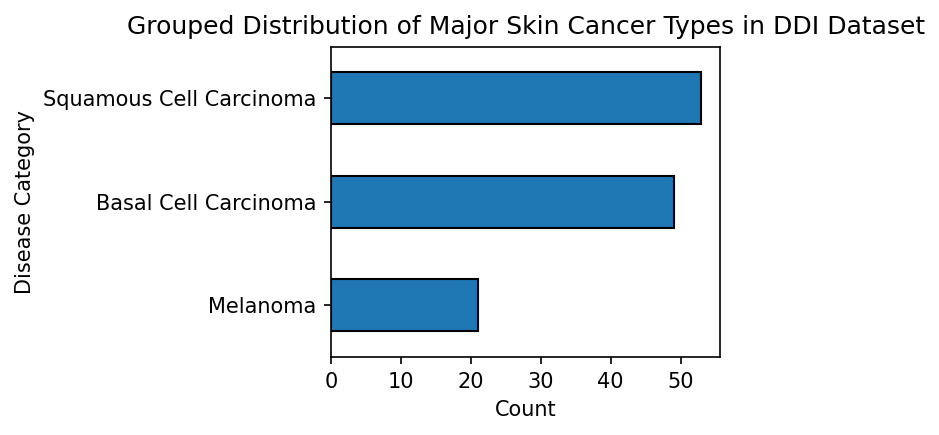

In [1052]:
# Define mapping function
def group_disease(disease):
    if pd.isna(disease):
        return None
    d = disease.lower()
    if 'melanoma' in d:
        return 'Melanoma'
    elif 'basal' in d:
        return 'Basal Cell Carcinoma'
    elif 'squamous' in d:
        return 'Squamous Cell Carcinoma'
    elif 'keratoacanthoma type' in d:
        return 'Squamous Cell Carcinoma'
    else:
        return None
    

# Apply grouping
ddi_df['disease_grouped'] = ddi_df['disease'].apply(group_disease)

# Filter only the three target diseases
filtered_diseases = ddi_df[ddi_df['disease_grouped'].notna()]

disease_counts = filtered_diseases['disease_grouped'].value_counts()

print("Grouped disease counts:")
print(disease_counts)


fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

disease_counts.plot(
    kind='barh',
    ax=ax,
    edgecolor='black'
)

ax.set_xlabel('Count')
ax.set_ylabel('Disease Category')
ax.set_title(
    'Grouped Distribution of Major Skin Cancer Types in DDI Dataset',
)

ax.invert_yaxis()
plt.tight_layout()
plt.show()

Grouped disease counts stratified by FST group (I–II vs V–VI):
fst_binary               FST I–II  FST V–VI
disease_grouped                            
Basal Cell Carcinoma           14         0
Melanoma                        7         7
Squamous Cell Carcinoma        21         9


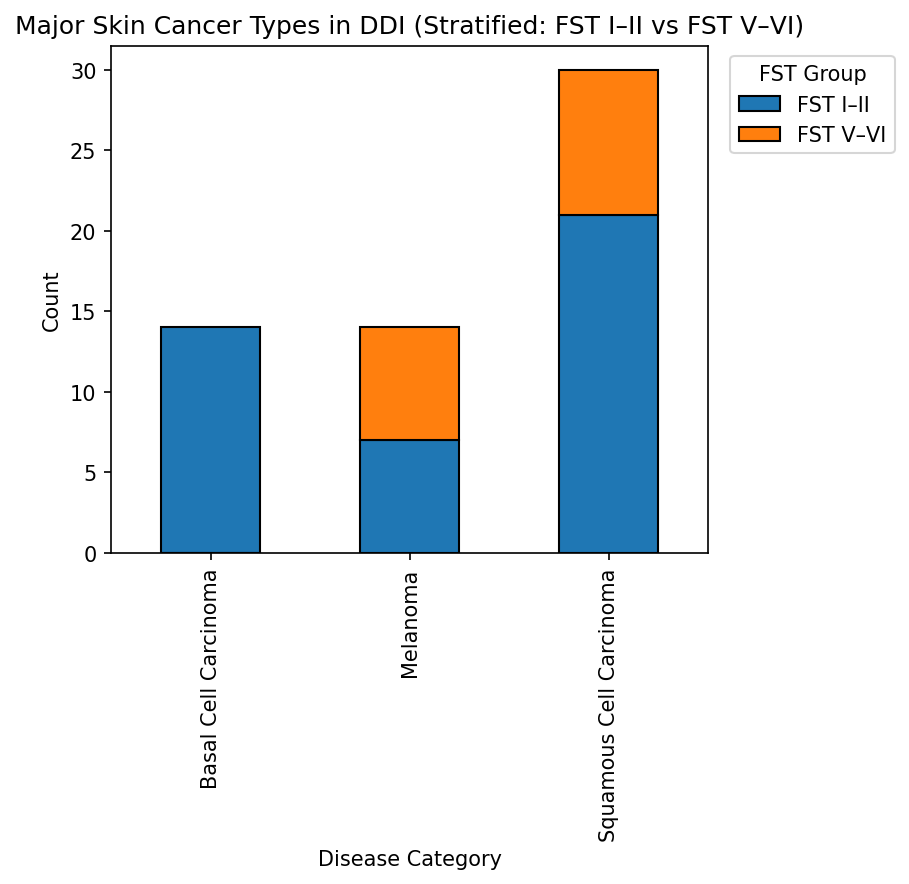

In [1056]:

# Group disease labels into 3 canonical classes 
def group_disease(disease):
    if pd.isna(disease):
        return None
    d = str(disease).lower()
    if 'melanoma' in d:
        return 'Melanoma'
    elif 'basal' in d:
        return 'Basal Cell Carcinoma'
    elif 'squamous' in d:
        return 'Squamous Cell Carcinoma'
    return None

ddi_df['disease_grouped'] = ddi_df['disease'].apply(group_disease)

#rename skin tone groups
def map_fst_binary(v):
    if pd.isna(v):
        return None
    s = str(v).strip().upper().replace('FST', '').replace('TYPE', '').replace(' ', '')
    if s in ['I-II']:
        return 'FST I–II'
    if s in ['V-VI']:
        return 'FST V–VI'
    return None

ddi_df['fst_binary'] = ddi_df['fst_group'].apply(map_fst_binary)

filtered = ddi_df[
    ddi_df['disease_grouped'].notna() &
    ddi_df['fst_binary'].notna()
].copy()


counts = pd.crosstab(filtered['disease_grouped'], filtered['fst_binary']).reindex(
    columns=['FST I–II', 'FST V–VI'], fill_value=0
)

print("Grouped disease counts stratified by FST group (I–II vs V–VI):")
print(counts)

# Visualize
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
counts.plot(kind='bar', stacked=True, ax=ax, edgecolor='black')

ax.set_ylabel('Count')
ax.set_xlabel('Disease Category')
ax.set_title('Major Skin Cancer Types in DDI (Stratified: FST I–II vs FST V–VI)')
ax.legend(title='FST Group', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

##### Observations:

This visualisation presents grouped malignant disease counts of common skin cancers stratified by Fitzpatrick skin tone groups (FST I–II vs FST V–VI). While basal and squamous cell carcinomas are substantially more prevalent in lighter skin tones, melanoma exhibits comparable counts across both groups (7 cases each). Consequently, melanoma constitutes a much larger proportion of malignant cases in darker skin tones, where other carcinoma types are less represented. This pattern underscores the disproportionate clinical burden of melanoma in darker-skinned populations and highlights the importance of sensitivity-focused and fairness-aware evaluation in skin cancer detection models.

Top 3 malignant diseases per Fitzpatrick group:
   fst_binary                    disease_clean  count
10   FST I–II  squamous-cell-carcinoma-in-situ     15
0    FST I–II             basal-cell-carcinoma      7
1    FST I–II     basal-cell-carcinoma-nodular      6
18   FST V–VI                mycosis-fungoides     26
19   FST V–VI          squamous-cell-carcinoma      5
15   FST V–VI       melanoma-acral-lentiginous      3


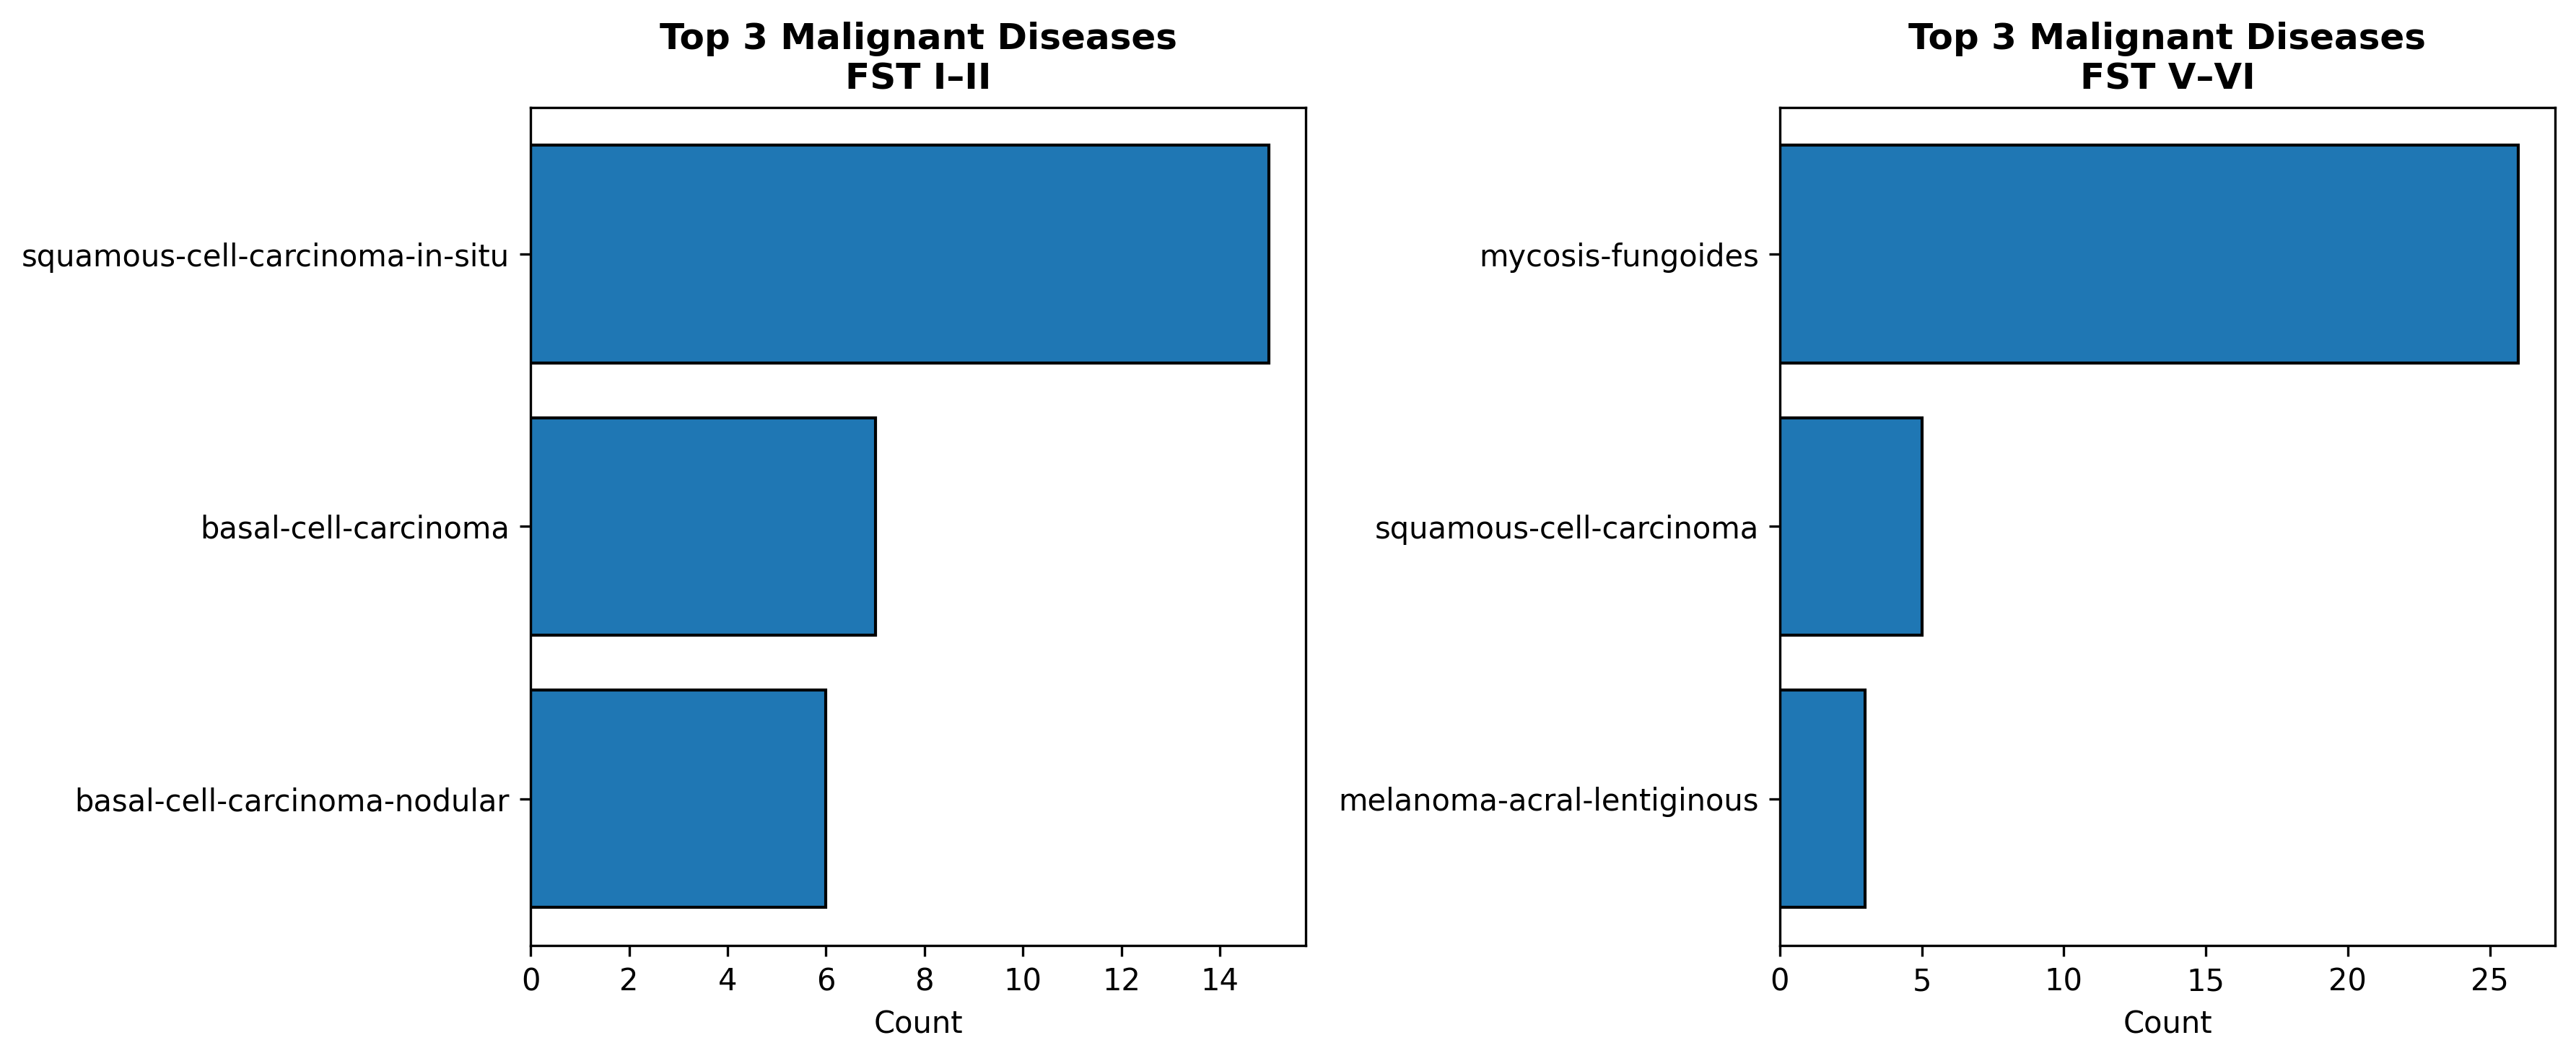

In [ ]:
# Clean disease labels
ddi_df['disease_clean'] = ddi_df['disease'].str.strip().str.lower()

# ===== 3) Filter: valid FST groups AND malignant cases only =====
df = ddi_df[
    ddi_df['fst_binary'].notna() &
    (ddi_df['malignant'] == True)
].copy()

# Get top 3 malignant diseases per FST group 
top3_by_fst = (
    df.groupby(['fst_binary', 'disease_clean'])
      .size()
      .reset_index(name='count')
      .sort_values(['fst_binary', 'count'], ascending=[True, False])
      .groupby('fst_binary')
      .head(3)
)

print("Top 3 malignant diseases per Fitzpatrick group:")
print(top3_by_fst)

# Visualization: one subplot per FST group 
fst_groups = top3_by_fst['fst_binary'].unique()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(fst_groups),
    figsize=(12, 5),
    dpi=150,
    sharey=False
)

if len(fst_groups) == 1:
    axes = [axes]

for ax, fst in zip(axes, fst_groups):
    subset = top3_by_fst[top3_by_fst['fst_binary'] == fst]
    ax.barh(subset['disease_clean'], subset['count'], edgecolor='black')
    ax.set_title(f'Top 3 Malignant Diseases\n{fst}', fontweight='bold')
    ax.set_xlabel('Count')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

##### Observations:

Stratified analysis of the top malignant disease categories further underscores the need for equitable diagnostic systems. The results show that melanoma consistently appears among the top three malignant conditions affecting individuals with darker skin tones in the dataset, despite lower overall incidence compared to lighter skin tones. This reinforces the clinical importance of sensitivity-focused evaluation for skin cancer detection in darker-skinned populations. Additionally, mycosis fungoides is observed among the most frequent malignant labels; although it primarily originates from the blood as a form of cutaneous T-cell lymphoma, it manifests in the skin and presents diagnostic challenges similar to primary skin cancers. This highlights the diverse and clinically complex nature of malignant skin-related conditions and further motivate the development of robust, fairness-aware diagnostic models.

Visualizing distribution of data:


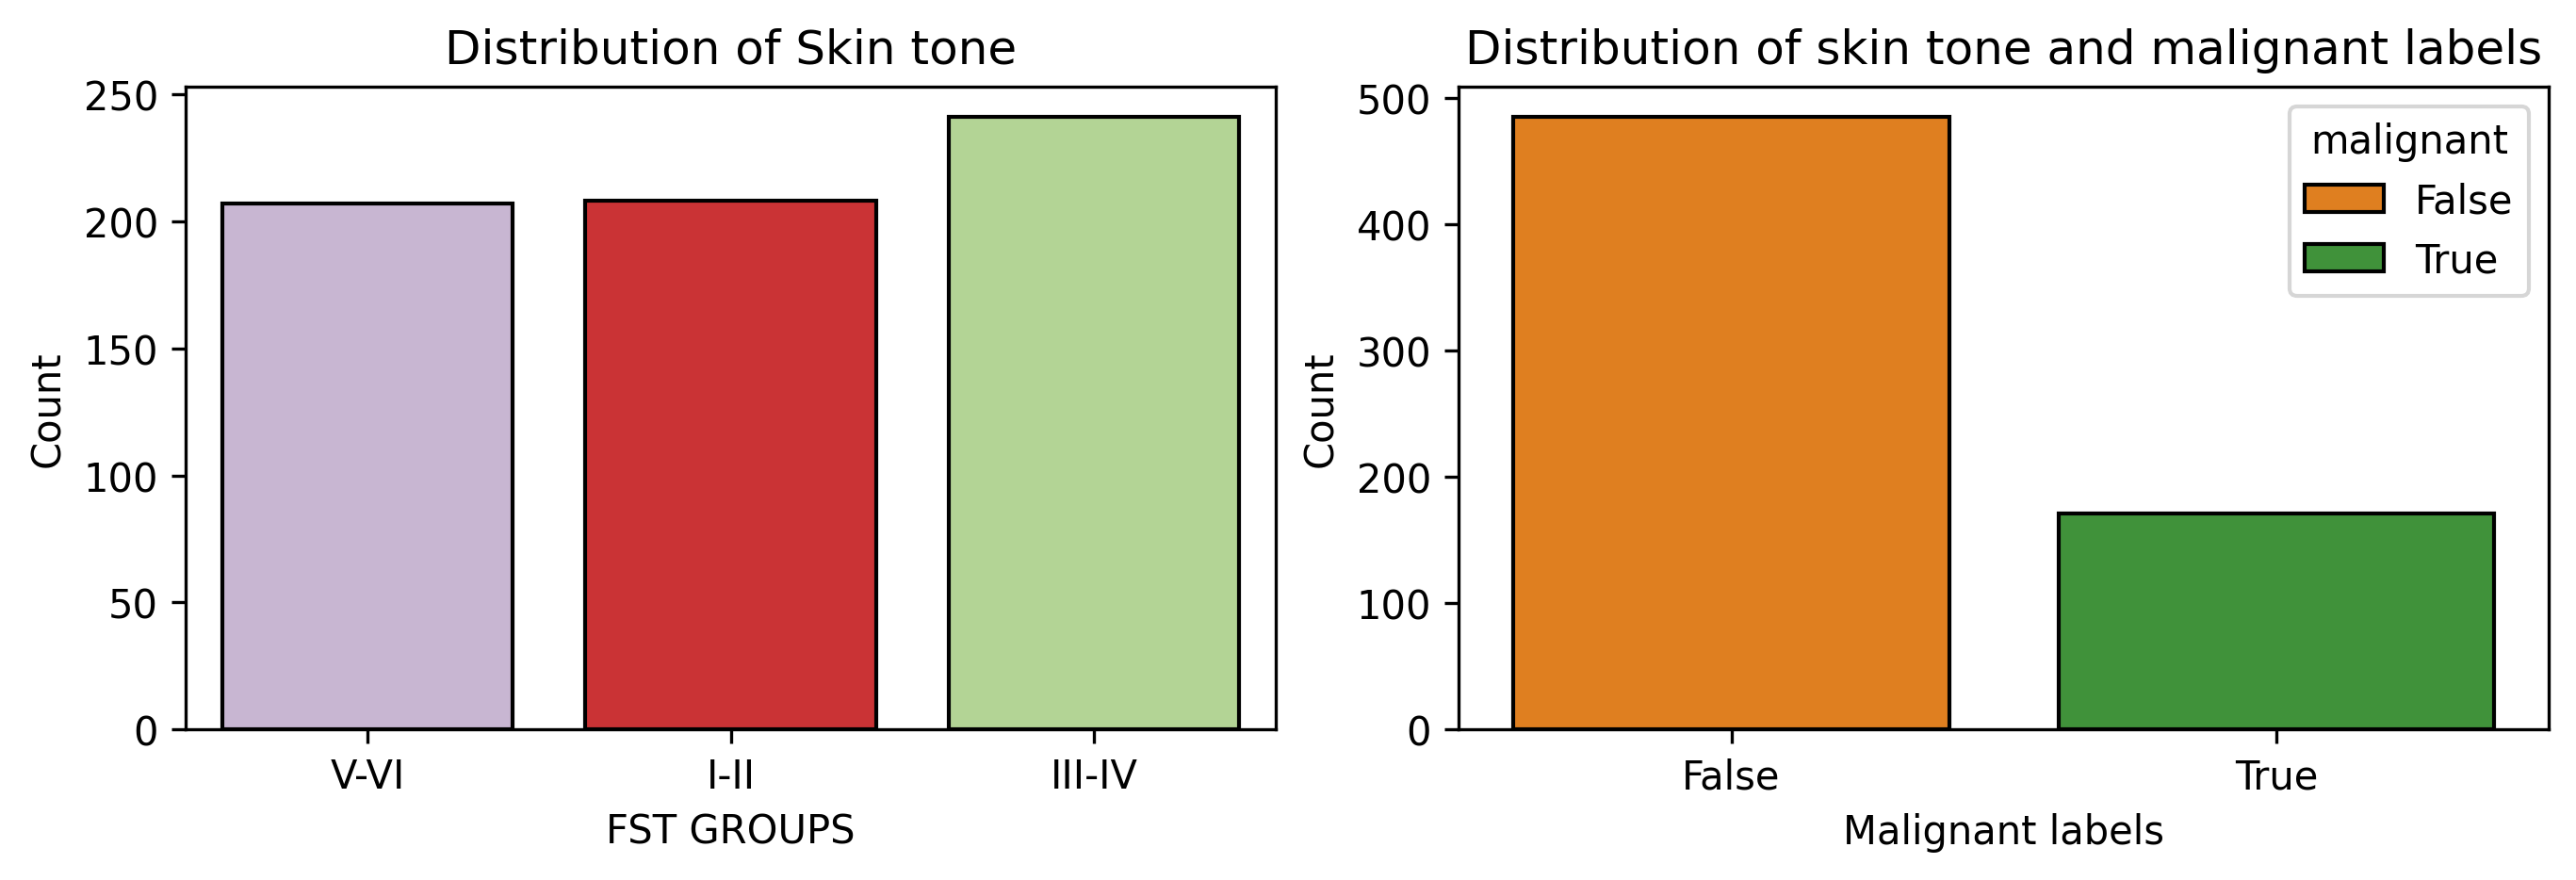

In [538]:
fig, axs = plt.subplots(1,2, figsize=(9,3), dpi=300, layout="constrained")

print("Visualizing distribution of data:")

# Visualize the distribution of combined_fst
sns.countplot(data=ddi_df, x='fst_group',hue=ddi_df["fst_group"], edgecolor="black", palette="Paired_r",ax=axs[0])
axs[0].set_title('Distribution of Skin tone')
axs[0].set_xlabel('FST GROUPS')
axs[0].set_ylabel('Count')

# Visualize the distribution of binary_label
sns.countplot(data=ddi_df, x='malignant', hue=ddi_df["malignant"], edgecolor="black", palette="Paired_r", ax=axs[1])
axs[1].set_title('Distribution of malignant labels')
axs[1].set_xlabel('Malignant labels')
axs[1].set_ylabel('Count')

plt.title('Distribution of skin tone and malignant labels')
plt.show()

### Visualizing the diagnosis based on the fitzpatrick group

Counts of each Fitzpatrick value 
fst_group
I-II      208
III-IV    241
V-VI      207
Name: count, dtype: int64


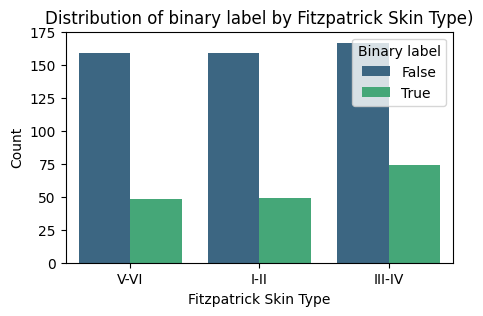


Diagnosis (label) counts by Fitzpatrick value
malignant  False  True 
fst_group              
I-II         159     49
III-IV       167     74
V-VI         159     48
------------------------------


In [915]:
#Examine the unique values and their counts in the 'fitzpatrick' column
fitzpatrick_counts = ddi_df['fst_group'].value_counts().sort_index()
print(f"Counts of each Fitzpatrick value ")
print(fitzpatrick_counts)

# Visualize the relationship between Fitzpatrick and three_partition_label for the split
plt.figure(figsize=(5, 3), dpi=100)
sns.countplot(data=ddi_df, x='fst_group', hue='malignant', palette='viridis')
plt.title(f'Distribution of binary label by Fitzpatrick Skin Type)')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Count')
plt.legend(title='Binary label')
plt.show()

# Print the diagnosis count based on the different fitzpatrick class
print(f"\nDiagnosis (label) counts by Fitzpatrick value")
diagnosis_counts_by_fitzpatrick = ddi_df.groupby('fst_group')['malignant'].value_counts().unstack().fillna(0)
print(diagnosis_counts_by_fitzpatrick)

print("-" * 30) # Separator 

Display images per fitzpatrick


Displaying one image per label class for each fitzpatrick scale class:


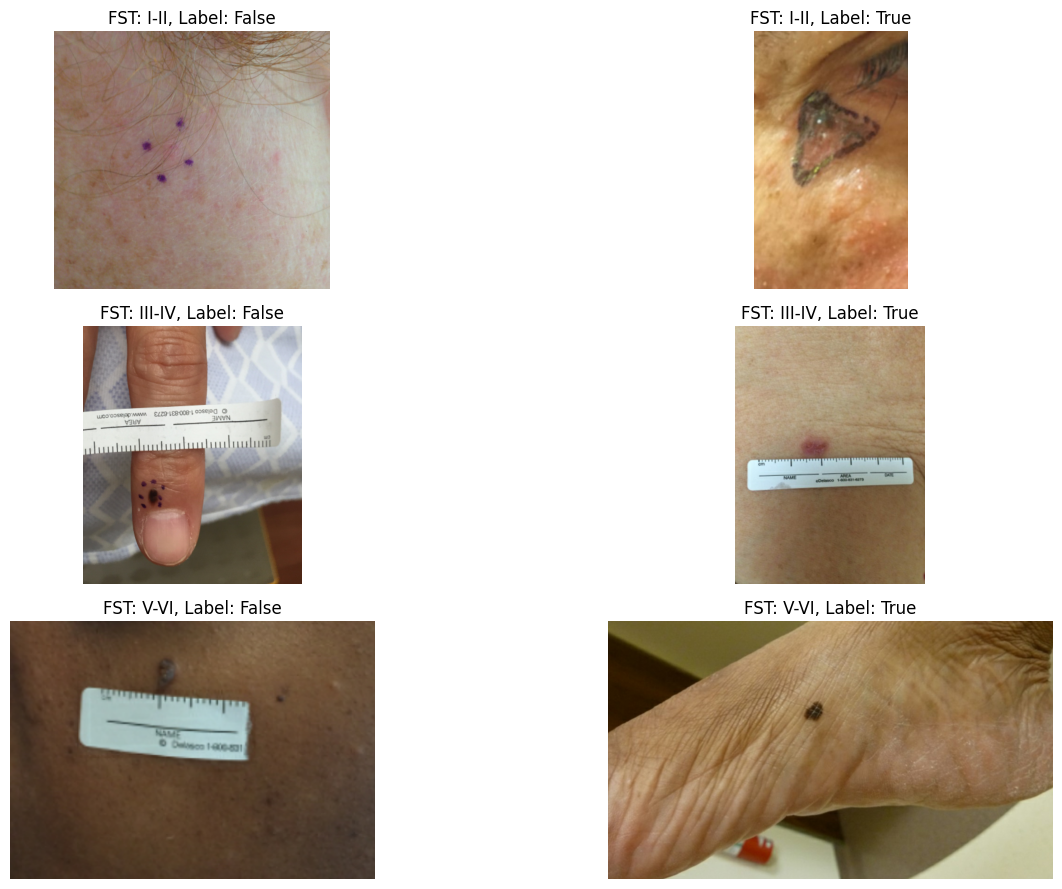

In [ ]:

def display_one_image_per_fst(df, fst_column, label_column, image_dir, image_name_col):

    if fst_column not in df.columns:
        print(f"Column '{fst_column}' not found in the dataframe. Skipping.")
        return
    
    if label_column not in df.columns:
        print(f"Column '{label_column}' not found in the dataframe. Skipping.")
        return
    
    unique_fst_classes = sorted(df[fst_column].unique())
    unique_label_classes = sorted(df[label_column].unique())
    
    print(f"\nDisplaying one image per label class for each fitzpatrick scale class:")
    
    fig, axes = plt.subplots(len(unique_fst_classes), len(unique_label_classes), 
                             figsize=(15, 3 * len(unique_fst_classes)))
    
    for fst_idx, fst_value in enumerate(unique_fst_classes):
        for label_idx, label_value in enumerate(unique_label_classes):
            ax = axes[fst_idx, label_idx] if len(unique_fst_classes) > 1 else axes[label_idx]
            
            image_row = df[(df[fst_column] == fst_value) & 
                          (df[label_column] == label_value) & 
                          (df[image_name_col].notna())]
            
            if len(image_row) > 0:
                image_name = image_row.iloc[0][image_name_col]
                image_path = os.path.join(image_dir, image_name)
                
                if os.path.exists(image_path):
                    try:
                        img = Image.open(image_path)
                        ax.imshow(img)
                        ax.set_title(f"FST: {fst_value}, Label: {label_value}")
                        ax.axis('off')
                    except Exception as e:
                        ax.text(0.5, 0.5, f"Error loading image", ha='center', va='center')
                        ax.axis('off')
                else:
                    ax.text(0.5, 0.5, f"Image not found", ha='center', va='center')
                    ax.axis('off')
            else:
                ax.text(0.5, 0.5, f"No image found", ha='center', va='center')
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Specify the columns to display and call the function
columns_to_display = ['fst_group', 'malignant']
display_one_image_per_fst(ddi_df, fst_column="fst_group", label_column="malignant",image_dir=ddi_image_base_dir, image_name_col="DDI_file")

This bisualisation shows samples of images present in the dataset

Split dataset into train, val and test by stratifying on a combined fst and malignant column 

In [927]:
# Create a composite column for stratification
# Convert columns to string types to ensure proper concatenation
ddi_df['skin_tone_malignant'] = ddi_df['skin_tone'].astype(str) + '_' + ddi_df['malignant'].astype(str)

print("Value counts of the new composite column 'skin_tone_malignant':")
print(ddi_df['skin_tone_malignant'].value_counts())

ddi_df.head()

Value counts of the new composite column 'skin_tone_malignant':
skin_tone_malignant
34_False    167
12_False    159
56_False    159
34_True      74
12_True      49
56_True      48
Name: count, dtype: int64


Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
0           0       1  000001.png         56       True   
1           1       2  000002.png         56       True   
2           2       3  000003.png         56       True   
3           3       4  000004.png         56       True   
4           4       5  000005.png         12       True   

                           disease fst_group skin_tone_malignant  
0                 melanoma-in-situ      V-VI             56_True  
1                 melanoma-in-situ      V-VI             56_True  
2                mycosis-fungoides      V-VI             56_True  
3  squamous-cell-carcinoma-in-situ      V-VI             56_True  
4             basal-cell-carcinoma      I-II             12_True

In [ ]:
# Perform the train-test split using the composite column for stratification
from sklearn.model_selection import train_test_split


Train, ddi_X_test = train_test_split( ddi_df, test_size=0.1, random_state=42, stratify=ddi_df['skin_tone_malignant'])
ddi_X_train, ddi_X_val = train_test_split(Train, test_size=0.1,random_state=42, stratify=Train['skin_tone_malignant'])


print("\nTrain-test split performed using stratification on 'skin_tone' and 'malignant'.")
print(f"Train shape: {ddi_X_train.shape}")
print(f"Validation shape: {ddi_X_val.shape}")
print(f"Test shape: {ddi_X_test.shape}")

# Verify the distribution in the splits
print("\nDistribution in Train split:")
print(ddi_X_train['skin_tone_malignant'].value_counts(normalize=True))

print("\nDistribution in Validation split:")
print(ddi_X_val['skin_tone_malignant'].value_counts(normalize=True))

print("\nDistribution in Test split:")
print(ddi_X_test['skin_tone_malignant'].value_counts(normalize=True))


Train-test split performed using stratification on 'skin_tone' and 'malignant'.
Train shape: (531, 9)
Validation shape: (59, 9)
Test shape: (66, 9)

Distribution in Train split:
skin_tone_malignant
34_False    0.254237
12_False    0.242938
56_False    0.242938
34_True     0.112994
12_True     0.073446
56_True     0.073446
Name: proportion, dtype: float64

Distribution in Validation split:
skin_tone_malignant
34_False    0.254237
12_False    0.237288
56_False    0.237288
34_True     0.118644
12_True     0.084746
56_True     0.067797
Name: proportion, dtype: float64

Distribution in Test split:
skin_tone_malignant
34_False    0.257576
12_False    0.242424
56_False    0.242424
34_True     0.106061
56_True     0.075758
12_True     0.075758
Name: proportion, dtype: float64


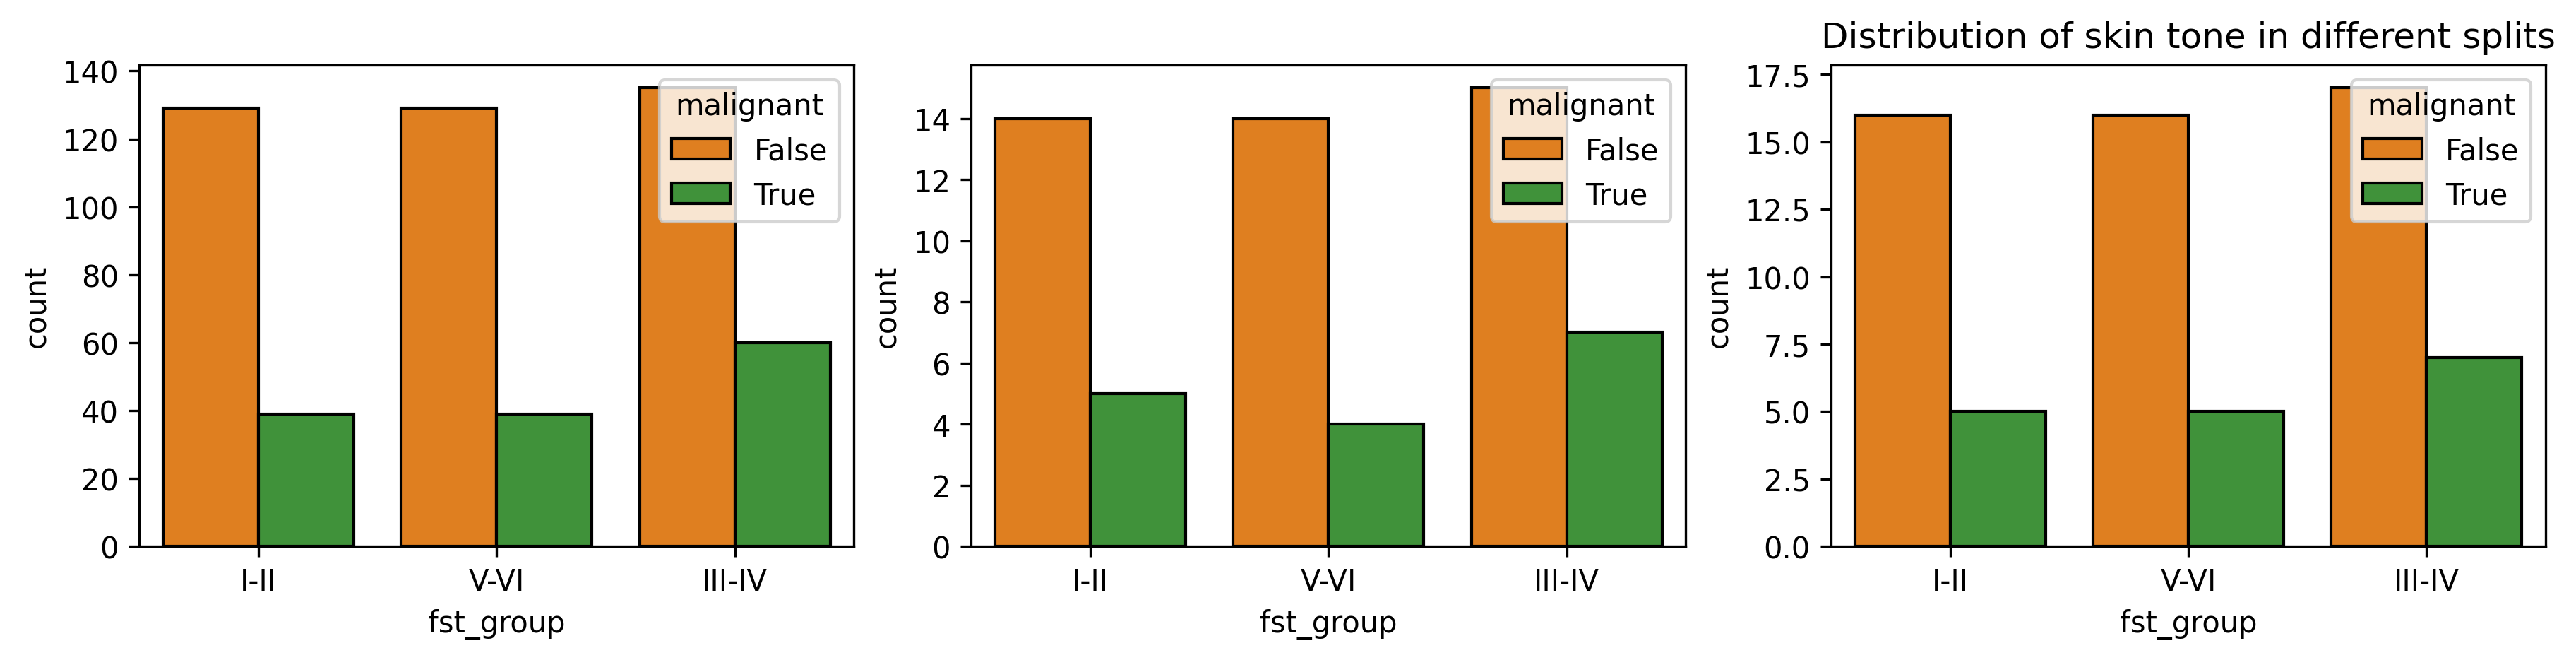

In [544]:
fig, axs = plt.subplots(1,3, figsize=(12,3), dpi=300, layout="constrained")

for i, df in enumerate([ddi_X_train, ddi_X_val, ddi_X_test]):
    sns.countplot(data=df, x='fst_group', hue=df["malignant"], edgecolor="black", palette="Paired_r",ax=axs[i])
    axs[i].set_title("")

plt.title("Distribution of skin tone in different splits")
plt.show()




## MODEL STRUCTURE

In this section, we examine the architecture of three variants of the DINOv2 Vision Transformer model, namely the Small, Base, and Large backbones. DINOv2 is a general-purpose pretrained visual representation model trained on large-scale, diverse image data using self-supervised learning. Rather than relying on a domain-specific dermatology model, we intentionally adopt DINOv2 to evaluate the effectiveness of Low-Rank Adaptation (LoRA) in transferring generic visual representations to a specialised medical imaging task. This choice allows us to assess to investigate how much algorithmic skin tone bias can be present in a general purpose model. Secondly how much task- and fairness-specific knowledge can be injected through Low Rank Adapters alone, without relying on domain-specific pretraining, thereby providing a clearer evaluation of LoRA’s adaptability and robustness in the context of skin cancer detection. 

#### DINO V2 SMALL

In [ ]:
# Load the pre-trained model
from torchinfo import summary


model_name_small = 'facebook/dinov2-small' # Using the DINOv2 small model variant

print(f"\nLoading pre-trained model: {model_name_small}")
# Load the pre-trained PyTorch model for image classification
dino_v2_small= AutoModelForImageClassification.from_pretrained(model_name_small)
print("Model loaded successfully.")

#model image size
input_image_size = 224

# Get the model summary
input_size = (1, 3, input_image_size, input_image_size)

# Get the model summary
summary(dino_v2_small, input_size=input_size)


Loading pre-trained model: facebook/dinov2-small


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.


Layer (type:depth-idx)                                       Output Shape              Param #
Dinov2ForImageClassification                                 [1, 2]                    --
├─Dinov2Model: 1-1                                           [1, 384]                  --
│    └─Dinov2Embeddings: 2-1                                 [1, 257, 384]             526,848
│    │    └─Dinov2PatchEmbeddings: 3-1                       [1, 256, 384]             226,176
│    │    └─Dropout: 3-2                                     [1, 257, 384]             --
│    └─Dinov2Encoder: 2-2                                    [1, 257, 384]             --
│    │    └─ModuleList: 3-3                                  --                        21,302,784
│    └─LayerNorm: 2-3                                        [1, 257, 384]             768
├─Linear: 1-2                                                [1, 2]                    1,538
Total params: 22,058,114
Trainable params: 22,058,114
Non-trainable param

#### DINO V2 BASE

In [884]:
# Load the pre-trained model
model_name_base = 'facebook/dinov2-base' # Using the DINOv2 small model variant

print(f"\nLoading pre-trained model: {model_name_base}")
# Load the pre-trained PyTorch model for image classification
dino_v2_base= AutoModelForImageClassification.from_pretrained(model_name_base)
print("Model loaded successfully.")

#model image size
input_image_size = 224

# Get the model summary
input_size = (1, 3, input_image_size, input_image_size)

# Get the model summary
summary(dino_v2_base, input_size=input_size)


Loading pre-trained model: facebook/dinov2-base


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.


Layer (type:depth-idx)                                       Output Shape              Param #
Dinov2ForImageClassification                                 [1, 2]                    --
├─Dinov2Model: 1-1                                           [1, 768]                  --
│    └─Dinov2Embeddings: 2-1                                 [1, 257, 768]             1,053,696
│    │    └─Dinov2PatchEmbeddings: 3-1                       [1, 256, 768]             452,352
│    │    └─Dropout: 3-2                                     [1, 257, 768]             --
│    └─Dinov2Encoder: 2-2                                    [1, 257, 768]             --
│    │    └─ModuleList: 3-3                                  --                        85,072,896
│    └─LayerNorm: 2-3                                        [1, 257, 768]             1,536
├─Linear: 1-2                                                [1, 2]                    3,074
Total params: 86,583,554
Trainable params: 86,583,554
Non-trainable p

#### DINO V2 LARGE

In [738]:
# Load the pre-trained model
model_name_large = 'facebook/dinov2-large' # Using the DINOv2 small model variant

print(f"\nLoading pre-trained model: {model_name_large}")
# Load the pre-trained PyTorch model for image classification
dino_v2_large= AutoModelForImageClassification.from_pretrained(model_name_large)
print("Model loaded successfully.")

#model image size
input_image_size = 224

# Get the model summary
input_size = (1, 3, input_image_size, input_image_size)

# Get the model summary
summary(dino_v2_large, input_size=input_size)


Loading pre-trained model: facebook/dinov2-large


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.


Layer (type:depth-idx)                                       Output Shape              Param #
Dinov2ForImageClassification                                 [1, 2]                    --
├─Dinov2Model: 1-1                                           [1, 1024]                 --
│    └─Dinov2Embeddings: 2-1                                 [1, 257, 1024]            1,404,928
│    │    └─Dinov2PatchEmbeddings: 3-1                       [1, 256, 1024]            603,136
│    │    └─Dropout: 3-2                                     [1, 257, 1024]            --
│    └─Dinov2Encoder: 2-2                                    [1, 257, 1024]            --
│    │    └─ModuleList: 3-3                                  --                        302,358,528
│    └─LayerNorm: 2-3                                        [1, 257, 1024]            2,048
├─Linear: 1-2                                                [1, 2]                    4,098
Total params: 304,372,738
Trainable params: 304,372,738
Non-trainabl

## LINEAR PROBING OF THE MODELS

In this section, we perform a linear probing analysis to assess the quality of the feature representations learned by the LoRA-adapted models independently of the classification head. All model parameters are frozen, and the network is used purely as a fixed feature extractor to generate embeddings for the training and test images. A logistic regression classifier is then trained on these embeddings and evaluated on the held-out test set. This analysis provides insight into how LoRA fine-tuning reshapes the underlying feature space, revealing whether improvements in downstream performance and fairness stem from more separable and informative representations rather than from the classification head alone.

We define functions to extract features using the pretrained model, train the logistic regression, and evaluate the model

In [902]:
#function to extract features for dinoV2

def extract_features_DinoV2(model, dataloader, device):
    model.to(device)
    model.eval() # Set model to evaluation mode

    all_features = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculation for inference
        for batch in dataloader:
            images = batch[0].to(device) 
            labels = batch[1] 

            # Forward pass to get model outputs
            outputs = model(images, output_hidden_states=True) # Request hidden states
            # Access the last hidden state
            last_hidden_states = outputs.hidden_states[-1] # Shape: (batch_size, sequence_length, hidden_size)

            # The CLS token's hidden state is the first token (index 0)
            # Shape: (batch_size, hidden_size)
            features = last_hidden_states[:, 0, :]

            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    print(f"\nFeature extraction complete. Extracted features shape: {all_features.shape}")
    print(f"Extracted labels shape: {all_labels.shape}")

    return all_features, all_labels

#Function to Train logistic regression.
def train_logistic_regression_model(X_train, y_train):
    # Calculate M (embedding dimension) and C_classes (number of classes)
    M = X_train.shape[1]
    C_classes = len(np.unique(y_train))

    # Calculate the L2 regularization parameter (lambda) as MC / 100
    lambda_val = (M * C_classes) / 100.0
    C_param = 1.0 / lambda_val

    print(f"Embedding dimension (M): {M}")
    print(f"Number of classes (C_classes): {C_classes}")
    print(f"Calculated lambda (MC/100): {lambda_val:.4f}")
    print(f"Calculated scikit-learn C parameter (1/lambda): {C_param:.4f}")

    # Initialize Logistic Regression model
    logistic_classifier = LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        C=C_param,
        random_state=42
    )
    # Train on full training set
    logistic_classifier.fit(X_train, y_train)
    print("\nLogistic Regression classifier trained on full training set.")
    
    return logistic_classifier


#Function for evaluate logistic regression model based on fst

def evaluate_logistic_regression_fst(model, test_features, test_labels, test_df, fst_column_name):

    print("\nEvaluating Logistic Regression model")

    # Predictions
    predicted_labels_all = model.predict(test_features)
    predicted_probs_all = model.predict_proba(test_features)[:, 1]

    # Build evaluation DataFrame
    evaluation_df = pd.DataFrame({
        "true_label": test_labels,
        "predicted_label": predicted_labels_all,
        "predicted_prob": predicted_probs_all,
        fst_column_name: test_df[fst_column_name].reset_index(drop=True)
    })

    #---- OVERALL METRICS

    overall_metrics = {}

    overall_accuracy = accuracy_score(test_labels, predicted_labels_all)
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        test_labels, predicted_labels_all, average="weighted", zero_division=0
    )

    try:
        overall_auc_score = roc_auc_score(test_labels, predicted_probs_all)
    except:
        overall_auc_score = np.nan

    overall_metrics = {
        "accuracy": overall_accuracy,
        "precision": overall_precision,
        "recall": overall_recall,
        "f1": overall_f1,
        "auc": overall_auc_score,
    }

    print("\n--- Overall Metrics ---")
    print(f"  AUC: {overall_auc_score:.4f}")
    print(f"  Accuracy: {overall_accuracy:.4f}")
    print(f"  Precision (weighted): {overall_precision:.4f}")
    print(f"  Recall (weighted): {overall_recall:.4f}")
    print(f"  F1-score (weighted): {overall_f1:.4f}")

    #----FST GROUPS

    TARGET_GROUPS = ["I-II", "V-VI"]

    fst_metrics = {}
    plot_data = []

    # Add overall results for plotting
    plot_data.append({
        "name": "Overall",
        "true_labels": test_labels,
        "predicted_labels": predicted_labels_all,
        "predicted_probs": predicted_probs_all,
        "metrics": overall_metrics,
        "sample_count": len(test_labels),
    })

    print("\nEvaluating Selected FST Groups: I-II and V-VI")

    for group in TARGET_GROUPS:
        group_df = evaluation_df[evaluation_df[fst_column_name] == group]

        print(f"\n--- FST Group: {group} ---")
        print(f"Samples: {len(group_df)}")

        if len(group_df) == 0:
            fst_metrics[group] = {
                "accuracy": np.nan,
                "precision": np.nan,
                "recall": np.nan,
                "f1": np.nan,
                "auc": np.nan,
            }
            continue

        true_group = group_df["true_label"].values
        pred_group = group_df["predicted_label"].values
        prob_group = group_df["predicted_prob"].values

        accuracy = accuracy_score(true_group, pred_group)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_group, pred_group, average="weighted", zero_division=0
        )

        try:
            auc_val = roc_auc_score(true_group, prob_group)
        except:
            auc_val = np.nan

        fst_metrics[group] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc_val,
        }
        print(f"  AUC: {auc_val:.4f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision (weighted): {precision:.4f}")
        print(f"  Recall (weighted): {recall:.4f}")
        print(f"  F1-score (weighted): {f1:.4f}")

        # Save for plots
        plot_data.append({
            "name": f"FST {group}",
            "true_labels": true_group,
            "predicted_labels": pred_group,
            "predicted_probs": prob_group,
            "metrics": fst_metrics[group],
            "sample_count": len(group_df),
        })

    #----PLOTS (ROC + Confusion Matrix)

    num_plots = len(plot_data)
    from matplotlib.gridspec import GridSpec
    fig = plt.figure(figsize=(5 * num_plots, 5), dpi=200)
    gs = GridSpec(1, num_plots, figure=fig)


    for idx, data in enumerate(plot_data):

        # --- Confusion Matrix ---
        ax_cm = fig.add_subplot(gs[0, idx])
        cm = confusion_matrix(data["true_labels"], data["predicted_labels"])

        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=ax_cm,
            xticklabels=["Non-Malignant", "Malignant"],
            yticklabels=["Non-Malignant", "Malignant"],
        )

        ax_cm.set_title(f"Confusion Matrix:\n{data['name']}")
        ax_cm.set_ylabel("True Label")
        ax_cm.set_xlabel("Predicted Label")

    plt.tight_layout()
    plt.show()

    plot_combined_roc(plot_data)

    return overall_metrics, fst_metrics

#function to plot combined ROC and confusion matrix
def plot_combined_roc(plot_data):

    plt.figure(figsize=(6, 5))

    for data in plot_data:
        name = data["name"]
        true_labels = data["true_labels"]
        predicted_probs = data["predicted_probs"]

        # Only plot ROC curves if there are both classes present
        if len(np.unique(true_labels)) < 2:
            print(f"Skipping ROC for {name}: only one class present.")
            continue

        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        auc_val = data["metrics"]["auc"]

        plt.plot(
            fpr, tpr,
            lw=2,
            label=f"{name} (AUC = {auc_val:.3f})"
        )

    # Random baseline
    plt.plot([0, 1], [0, 1], "k--", lw=1)

    plt.title("Combined ROC Curves: Overall vs FST Groups", fontsize=13)
    plt.xlabel("False Positive Rate", fontsize=11)
    plt.ylabel("True Positive Rate", fontsize=11)
    plt.legend(fontsize=10, loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



Create DataLoader class and functions

In [ ]:
class DDIDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, processor=None):

        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.processor = processor

        # Map boolean 'malignant' label to integers (False -> 0, True -> 1)
        self.label_map = {False: 0, True: 1}
        self.dataframe = self.dataframe.copy()  # Avoid SettingWithCopyWarning
        self.dataframe['label_encoded'] = self.dataframe['malignant'].map(self.label_map)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Use 'DDI_file' column for image filenames
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx]['DDI_file'])
        image = Image.open(img_name).convert('RGB')  # Ensure image is in RGB format
        label = self.dataframe.iloc[idx]['label_encoded']

        # Apply preprocessing
        if self.processor is not None:
            # Use Hugging Face processor
            inputs = self.processor(images=image, return_tensors="pt")
            image = inputs['pixel_values'].squeeze(0)  # Remove batch dimension
        elif self.transform is not None:
            # Use torchvision transforms
            image = self.transform(image)

        return image, label


def create_dataset_dataloader(dataframe, img_dir, batch_size, transform=None, 
                              processor=None, dataset_class=DDIDataset, shuffle=True):
    
    dataset = dataset_class(
        dataframe=dataframe, 
        img_dir=img_dir, 
        transform=transform,
        processor=processor
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    # try:
    #     images, labels = next(iter(dataloader))
    # except Exception as e:
    #     print(f"Could not get a sample batch from dataloader: {e}")

    return dataset, dataloader

Data loader for logistic Regression

In [ ]:

dinov2_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small')

# set batch size
batch_size = 32

ddi_dataset_train_LP, ddi_dataloader_train_LP = create_dataset_dataloader(
    dataframe=Train,
    img_dir=ddi_image_base_dir,
    batch_size=batch_size,
    transform=None,
    processor=dinov2_processor,
    dataset_class=DDIDataset,
)

ddi_dataset_test_LP, ddi_dataloader_test_LP = create_dataset_dataloader(
    dataframe=ddi_X_test,
    img_dir=ddi_image_base_dir,
    batch_size=batch_size,
    transform=None,
    processor=dinov2_processor,
    dataset_class=DDIDataset,
)

#### LINEAR PROBING OF DINO V2 SMALL 

Extract features for Dino V2 small

In [630]:
# Extract features for the training data
print("Extracting train features for DDI data with dino v2 small :")
ddi_dinov2_small_train_features_LP, ddi_dinov2_small_train_labels_LP = extract_features_DinoV2(dino_v2_small, ddi_dataloader_train_LP, device)
print(f"DDI train features shape: {ddi_dinov2_small_train_features_LP.shape}, DDI train labels shape: {ddi_dinov2_small_train_labels_LP.shape}")

# Extract features for the training data
print("Extracting Test features for DDI data with dino v2 small :")
ddi_dinov2_small_test_features_LP, ddi_dinov2_small_test_labels_LP = extract_features_DinoV2(dino_v2_small, ddi_dataloader_test_LP, device)
print(f"DDI test features shape: {ddi_dinov2_small_test_features_LP.shape}, DDI test labels shape: {ddi_dinov2_small_test_labels_LP.shape}")

Extracting train features for DDI data with dino v2 small :

Feature extraction complete. Extracted features shape: (590, 384)
Extracted labels shape: (590,)
DDI train features shape: (590, 384), DDI train labels shape: (590,)
Extracting Test features for DDI data with dino v2 small :

Feature extraction complete. Extracted features shape: (590, 384)
Extracted labels shape: (590,)
DDI train features shape: (590, 384), DDI train labels shape: (590,)
Extracting Test features for DDI data with dino v2 small :

Feature extraction complete. Extracted features shape: (66, 384)
Extracted labels shape: (66,)
DDI test features shape: (66, 384), DDI test labels shape: (66,)

Feature extraction complete. Extracted features shape: (66, 384)
Extracted labels shape: (66,)
DDI test features shape: (66, 384), DDI test labels shape: (66,)


In [ ]:
# Fit a new Logistic Regression model on this fold
model_small = LogisticRegression(max_iter=1000)

model_small_LP = model_small.fit(ddi_dinov2_small_train_features_LP, ddi_dinov2_small_train_labels_LP)

In [ ]:
# Fit a new Logistic Regression model on this fold
model_small_LP = train_logistic_regression_model(ddi_dinov2_small_train_features_LP, ddi_dinov2_small_train_labels_LP)

Embedding dimension (M): 384
Number of classes (C_classes): 2
Calculated lambda (MC/100): 7.6800
Calculated scikit-learn C parameter (1/lambda): 0.1302

Logistic Regression classifier trained on full training set.



Evaluating Logistic Regression model

--- Overall Metrics ---
  AUC: 0.8043
  Accuracy: 0.7576
  Precision (weighted): 0.7410
  Recall (weighted): 0.7576
  F1-score (weighted): 0.7462

Evaluating Selected FST Groups: I-II and V-VI

--- FST Group: I-II ---
Samples: 21
  AUC: 0.8667
  Accuracy: 0.7619
  Precision (weighted): 0.7518
  Recall (weighted): 0.7619
  F1-score (weighted): 0.7549

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.7653
  Accuracy: 0.6667
  Precision (weighted): 0.6228
  Recall (weighted): 0.6667
  F1-score (weighted): 0.5993


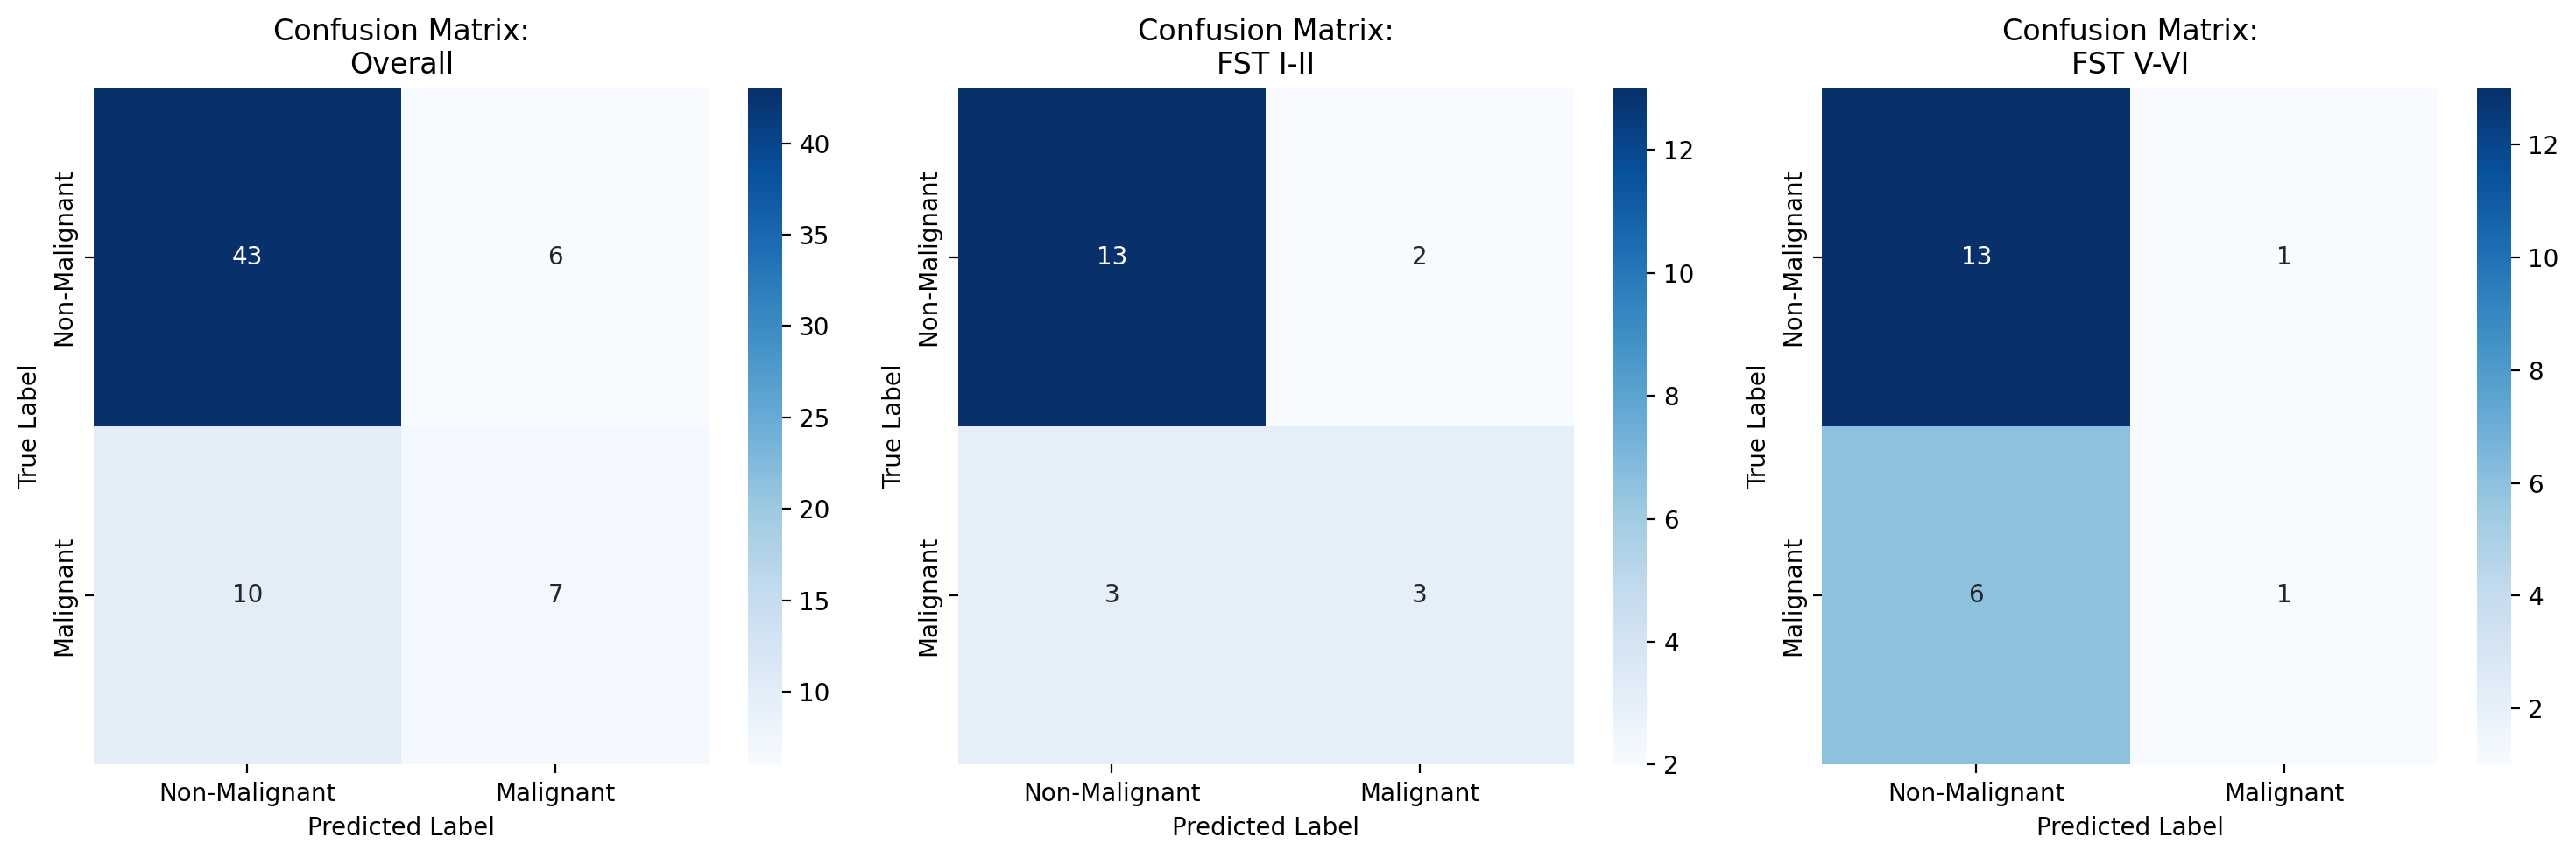

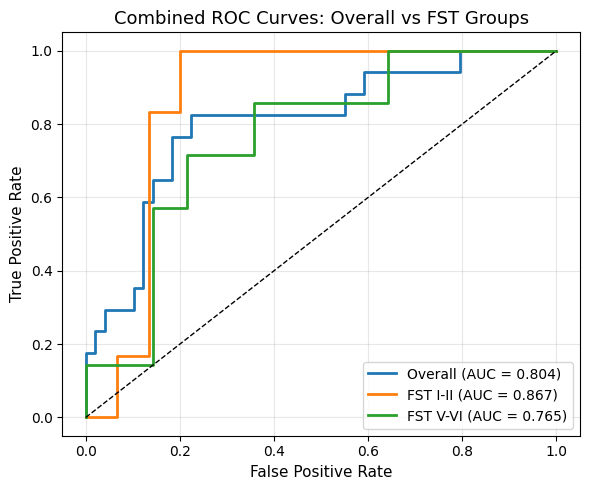

In [632]:
#Calculate and plot the ROC using the function
dino_v2_small_overall_metrics, dino_v2_small_overall_fst_metrics = evaluate_logistic_regression_fst(
    model_small_LP,
    ddi_dinov2_small_test_features_LP, ddi_dinov2_small_test_labels_LP,
    ddi_X_test,
    fst_column_name = "fst_group")

#### LINEAR PROBING OF DINO V2 BASE

In [651]:

# Extract features for the training data
print("Extracting features for DDI data:")
ddi_dinov2_base_train_features_LP, ddi_dinov2_base_train_labels_LP = extract_features_DinoV2(dino_v2_base, ddi_dataloader_train_LP, device)
print(f"DDI features shape: {ddi_dinov2_base_train_features_LP.shape}, DDI labels shape: {ddi_dinov2_base_train_labels_LP.shape}")

# Extract features for the test data
print("Extracting features for DDI data:")
ddi_dinov2_base_test_features_LP, ddi_dinov2_base_test_labels_LP = extract_features_DinoV2(dino_v2_base, ddi_dataloader_test_LP, device)
print(f"DDI features shape: {ddi_dinov2_base_test_features_LP.shape}, DDI labels shape: {ddi_dinov2_base_test_labels_LP.shape}")


Extracting features for DDI data:

Feature extraction complete. Extracted features shape: (590, 768)
Extracted labels shape: (590,)
DDI features shape: (590, 768), DDI labels shape: (590,)
Extracting features for DDI data:

Feature extraction complete. Extracted features shape: (590, 768)
Extracted labels shape: (590,)
DDI features shape: (590, 768), DDI labels shape: (590,)
Extracting features for DDI data:

Feature extraction complete. Extracted features shape: (66, 768)
Extracted labels shape: (66,)
DDI features shape: (66, 768), DDI labels shape: (66,)

Feature extraction complete. Extracted features shape: (66, 768)
Extracted labels shape: (66,)
DDI features shape: (66, 768), DDI labels shape: (66,)


In [ ]:
# Fit a new Logistic Regression model on this fold
model_base_Lp = train_logistic_regression_model(ddi_dinov2_base_train_features_LP, ddi_dinov2_base_train_labels_LP)

Embedding dimension (M): 768
Number of classes (C_classes): 2
Calculated lambda (MC/100): 15.3600
Calculated scikit-learn C parameter (1/lambda): 0.0651

Logistic Regression classifier trained on full training set.



Evaluating Logistic Regression model

--- Overall Metrics ---
  AUC: 0.7023
  Accuracy: 0.7424
  Precision (weighted): 0.7200
  Recall (weighted): 0.7424
  F1-score (weighted): 0.7265

Evaluating Selected FST Groups: I-II and V-VI

--- FST Group: I-II ---
Samples: 21
  AUC: 0.8148
  Accuracy: 0.8571
  Precision (weighted): 0.8782
  Recall (weighted): 0.8571
  F1-score (weighted): 0.8653

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.6122
  Accuracy: 0.6190
  Precision (weighted): 0.5917
  Recall (weighted): 0.6190
  F1-score (weighted): 0.6000


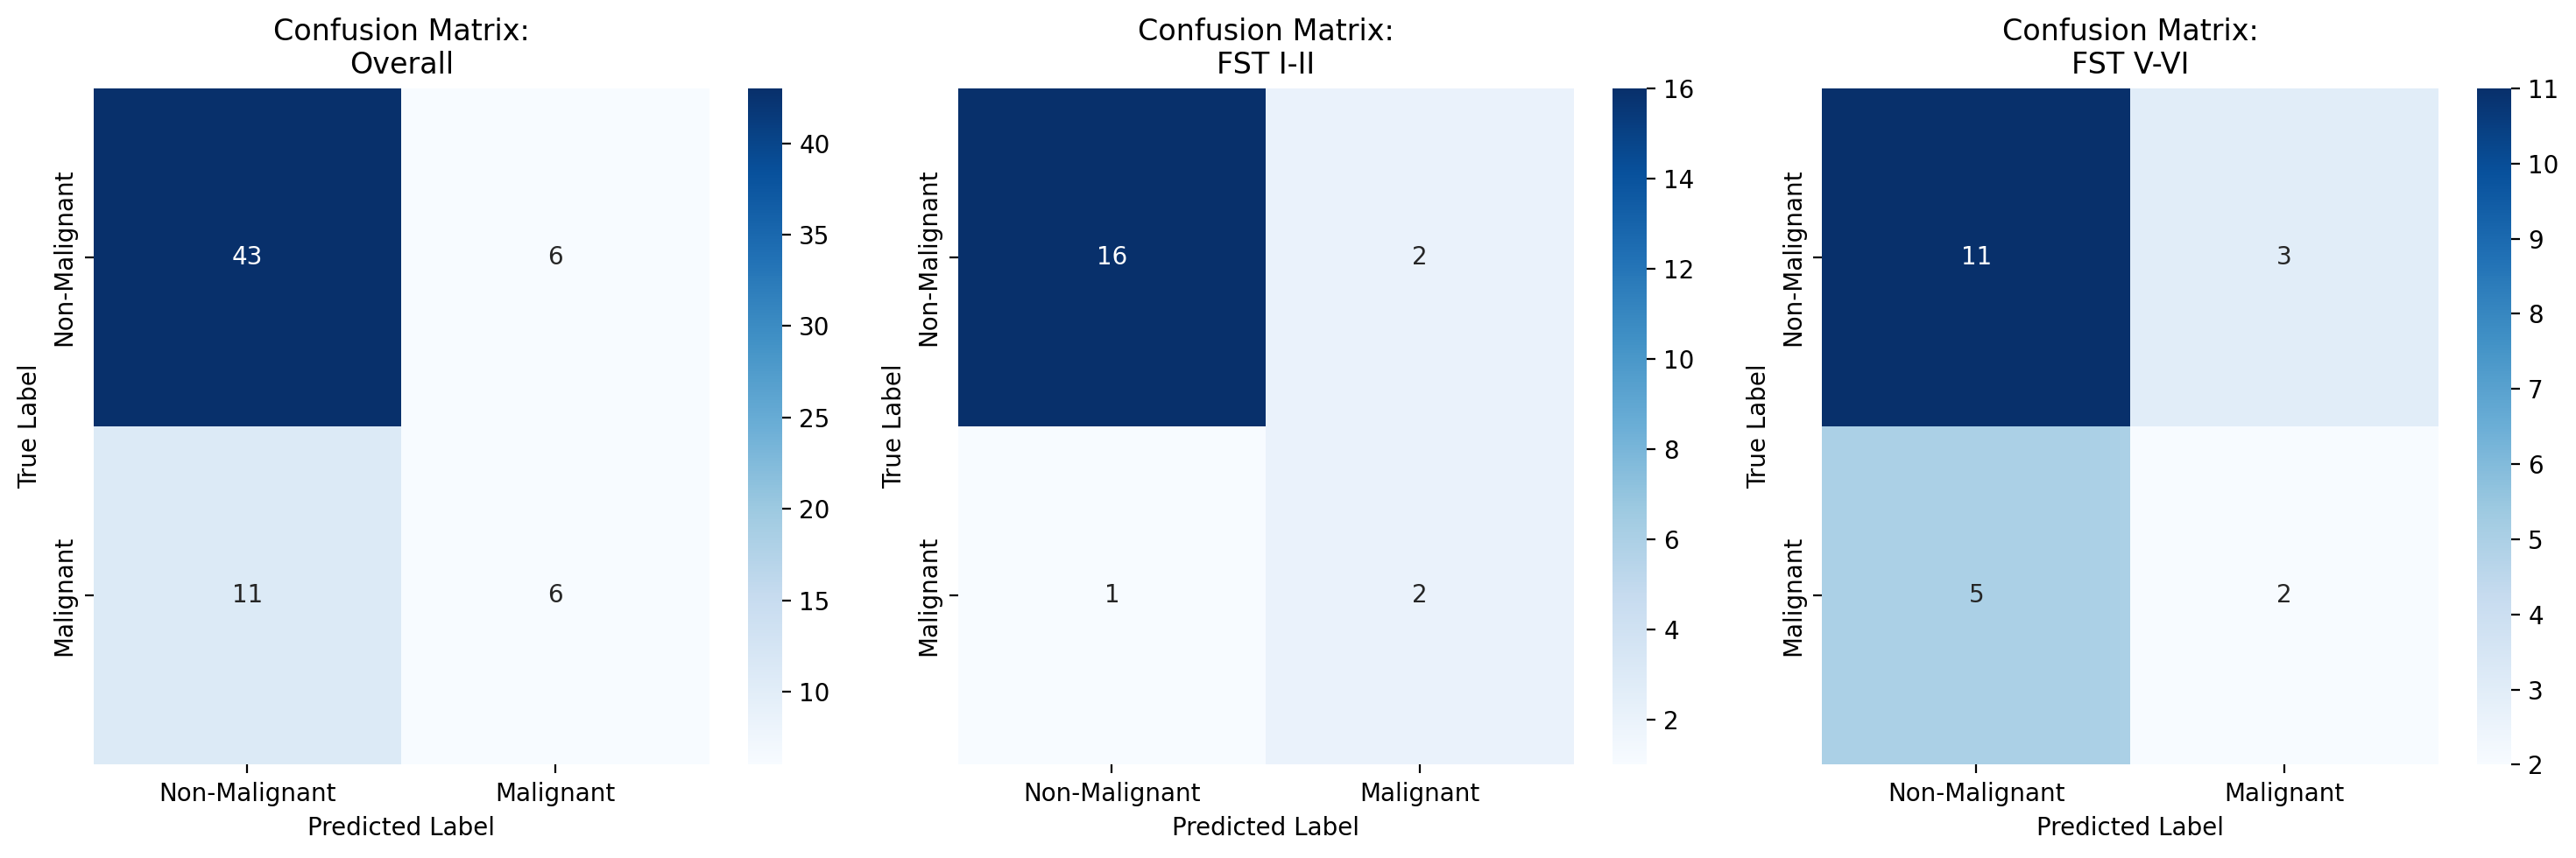

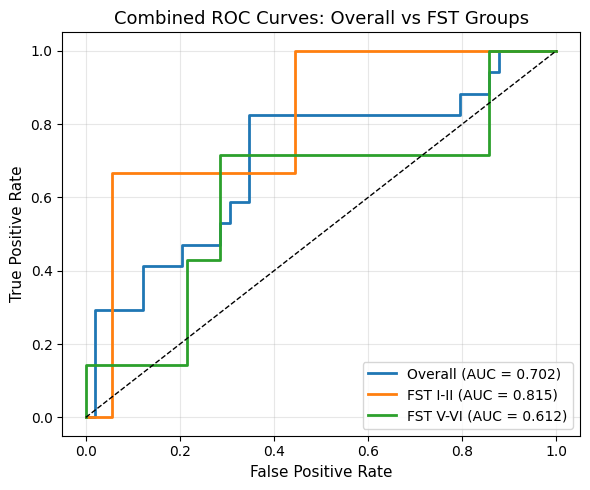

In [801]:
#Calculate and plot the ROC using the function
dino_v2_base_overall_metrics, dino_v2_base_overall_fst_metrics = evaluate_logistic_regression_fst(
    model_base_Lp,
    ddi_dinov2_base_test_features_LP, ddi_dinov2_base_test_labels_LP,
    ddi_X_test,
    fst_column_name = "fst_group")

#### LINEAR PROBING OF DINO V2 LARGE

In [ ]:

# Extract features for the training data
print("Extracting features for DDI data:")
ddi_dinov2_large_train_features_LP, ddi_dinov2_large_train_labels_LP = extract_features_DinoV2(dino_v2_large, ddi_dataloader_train_LP, device)
print(f"DDI features shape: {ddi_dinov2_large_train_features_LP.shape}, DDI labels shape: {ddi_dinov2_large_train_labels_LP.shape}")

# Extract features for the test data
print("Extracting features for DDI data:")
ddi_dinov2_large_test_features_LP, ddi_dinov2_large_test_labels_LP = extract_features_DinoV2(dino_v2_large, ddi_dataloader_test_LP, device)
print(f"DDI features shape: {ddi_dinov2_large_test_features_LP.shape}, DDI labels shape: {ddi_dinov2_large_test_labels_LP.shape}")


Extracting features for DDI data:

Feature extraction complete. Extracted features shape: (590, 1024)
Extracted labels shape: (590,)
DDI features shape: (590, 768), DDI labels shape: (590,)
Extracting features for DDI data:

Feature extraction complete. Extracted features shape: (590, 1024)
Extracted labels shape: (590,)
DDI features shape: (590, 768), DDI labels shape: (590,)
Extracting features for DDI data:

Feature extraction complete. Extracted features shape: (66, 1024)
Extracted labels shape: (66,)
DDI features shape: (66, 768), DDI labels shape: (66,)

Feature extraction complete. Extracted features shape: (66, 1024)
Extracted labels shape: (66,)
DDI features shape: (66, 768), DDI labels shape: (66,)


In [741]:
# Fit a new Logistic Regression model on this fold
model_large_Lp = train_logistic_regression_model(ddi_dinov2_large_train_features_LP, ddi_dinov2_large_train_labels_LP)

Embedding dimension (M): 1024
Number of classes (C_classes): 2
Calculated lambda (MC/100): 20.4800
Calculated scikit-learn C parameter (1/lambda): 0.0488

Logistic Regression classifier trained on full training set.



Evaluating Logistic Regression model

--- Overall Metrics ---
  AUC: 0.8331
  Accuracy: 0.8182
  Precision (weighted): 0.8087
  Recall (weighted): 0.8182
  F1-score (weighted): 0.8096

Evaluating Selected FST Groups: I-II and V-VI

--- FST Group: I-II ---
Samples: 21
  AUC: 0.9559
  Accuracy: 0.9524
  Precision (weighted): 0.9550
  Recall (weighted): 0.9524
  F1-score (weighted): 0.9497

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.9222
  Accuracy: 0.8095
  Precision (weighted): 0.8025
  Recall (weighted): 0.8095
  F1-score (weighted): 0.7964


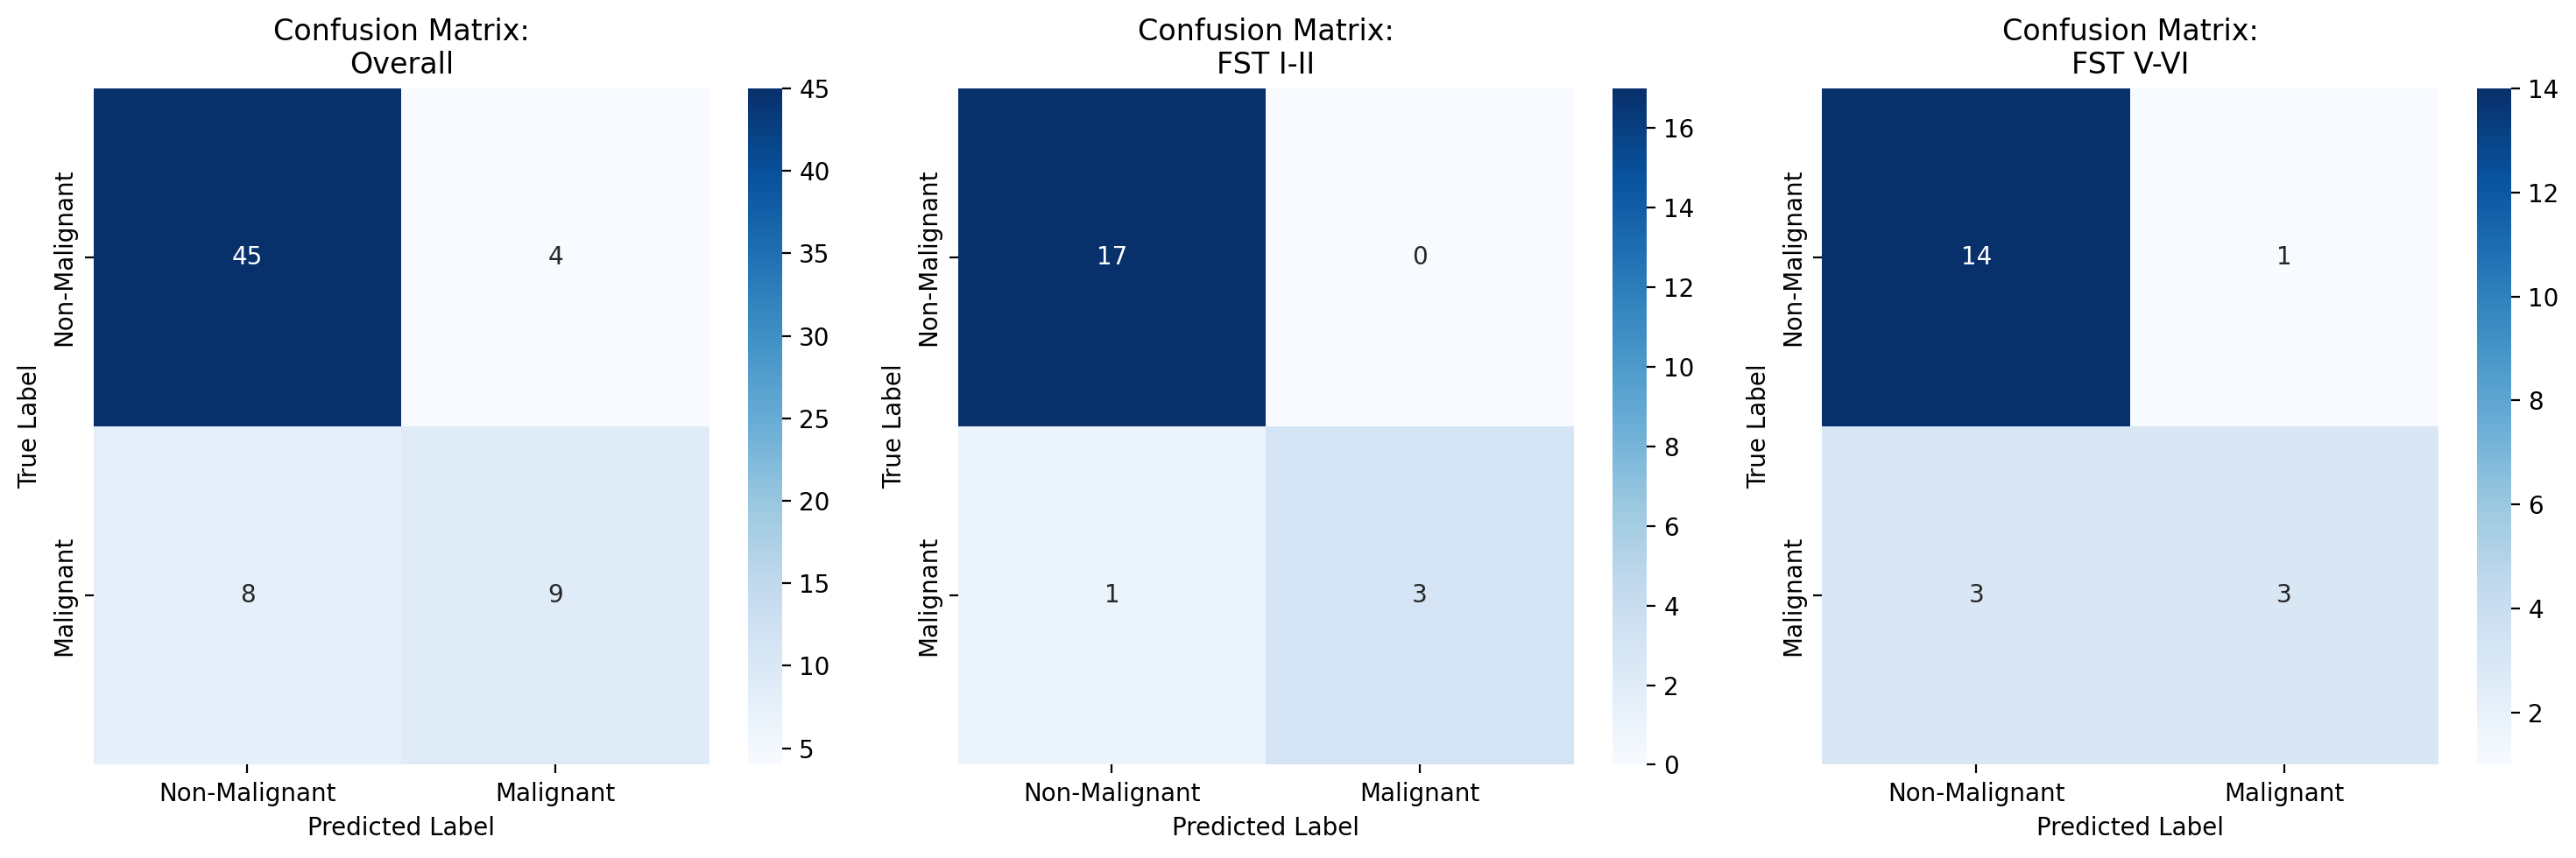

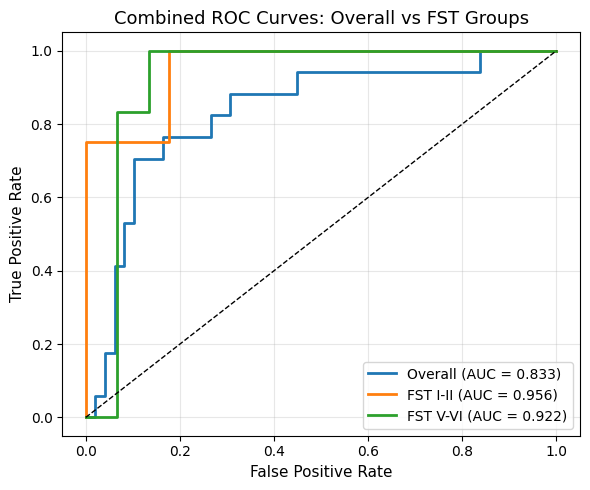

In [742]:
#Calculate and plot the ROC using the function
dino_v2_base_overall_metrics, dino_v2_base_overall_fst_metrics = evaluate_logistic_regression_fst(
    model_large_Lp,
    ddi_dinov2_large_test_features_LP, ddi_dinov2_large_test_labels_LP,
    ddi_X_test,
    fst_column_name = "fst_group")

##### Observations:

The linear probe results reveal clear evidence of inherent algorithmic bias in the pretrained DINOv2 representations prior to task-specific adaptation. Although the linear probe achieves strong overall performance especially in the large variants, particularly in terms of AUC; however, this performance is unevenly distributed across Fitzpatrick skin tone subgroups. In particular, substantially higher AUC and recall are observed for lighter skin tones (FST I–II) compared to darker skin tones (FST V–VI), resulting in large fairness gaps for both metrics. These disparities are most pronounced for the DINOv2-Base model. This behaviour suggests that the pretrained representations encode biases likely arising from imbalances in the pretraining data, which are then exposed when only a linear classifier is trained. As such, the linear probe serves as an important diagnostic baseline, highlighting that strong aggregate performance can mask clinically significant subgroup-level deficiencies. These findings motivate the application of Low Rank Adaptation, to explicitly address and correct these representation-level disparities in a fairness-aware and computationally efficient manner.

## LOW RANK ADAPTATION OF THE MODELS
In this section, we fine-tune multiple variants of the DINOv2 Vision Transformer using Low-Rank Adaptation (LoRA). LoRA enables parameter-efficient fine-tuning by injecting small, trainable low-rank matrices into selected layers of a pretrained model while keeping the backbone weights frozen. We apply the same training and evaluation pipeline across all model variants to ensure consistency, varying only the rank of the LoRA adapters (8, 16, and 32) to study the effect of adaptation capacity. By doing so, we analyse how different LoRA ranks influence overall performance, fairness across Fitzpatrick skin tone subgroups, and computational efficiency, while maintaining a lightweight fine-tuning setup suitable for medical imaging applications.

Functions to train, and evaluate LoRA models. 

In [1048]:

#Function to mix image features along with the labels


def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

# function to train model
def train_peft_model(
        model, train_dataloader, 
        val_dataloader, optimizer, 
        criterion, scheduler, 
        device, num_epochs=5, 
        early_stopping_patience=4,
        mix_up = False, mixup_alpha = 0.1, 
        early_stopping_metric='loss', min_delta=0.001):
    model.train()
    print(f"Starting training for up to {num_epochs} epochs on {device}...")
    print(f"Early stopping: Metric={early_stopping_metric}, Patience={early_stopping_patience}, Min_delta={min_delta}\n")
    
    # Initialize tracking lists
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_aucs = []
    epoch_times = []
    num_epochs_actual = 0
    
    # Early stopping parameters
    best_metric_value = None
    patience_counter = 0
    best_epoch = 0
    best_model_state = None
    training_history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        num_epochs_actual += num_epochs_actual
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        epoch_start_time = time.time()
        running_loss = 0.0
        model.train()

        train_progress_bar = tqdm(train_dataloader, desc=f"  Training Epoch {epoch+1}")

        for i, (images, labels) in enumerate(train_progress_bar):
            images = images.to(device)
            labels = labels.to(device)

            if mix_up:
                    images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=mixup_alpha)

                    logits = model(pixel_values=images).logits
                    loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)
            else:
                    logits = model(pixel_values=images).logits
                    loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            train_progress_bar.set_postfix({'loss': running_loss / (i + 1)})

        epoch_loss = running_loss / len(train_dataloader)
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        train_losses.append(epoch_loss)
        
        print(f"  End of Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Time: {epoch_time:.2f}s")

        # Evaluate on validation set
        print(f"  Evaluating on Validation set...")
        val_accuracy, val_precision, val_recall, val_f1, val_auc, val_inference_time, val_avg_inference_time = evaluate_peft_model(model, val_dataloader, device)
        val_accuracies.append(val_accuracy)
        val_aucs.append(val_auc)
        
        # Calculate validation loss
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                logits = model(pixel_values=images).logits
                loss = criterion(logits, labels)
                val_running_loss += loss.item()
        val_loss = val_running_loss / len(val_dataloader)
        val_losses.append(val_loss)
        
        # Store metrics in history
        training_history['epoch'].append(epoch + 1)
        training_history['train_loss'].append(epoch_loss)
        training_history['val_loss'].append(val_loss)
        training_history['val_auc'].append(val_auc)
        training_history['val_acc'].append(val_accuracy)
        
        print(f"\n ----- Validation Metrics (Epoch {epoch+1}) ----- ")
        print(f"Train Loss:    {epoch_loss:.4f}")
        print(f"Val Loss:      {val_loss:.4f}")
        print(f"Val Accuracy:  {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}")
        print(f"Val Recall:    {val_recall:.4f}")
        print(f"Val F1-score:  {val_f1:.4f}")
        print(f"Val AUC:       {val_auc:.4f}" )
        print(f"Inference time: {val_inference_time:.4f}s | Avg per image: {val_avg_inference_time}s")

        # Early Stopping Logic
        if early_stopping_metric == 'auc':
            current_metric = val_auc
            improved = current_metric > best_metric_value + min_delta if best_metric_value is not None else True
        else:  # val_loss
            current_metric = val_loss
            improved = current_metric < best_metric_value - min_delta if best_metric_value is not None else True

        if best_metric_value is None:
            best_metric_value = current_metric
            best_epoch = epoch + 1
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"Baseline set: {early_stopping_metric}={current_metric:.4f}")
        elif improved:
            best_metric_value = current_metric
            patience_counter = 0
            best_epoch = epoch + 1
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"Improved: {early_stopping_metric}={current_metric:.4f} (best so far)")
        else:
            patience_counter += 1
            print(f"No improvement: {early_stopping_metric}={current_metric:.4f} | Patience: {patience_counter}/{early_stopping_patience}")
            
            if patience_counter >= early_stopping_patience:
                print(f"\n EARLY STOPPING TRIGGERED!")
                print(f"   Best {early_stopping_metric}={best_metric_value:.4f} at Epoch {best_epoch}")
                print(f"   No improvement for {early_stopping_patience} consecutive epochs\n")
                
                # Restore best model state
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                    print(f"   Model restored to best state (Epoch {best_epoch})\n")
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"   Model restored to best state (Epoch {best_epoch})\n")

    # Plot training curves
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=300)
    
    # Loss curve
    axes[0].plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Training Loss')
    axes[0].plot(range(1, len(val_losses)+1), val_losses, 'r-o', label='Validation Loss')
    axes[0].plot(range(1, len(val_aucs)+1), val_aucs, 'g-o', label='Validation Auc')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss per Epoch')
    axes[0].grid(True)
    axes[0].legend()
    
    # Validation accuracy curve
    axes[1].plot(range(1, len(val_accuracies)+1), val_accuracies, 'g-o', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Validation Accuracy per Epoch')
    axes[1].grid(True)
    axes[1].legend()
    
    # Training time per epoch
    axes[2].bar(range(1, len(epoch_times)+1), epoch_times, color='r', alpha=0.7)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Time (seconds)')
    axes[2].set_title('Training Time per Epoch')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal training time: {sum(epoch_times):.2f}s")
    return training_history

#Function to Evaluate the model
def evaluate_peft_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = [] # Collect probabilities for AUC

    start_time = time.time() # Start timing

    with torch.no_grad(): # Disable gradient calculation for inference
         for images, labels in tqdm(dataloader, desc="  Evaluating Model"):
              images = images.to(device)
              labels = labels.to(device)

              # Ensure labels have the correct shape (batch_size,)
              if labels.ndim > 1:
                  labels = labels.squeeze() # Remove dimensions of size 1

              logits = model(pixel_values=images).logits

              # Get predicted class
              _, predicted = torch.max(logits, 1)

              # Get probabilities for AUC - assuming binary classification and logits shape (batch_size, 2)
              if logits.shape[1] >= 2:
                  probs = torch.softmax(logits, dim=1)[:, 1] # Probability of positive class (1)
              else:
                   probs = torch.full((logits.shape[0],), np.nan, device=device) # Fill with NaN if no probability

              all_labels.extend(labels.cpu().numpy()) # Move labels to CPU before converting to numpy
              all_predictions.extend(predicted.cpu().numpy())
              all_probs.extend(probs.cpu().numpy()) # Move probabilities to CPU before converting to numpy

    end_time = time.time() # End timing
    inference_time = end_time - start_time # Total inference time

    eval_labels = np.array(all_labels)
    eval_predictions = np.array(all_predictions)
    eval_probs = np.array(all_probs)

    accuracy = accuracy_score(eval_labels, eval_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(eval_labels, eval_predictions, average='weighted', zero_division=0)

    # Calculate AUC 
    auroc = np.nan
    if eval_probs is not None and not np.isnan(eval_probs).any() and len(np.unique(eval_labels)) >= 2:
        try:
            auroc = roc_auc_score(eval_labels, eval_probs)
        except ValueError as e:
             print(f"Could not calculate AUC: {e}")
    else:
         print("Cannot calculate AUC: Need predicted probabilities and at least 2 unique true labels.")

    if len(eval_labels) > 0:
        avg_inference_time = round((inference_time / len(eval_labels)), 5)
    else:
        avg_inference_time = 0

    return accuracy, precision, recall, f1, auroc, inference_time, avg_inference_time


def train_peft_pipeline(
    model_name: str,
    lora_config,
    train_df,
    train_dataloader,
    val_dataloader,
    checkpoint_dir: str,
    label_col: str = "malignant",
    lr: float = 5e-5,
    epochs: int = 15,
    batch_size: int = 32,
    early_stopping_patience: int = 5,
    mix_up = True,
    device = device
):
    

    #load base model a
    print(f"\nLoading pre-trained model: {model_name}")
    base_model = AutoModelForImageClassification.from_pretrained(model_name)
    print("Model loaded successfully.")
    
    #merge base model and the low rank adapters
    peft_model = get_peft_model(base_model, lora_config)
    peft_model.print_trainable_parameters()

    peft_model.to(device)
    print("PEFT model moved to device.")

    optimizer = AdamW(peft_model.parameters(), lr=lr)
    print("Optimizer (AdamW) defined.")

    # Class weights based on label distribution in training data
    class_counts = np.bincount(train_df[label_col].astype(int))
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_weights)

    criterion = CrossEntropyLoss(
        weight=torch.tensor(class_weights, dtype=torch.float32, device=device)
    )

    num_steps_per_epoch = math.ceil(len(train_dataloader))
    max_steps = num_steps_per_epoch * epochs
    warmup_steps = int(max_steps * 0.05)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=max_steps
    )

    print(f"Learning rate scheduler defined with {max_steps} total iterations.")
    print(f"Training for {epochs} epochs, batch_size={batch_size}, lr={lr}")

    #Train the model

    training_history = train_peft_model(
        peft_model,
        train_dataloader,
        val_dataloader,
        optimizer,
        criterion,
        scheduler,
        device,
        num_epochs=epochs,
        mix_up=mix_up,
        early_stopping_patience=early_stopping_patience
    )

    print("\nTraining completed.")

    #save Low Rank Adapters
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"Ensured checkpoint directory exists: {checkpoint_dir}")

    try:
        peft_model.save_pretrained(checkpoint_dir)
        print(f"\nPEFT model checkpoint saved to: {checkpoint_dir}")
    except Exception as e:
        print(f"Error saving PEFT model checkpoint: {e}")

    return peft_model, training_history

#Evaluate model with plots based on fst groupings
def evaluate_peft_model_with_fst_group(model, dataloader, dataframe, device, fst_column_name='combined_fst'):

    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    # COLLECT PREDICTIONS
    start_time = time.time()
    print("Collecting predictions...")

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(pixel_values=images)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs

            preds = torch.argmax(logits, dim=1)

            if logits.size(1) == 2:
                probs = torch.softmax(logits, dim=1)[:, 1]
            else:
                probs = torch.sigmoid(logits).squeeze()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    total_time = time.time() - start_time

    labels = np.array(all_labels)
    preds = np.array(all_preds)
    probs = np.array(all_probs)

    # OVERALL METRICS
    overall_metrics = {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)[0],
        "recall": precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)[1],
        "f1": precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)[2],
        "auc": roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else np.nan,
        "inference_time": total_time/len(labels)
    }

    print("\n--- Overall Metrics ---")
    for k, v in overall_metrics.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    # FST GROUPS: ONLY I-II AND V-VI
    TARGET_GROUPS = ["I-II", "V-VI"]
    fst_metrics = {}

    # Attach FST labels to evaluation rows
    fst_values = dataframe[fst_column_name].iloc[:len(labels)].values
    eval_df = pd.DataFrame({
        "label": labels,
        "pred": preds,
        "prob": probs,
        fst_column_name: fst_values
    }).dropna(subset=[fst_column_name])

    # ROC plot dataset
    plot_data = [{
        "name": "Overall",
        "true_labels": labels,
        "predicted_labels": preds,
        "predicted_probs": probs,
        "metrics": overall_metrics
    }]

    print("\n--- FST Analysis (I-II and V-VI) ---")

    for group in TARGET_GROUPS:
        group_df = eval_df[eval_df[fst_column_name] == group]

        print(f"\n--- FST Group: {group} ---")
        print(f"Samples: {len(group_df)}")

        if len(group_df) == 0:
            fst_metrics[group] = {"accuracy": np.nan, "precision": np.nan, "recall": np.nan, "f1": np.nan, "auc": np.nan}
            continue

        g_true = group_df["label"].values
        g_pred = group_df["pred"].values
        g_prob = group_df["prob"].values

        precision, recall, f1, _ = precision_recall_fscore_support(g_true, g_pred, average="weighted", zero_division=0)

        auc_val = roc_auc_score(g_true, g_prob) if len(np.unique(g_true)) > 1 else np.nan
        accuracy = accuracy_score(g_true, g_pred)

        fst_metrics[group] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc_val
        }

        print(f"  AUC: {auc_val:.4f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision (weighted): {precision:.4f}")
        print(f"  Recall (weighted): {recall:.4f}")
        print(f"  F1-score (weighted): {f1:.4f}")

        plot_data.append({
            "name": f"FST {group}",
            "true_labels": g_true,
            "predicted_labels": g_pred,
            "predicted_probs": g_prob,
            "metrics": fst_metrics[group],
            "sample_count": len(group_df),
        })

    # CONFUSION MATRICES

    fig, axes = plt.subplots(1, len(plot_data), figsize=(5 * len(plot_data), 5))

    if len(plot_data) == 1:
        axes = [axes]

    for ax, d in zip(axes, plot_data):
        cm = confusion_matrix(d["true_labels"], d["predicted_labels"])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["Non-Malignant", "Malignant"],
                    yticklabels=["Non-Malignant", "Malignant"],
                    ax=ax)
        ax.set_title(d["name"])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    plt.tight_layout()
    plt.show()

    plot_combined_roc(plot_data)

    return overall_metrics, fst_metrics





### DATA LOADERS

In [261]:
# Define transformations with advanced augmentation
custom_train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Minimal transforms for validation/test (no augmentation)
custom_eval_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [1046]:
batch_size = 32

train_dataset = DDIDataset(
        dataframe=ddi_X_train, 
        img_dir=ddi_image_base_dir, 
        transform=custom_eval_transforms,
        processor=None
    )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = DDIDataset(
        dataframe=ddi_X_test, 
        img_dir=ddi_image_base_dir, 
        transform=custom_eval_transforms,
        processor=None
    )
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

val_dataset = DDIDataset(
        dataframe=ddi_X_val, 
        img_dir=ddi_image_base_dir, 
        transform=custom_eval_transforms,
        processor=None
    )
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
batch_size = 32

train_dataset = DDIDataset(
        dataframe=ddi_X_train, 
        img_dir=ddi_image_base_dir, 
        transform=custom_eval_transforms,
        processor=None
    )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = DDIDataset(
        dataframe=ddi_X_test, 
        img_dir=ddi_image_base_dir, 
        transform=custom_eval_transforms,
        processor=None
    )
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

val_dataset = DDIDataset(
        dataframe=ddi_X_val, 
        img_dir=ddi_image_base_dir, 
        transform=custom_eval_transforms,
        processor=None
    )
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#Pipeline function to evaluate finttuned models based on fst
def evaluate_peft_model_pipeline(model_name, checkpoint_dir):
    # Load the base model first
    base_model = AutoModelForImageClassification.from_pretrained(model_name)

    # Load the PEFT checkpoint
    model = PeftModel.from_pretrained(base_model, checkpoint_dir)
    model.eval()

    history, fst = evaluate_peft_model_with_fst_group(model.to(device)
    , test_dataloader, ddi_X_test, device, fst_column_name = "fst_group")

    return model, history, fst


LORA CONFIGURATION 

In [ ]:
# Update LoRA configuration parameters to target the correct module names
lora_config_8 = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["query","key","value","output.dense"],  # Target the Multihead Attention block
    bias="none",
    task_type="SEQ_CLS",
    init_lora_weights = True #weight initialization following the original study
)

# Update LoRA configuration parameters to target the correct module names
lora_config_16 = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query","key","value","output.dense"],  # MSA
    bias="none",
    task_type="SEQ_CLS",
    init_lora_weights = True #weight initialization following the original study
)

# Update LoRA configuration parameters to target the correct module names
lora_config_32 = LoraConfig(
    r=32,
    lora_alpha=64,
    lora_dropout=0.05,
    target_modules=["query","key","value","output.dense"],  # Target the Multihead Attention block
    bias="none",
    task_type="SEQ_CLS",
    init_lora_weights = True #weight initialization following the original study
)

### RANK8

##### DINO V2 SMALL


Loading pre-trained model: facebook/dinov2-small


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.
trainable params: 296,450 || all params: 22,354,564 || trainable%: 1.3261
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20


  Training Epoch 1: 100%|██████████| 17/17 [01:04<00:00,  3.80s/it, loss=0.799]


  End of Epoch 1 | Train Loss: 0.7988 | Time: 64.65s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]




 ----- Validation Metrics (Epoch 1) ----- 
Train Loss:    0.7988
Val Loss:      0.7639
Val Accuracy:  0.7458
Val Precision: 0.7161
Val Recall:    0.7458
Val F1-score:  0.6936
Val AUC:       0.6032
Inference time: 2.0177s | Avg per image: 0.0342s
Baseline set: loss=0.7639

Epoch 2/20


  Training Epoch 2: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it, loss=0.682]


  End of Epoch 2 | Train Loss: 0.6819 | Time: 55.28s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]




 ----- Validation Metrics (Epoch 2) ----- 
Train Loss:    0.6819
Val Loss:      0.6274
Val Accuracy:  0.6610
Val Precision: 0.7510
Val Recall:    0.6610
Val F1-score:  0.6798
Val AUC:       0.7151
Inference time: 2.3797s | Avg per image: 0.04033s
Improved: loss=0.6274 (best so far)

Epoch 3/20


  Training Epoch 3: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it, loss=0.636]


  End of Epoch 3 | Train Loss: 0.6361 | Time: 53.49s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]




 ----- Validation Metrics (Epoch 3) ----- 
Train Loss:    0.6361
Val Loss:      0.6069
Val Accuracy:  0.7458
Val Precision: 0.7322
Val Recall:    0.7458
Val F1-score:  0.7369
Val AUC:       0.7456
Inference time: 2.3604s | Avg per image: 0.04001s
Improved: loss=0.6069 (best so far)

Epoch 4/20


  Training Epoch 4: 100%|██████████| 17/17 [01:00<00:00,  3.58s/it, loss=0.586]


  End of Epoch 4 | Train Loss: 0.5859 | Time: 60.90s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]




 ----- Validation Metrics (Epoch 4) ----- 
Train Loss:    0.5859
Val Loss:      0.5870
Val Accuracy:  0.7119
Val Precision: 0.7429
Val Recall:    0.7119
Val F1-score:  0.7224
Val AUC:       0.7573
Inference time: 2.2349s | Avg per image: 0.03788s
Improved: loss=0.5870 (best so far)

Epoch 5/20


  Training Epoch 5: 100%|██████████| 17/17 [01:00<00:00,  3.55s/it, loss=0.554]


  End of Epoch 5 | Train Loss: 0.5543 | Time: 60.33s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]




 ----- Validation Metrics (Epoch 5) ----- 
Train Loss:    0.5543
Val Loss:      0.5871
Val Accuracy:  0.7458
Val Precision: 0.7509
Val Recall:    0.7458
Val F1-score:  0.7481
Val AUC:       0.7820
Inference time: 2.2335s | Avg per image: 0.03786s
No improvement: loss=0.5871 | Patience: 1/5

Epoch 6/20


  Training Epoch 6: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it, loss=0.494]


  End of Epoch 6 | Train Loss: 0.4942 | Time: 59.21s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]




 ----- Validation Metrics (Epoch 6) ----- 
Train Loss:    0.4942
Val Loss:      0.5427
Val Accuracy:  0.7797
Val Precision: 0.7947
Val Recall:    0.7797
Val F1-score:  0.7851
Val AUC:       0.8038
Inference time: 2.0293s | Avg per image: 0.0344s
Improved: loss=0.5427 (best so far)

Epoch 7/20


  Training Epoch 7: 100%|██████████| 17/17 [00:59<00:00,  3.50s/it, loss=0.495]


  End of Epoch 7 | Train Loss: 0.4947 | Time: 59.50s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]




 ----- Validation Metrics (Epoch 7) ----- 
Train Loss:    0.4947
Val Loss:      0.5499
Val Accuracy:  0.7288
Val Precision: 0.7811
Val Recall:    0.7288
Val F1-score:  0.7420
Val AUC:       0.7820
Inference time: 2.2995s | Avg per image: 0.03897s
No improvement: loss=0.5499 | Patience: 1/5

Epoch 8/20


  Training Epoch 8: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it, loss=0.473]


  End of Epoch 8 | Train Loss: 0.4728 | Time: 58.40s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]




 ----- Validation Metrics (Epoch 8) ----- 
Train Loss:    0.4728
Val Loss:      0.5456
Val Accuracy:  0.7119
Val Precision: 0.7732
Val Recall:    0.7119
Val F1-score:  0.7266
Val AUC:       0.7951
Inference time: 1.9431s | Avg per image: 0.03293s
No improvement: loss=0.5456 | Patience: 2/5

Epoch 9/20


  Training Epoch 9: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it, loss=0.475]


  End of Epoch 9 | Train Loss: 0.4746 | Time: 48.43s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]




 ----- Validation Metrics (Epoch 9) ----- 
Train Loss:    0.4746
Val Loss:      0.5320
Val Accuracy:  0.7797
Val Precision: 0.7756
Val Recall:    0.7797
Val F1-score:  0.7774
Val AUC:       0.8372
Inference time: 1.9133s | Avg per image: 0.03243s
Improved: loss=0.5320 (best so far)

Epoch 10/20


  Training Epoch 10: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it, loss=0.423]


  End of Epoch 10 | Train Loss: 0.4227 | Time: 52.39s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]




 ----- Validation Metrics (Epoch 10) ----- 
Train Loss:    0.4227
Val Loss:      0.5314
Val Accuracy:  0.7627
Val Precision: 0.7627
Val Recall:    0.7627
Val F1-score:  0.7627
Val AUC:       0.8285
Inference time: 2.0286s | Avg per image: 0.03438s
No improvement: loss=0.5314 | Patience: 1/5

Epoch 11/20


  Training Epoch 11: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it, loss=0.414]


  End of Epoch 11 | Train Loss: 0.4144 | Time: 51.95s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]




 ----- Validation Metrics (Epoch 11) ----- 
Train Loss:    0.4144
Val Loss:      0.5040
Val Accuracy:  0.7797
Val Precision: 0.7756
Val Recall:    0.7797
Val F1-score:  0.7774
Val AUC:       0.8401
Inference time: 1.9044s | Avg per image: 0.03228s
Improved: loss=0.5040 (best so far)

Epoch 12/20


  Training Epoch 12: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it, loss=0.416]


  End of Epoch 12 | Train Loss: 0.4163 | Time: 54.30s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]




 ----- Validation Metrics (Epoch 12) ----- 
Train Loss:    0.4163
Val Loss:      0.4968
Val Accuracy:  0.7627
Val Precision: 0.7627
Val Recall:    0.7627
Val F1-score:  0.7627
Val AUC:       0.8387
Inference time: 1.9425s | Avg per image: 0.03292s
Improved: loss=0.4968 (best so far)

Epoch 13/20


  Training Epoch 13: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it, loss=0.413]


  End of Epoch 13 | Train Loss: 0.4130 | Time: 52.97s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]




 ----- Validation Metrics (Epoch 13) ----- 
Train Loss:    0.4130
Val Loss:      0.5116
Val Accuracy:  0.7627
Val Precision: 0.7627
Val Recall:    0.7627
Val F1-score:  0.7627
Val AUC:       0.8358
Inference time: 1.9383s | Avg per image: 0.03285s
No improvement: loss=0.5116 | Patience: 1/5

Epoch 14/20


  Training Epoch 14: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it, loss=0.375]


  End of Epoch 14 | Train Loss: 0.3748 | Time: 52.39s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]




 ----- Validation Metrics (Epoch 14) ----- 
Train Loss:    0.3748
Val Loss:      0.5227
Val Accuracy:  0.7797
Val Precision: 0.7756
Val Recall:    0.7797
Val F1-score:  0.7774
Val AUC:       0.8358
Inference time: 1.9773s | Avg per image: 0.03351s
No improvement: loss=0.5227 | Patience: 2/5

Epoch 15/20


  Training Epoch 15: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it, loss=0.389]


  End of Epoch 15 | Train Loss: 0.3885 | Time: 51.71s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]




 ----- Validation Metrics (Epoch 15) ----- 
Train Loss:    0.3885
Val Loss:      0.5247
Val Accuracy:  0.7797
Val Precision: 0.7842
Val Recall:    0.7797
Val F1-score:  0.7817
Val AUC:       0.8299
Inference time: 1.9359s | Avg per image: 0.03281s
No improvement: loss=0.5247 | Patience: 3/5

Epoch 16/20


  Training Epoch 16: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it, loss=0.347]


  End of Epoch 16 | Train Loss: 0.3467 | Time: 51.38s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]




 ----- Validation Metrics (Epoch 16) ----- 
Train Loss:    0.3467
Val Loss:      0.5300
Val Accuracy:  0.7797
Val Precision: 0.7842
Val Recall:    0.7797
Val F1-score:  0.7817
Val AUC:       0.8241
Inference time: 1.8010s | Avg per image: 0.03053s
No improvement: loss=0.5300 | Patience: 4/5

Epoch 17/20


  Training Epoch 17: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it, loss=0.335]


  End of Epoch 17 | Train Loss: 0.3353 | Time: 53.16s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]




 ----- Validation Metrics (Epoch 17) ----- 
Train Loss:    0.3353
Val Loss:      0.5287
Val Accuracy:  0.7797
Val Precision: 0.7842
Val Recall:    0.7797
Val F1-score:  0.7817
Val AUC:       0.8270
Inference time: 2.0045s | Avg per image: 0.03397s
No improvement: loss=0.5287 | Patience: 5/5

 EARLY STOPPING TRIGGERED!
   Best loss=0.4968 at Epoch 12
   No improvement for 5 consecutive epochs

   Model restored to best state (Epoch 12)

   Model restored to best state (Epoch 12)



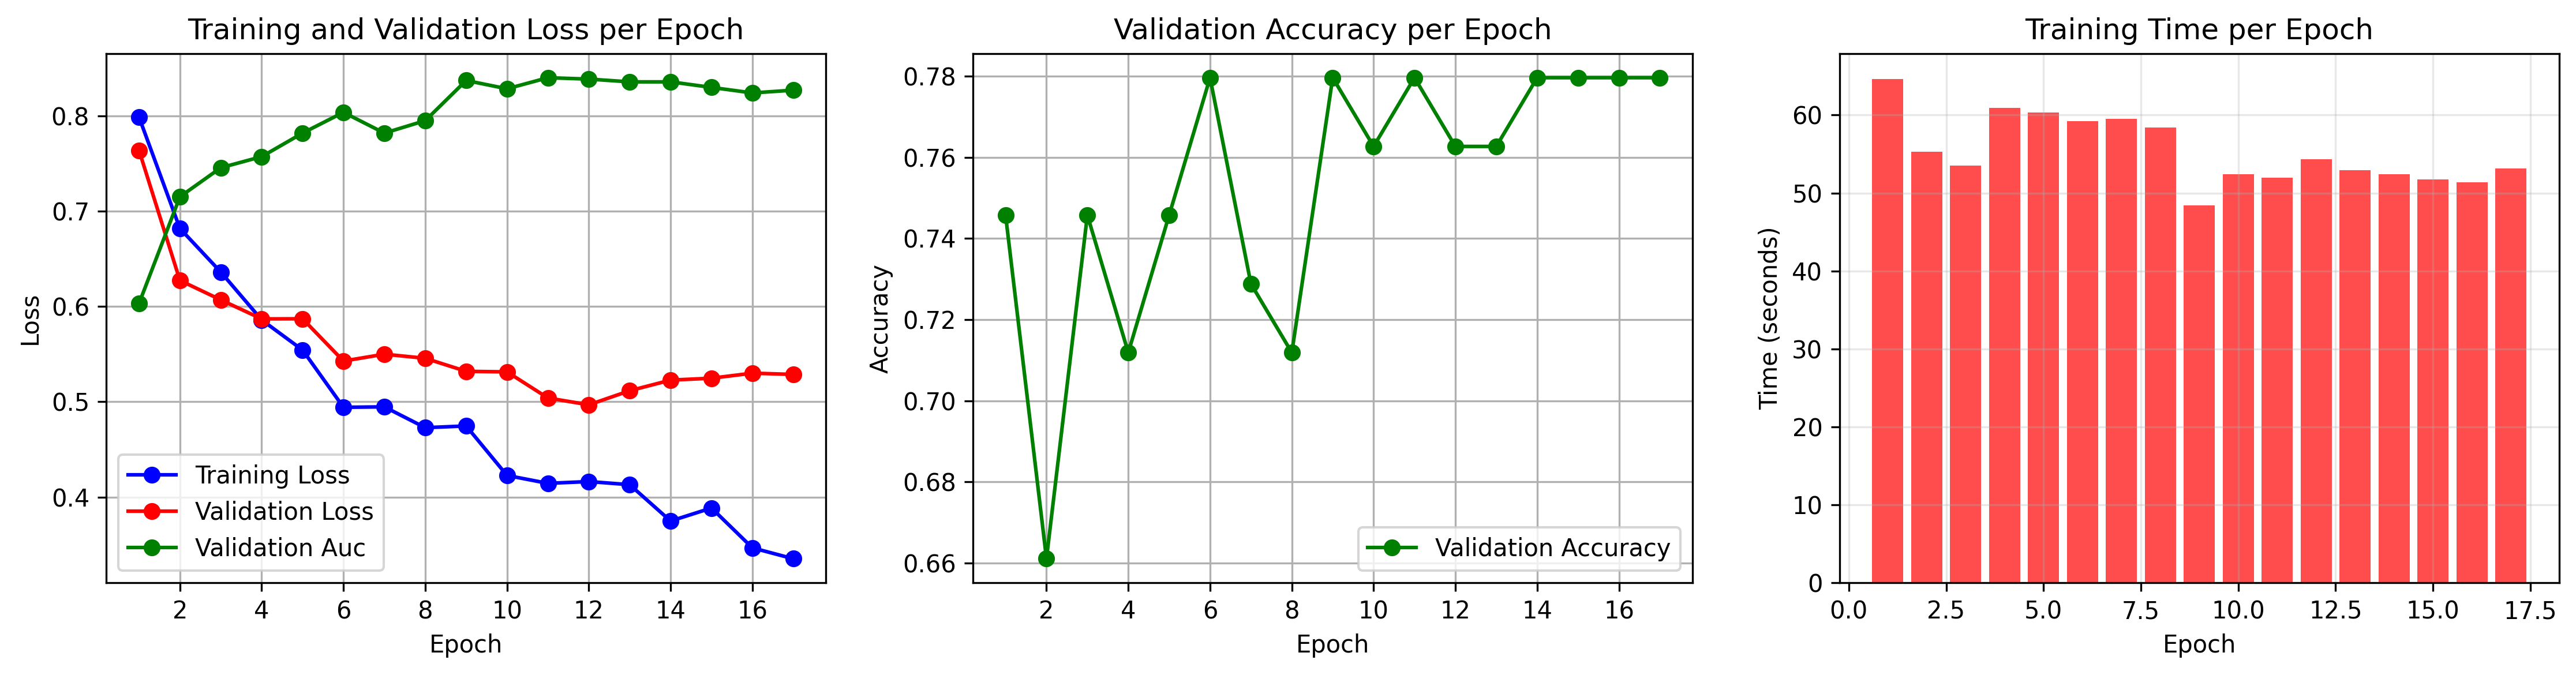


Total training time: 940.44s

Training completed.
Ensured checkpoint directory exists: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l8_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l8_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l8_mixup


In [ ]:

checkpoint = BASE_DIR / "models/checkpoints_main/PEFT_dino_small_l8_mixup"

dino_v2_small_l8_mix, history = train_peft_pipeline(
    model_name="facebook/dinov2-small",
    lora_config=lora_config_8,
    train_df=ddi_X_train,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    checkpoint_dir=checkpoint,
    label_col="malignant",
    lr=1e-4,
    epochs=20,
    batch_size=32,
    mix_up=True,
    early_stopping_patience=5,
    device=device
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


--- Overall Metrics ---
accuracy: 0.7273
precision: 0.7620
recall: 0.7273
f1: 0.7388
auc: 0.7695
inference_time: 0.0691

--- FST Analysis (I-II and V-VI) ---

--- FST Group: I-II ---
Samples: 21
  AUC: 0.6875
  Accuracy: 0.6190
  Precision (weighted): 0.7143
  Recall (weighted): 0.6190
  F1-score (weighted): 0.6463

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.7000
  Accuracy: 0.7619
  Precision (weighted): 0.7794
  Recall (weighted): 0.7619
  F1-score (weighted): 0.7689


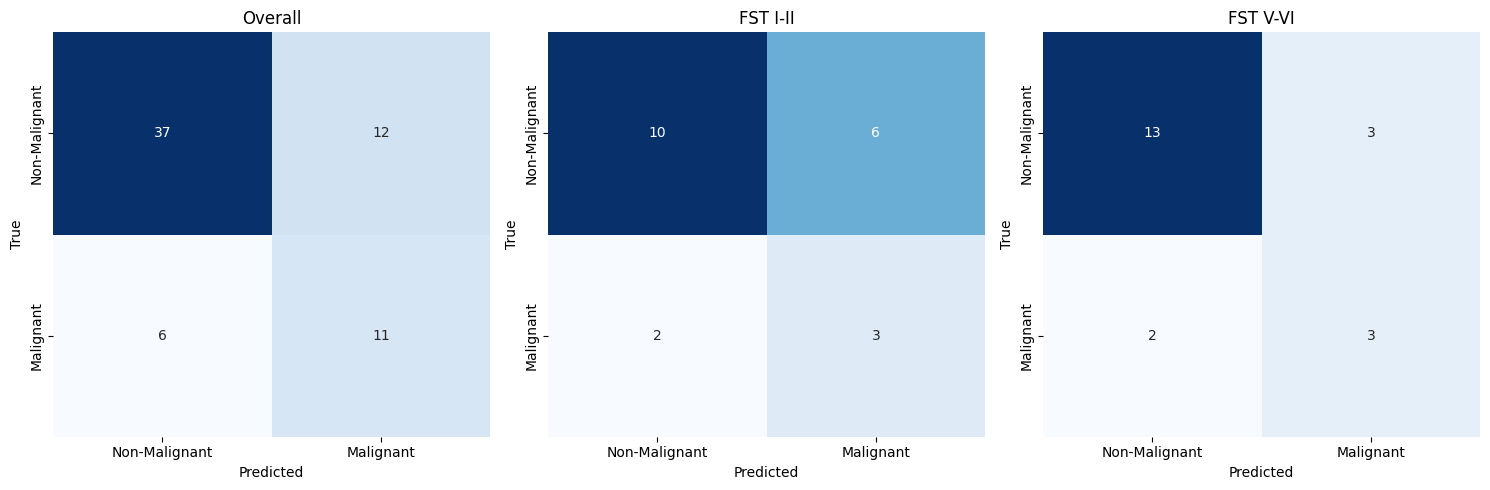

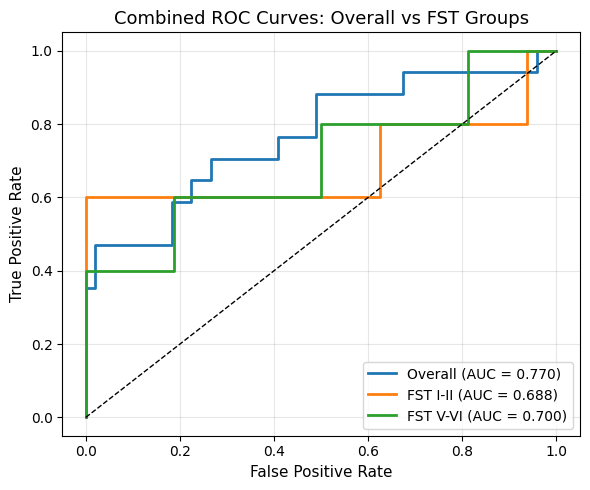

In [ ]:
# Load the PEFT model from checkpoint
checkpoint_dir = BASE_DIR / "models/checkpoints_main/PEFT_dino_small_l8_mixup"

dino_v2_small_l8_mix, dino_v2_small_l8_mix_history, dino_v2_small_l8_mix_fst = evaluate_peft_model_pipeline(
    model_name_small,
    checkpoint_dir)

#### DINOV2 BASE


Loading pre-trained model: facebook/dinov2-base


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b16d2d47-dc74-4774-9729-8629675e5dfd)')' thrown while requesting HEAD https://huggingface.co/facebook/dinov2-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Retrying in 1s [Retry 1/5].
Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/venv/lib/pyth

Model loaded successfully.
trainable params: 592,898 || all params: 87,176,452 || trainable%: 0.6801
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20


  Training Epoch 1: 100%|██████████| 17/17 [02:19<00:00,  8.21s/it, loss=0.729]


  End of Epoch 1 | Train Loss: 0.7286 | Time: 139.55s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]




 ----- Validation Metrics (Epoch 1) ----- 
Train Loss:    0.7286
Val Loss:      0.7172
Val Accuracy:  0.6271
Val Precision: 0.7178
Val Recall:    0.6271
Val F1-score:  0.6477
Val AUC:       0.6047
Inference time: 4.8786s | Avg per image: 0.08269s
Baseline set: loss=0.7172

Epoch 2/20


  Training Epoch 2: 100%|██████████| 17/17 [02:17<00:00,  8.07s/it, loss=0.664]


  End of Epoch 2 | Train Loss: 0.6641 | Time: 137.12s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]




 ----- Validation Metrics (Epoch 2) ----- 
Train Loss:    0.6641
Val Loss:      0.6716
Val Accuracy:  0.6610
Val Precision: 0.7019
Val Recall:    0.6610
Val F1-score:  0.6751
Val AUC:       0.6599
Inference time: 4.9637s | Avg per image: 0.08413s
Improved: loss=0.6716 (best so far)

Epoch 3/20


  Training Epoch 3: 100%|██████████| 17/17 [02:14<00:00,  7.93s/it, loss=0.606]


  End of Epoch 3 | Train Loss: 0.6064 | Time: 134.78s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]




 ----- Validation Metrics (Epoch 3) ----- 
Train Loss:    0.6064
Val Loss:      0.6351
Val Accuracy:  0.6780
Val Precision: 0.7253
Val Recall:    0.6780
Val F1-score:  0.6926
Val AUC:       0.7064
Inference time: 4.8962s | Avg per image: 0.08299s
Improved: loss=0.6351 (best so far)

Epoch 4/20


  Training Epoch 4: 100%|██████████| 17/17 [02:15<00:00,  7.94s/it, loss=0.554]


  End of Epoch 4 | Train Loss: 0.5537 | Time: 135.04s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.47s/it]




 ----- Validation Metrics (Epoch 4) ----- 
Train Loss:    0.5537
Val Loss:      0.6360
Val Accuracy:  0.7627
Val Precision: 0.7627
Val Recall:    0.7627
Val F1-score:  0.7627
Val AUC:       0.7297
Inference time: 4.9437s | Avg per image: 0.08379s
No improvement: loss=0.6360 | Patience: 1/5

Epoch 5/20


  Training Epoch 5: 100%|██████████| 17/17 [02:14<00:00,  7.91s/it, loss=0.526]


  End of Epoch 5 | Train Loss: 0.5261 | Time: 134.41s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]




 ----- Validation Metrics (Epoch 5) ----- 
Train Loss:    0.5261
Val Loss:      0.5801
Val Accuracy:  0.7119
Val Precision: 0.7732
Val Recall:    0.7119
Val F1-score:  0.7266
Val AUC:       0.7733
Inference time: 4.8302s | Avg per image: 0.08187s
Improved: loss=0.5801 (best so far)

Epoch 6/20


  Training Epoch 6: 100%|██████████| 17/17 [02:08<00:00,  7.57s/it, loss=0.498]


  End of Epoch 6 | Train Loss: 0.4985 | Time: 128.69s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]




 ----- Validation Metrics (Epoch 6) ----- 
Train Loss:    0.4985
Val Loss:      0.5686
Val Accuracy:  0.7288
Val Precision: 0.7982
Val Recall:    0.7288
Val F1-score:  0.7433
Val AUC:       0.7965
Inference time: 4.2329s | Avg per image: 0.07174s
Improved: loss=0.5686 (best so far)

Epoch 7/20


  Training Epoch 7: 100%|██████████| 17/17 [02:16<00:00,  8.03s/it, loss=0.469]


  End of Epoch 7 | Train Loss: 0.4687 | Time: 136.59s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]




 ----- Validation Metrics (Epoch 7) ----- 
Train Loss:    0.4687
Val Loss:      0.6008
Val Accuracy:  0.7458
Val Precision: 0.7622
Val Recall:    0.7458
Val F1-score:  0.7521
Val AUC:       0.7791
Inference time: 4.9160s | Avg per image: 0.08332s
No improvement: loss=0.6008 | Patience: 1/5

Epoch 8/20


  Training Epoch 8: 100%|██████████| 17/17 [02:15<00:00,  8.00s/it, loss=0.443]


  End of Epoch 8 | Train Loss: 0.4435 | Time: 135.99s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]




 ----- Validation Metrics (Epoch 8) ----- 
Train Loss:    0.4435
Val Loss:      0.5650
Val Accuracy:  0.7627
Val Precision: 0.8132
Val Recall:    0.7627
Val F1-score:  0.7743
Val AUC:       0.7863
Inference time: 4.9527s | Avg per image: 0.08394s
Improved: loss=0.5650 (best so far)

Epoch 9/20


  Training Epoch 9: 100%|██████████| 17/17 [02:16<00:00,  8.02s/it, loss=0.385]


  End of Epoch 9 | Train Loss: 0.3846 | Time: 136.36s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]




 ----- Validation Metrics (Epoch 9) ----- 
Train Loss:    0.3846
Val Loss:      0.5324
Val Accuracy:  0.7966
Val Precision: 0.8454
Val Recall:    0.7966
Val F1-score:  0.8065
Val AUC:       0.8140
Inference time: 5.0578s | Avg per image: 0.08573s
Improved: loss=0.5324 (best so far)

Epoch 10/20


  Training Epoch 10: 100%|██████████| 17/17 [02:19<00:00,  8.20s/it, loss=0.419]


  End of Epoch 10 | Train Loss: 0.4192 | Time: 139.45s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]




 ----- Validation Metrics (Epoch 10) ----- 
Train Loss:    0.4192
Val Loss:      0.5354
Val Accuracy:  0.7627
Val Precision: 0.8132
Val Recall:    0.7627
Val F1-score:  0.7743
Val AUC:       0.8067
Inference time: 5.7373s | Avg per image: 0.09724s
No improvement: loss=0.5354 | Patience: 1/5

Epoch 11/20


  Training Epoch 11: 100%|██████████| 17/17 [02:13<00:00,  7.84s/it, loss=0.357]


  End of Epoch 11 | Train Loss: 0.3570 | Time: 133.35s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]




 ----- Validation Metrics (Epoch 11) ----- 
Train Loss:    0.3570
Val Loss:      0.5609
Val Accuracy:  0.7627
Val Precision: 0.7728
Val Recall:    0.7627
Val F1-score:  0.7669
Val AUC:       0.8081
Inference time: 4.5165s | Avg per image: 0.07655s
No improvement: loss=0.5609 | Patience: 2/5

Epoch 12/20


  Training Epoch 12: 100%|██████████| 17/17 [02:16<00:00,  8.03s/it, loss=0.38] 


  End of Epoch 12 | Train Loss: 0.3805 | Time: 136.56s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]




 ----- Validation Metrics (Epoch 12) ----- 
Train Loss:    0.3805
Val Loss:      0.5677
Val Accuracy:  0.7966
Val Precision: 0.8168
Val Recall:    0.7966
Val F1-score:  0.8029
Val AUC:       0.7980
Inference time: 4.9667s | Avg per image: 0.08418s
No improvement: loss=0.5677 | Patience: 3/5

Epoch 13/20


  Training Epoch 13: 100%|██████████| 17/17 [02:15<00:00,  7.94s/it, loss=0.35] 


  End of Epoch 13 | Train Loss: 0.3495 | Time: 135.06s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]




 ----- Validation Metrics (Epoch 13) ----- 
Train Loss:    0.3495
Val Loss:      0.5398
Val Accuracy:  0.7458
Val Precision: 0.8055
Val Recall:    0.7458
Val F1-score:  0.7588
Val AUC:       0.8081
Inference time: 4.9739s | Avg per image: 0.0843s
No improvement: loss=0.5398 | Patience: 4/5

Epoch 14/20


  Training Epoch 14: 100%|██████████| 17/17 [02:15<00:00,  7.98s/it, loss=0.31] 


  End of Epoch 14 | Train Loss: 0.3095 | Time: 135.66s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]




 ----- Validation Metrics (Epoch 14) ----- 
Train Loss:    0.3095
Val Loss:      0.5638
Val Accuracy:  0.8136
Val Precision: 0.8272
Val Recall:    0.8136
Val F1-score:  0.8182
Val AUC:       0.8256
Inference time: 4.8917s | Avg per image: 0.08291s
No improvement: loss=0.5638 | Patience: 5/5

 EARLY STOPPING TRIGGERED!
   Best loss=0.5324 at Epoch 9
   No improvement for 5 consecutive epochs

   Model restored to best state (Epoch 9)

   Model restored to best state (Epoch 9)



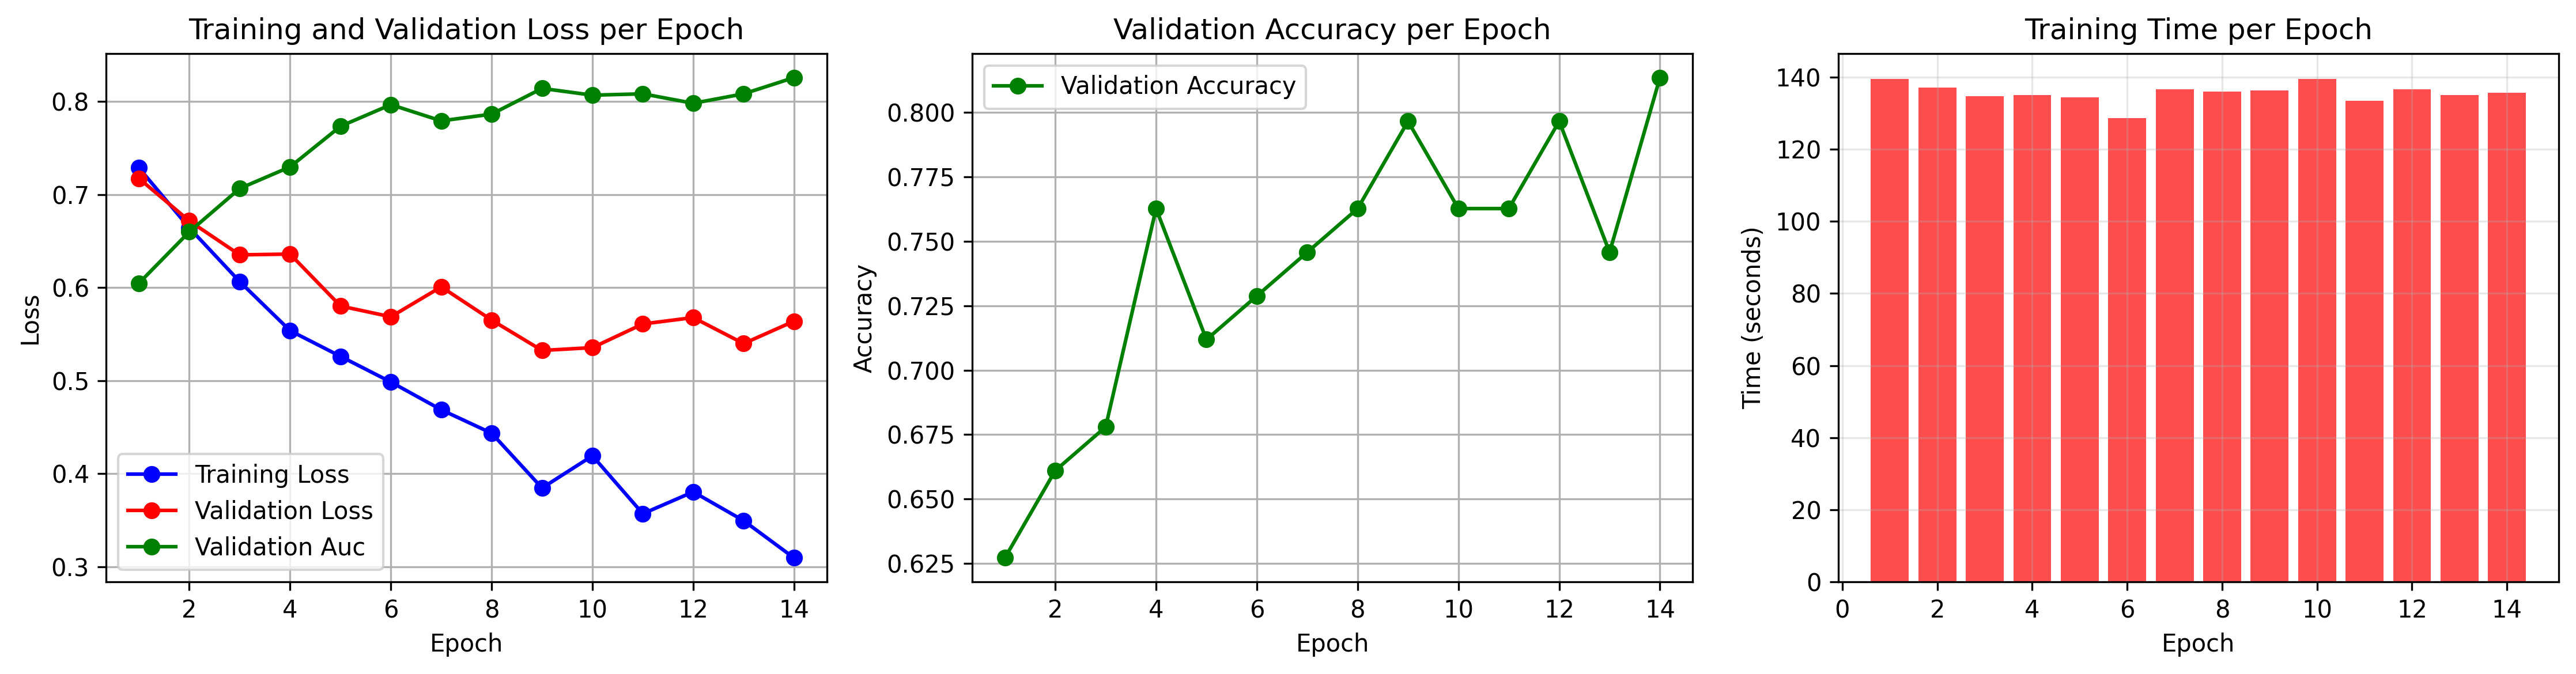


Total training time: 1898.61s

Training completed.
Ensured checkpoint directory exists: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_base_l8_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_base_l8_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_base_l8_mixup


In [ ]:

checkpoint = BASE_DIR / "models/checkpoints_main/PEFT_dino_base_l8_mixup"

dino_v2_base_l8_mix, history = train_peft_pipeline(
    model_name="facebook/dinov2-base",
    lora_config=lora_config_8,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    checkpoint_dir=checkpoint,
    label_col="malignant",
    lr=1e-4,
    epochs=20,
    batch_size=32,
    mix_up=True,
    early_stopping_patience=5,
    device=device
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating: 100%|██████████| 1/1 [00:15<00:00, 15.54s/it]




--- Overall Metrics ---
accuracy: 0.8030
precision: 0.8070
recall: 0.8030
f1: 0.8048
auc: 0.7623
inference_time: 0.2358

--- FST Analysis (I-II and V-VI) ---

--- FST Group: I-II ---
Samples: 21
  AUC: 0.7750
  Accuracy: 0.8095
  Precision (weighted): 0.8095
  Recall (weighted): 0.8095
  F1-score (weighted): 0.8095

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.7875
  Accuracy: 0.8571
  Precision (weighted): 0.8698
  Recall (weighted): 0.8571
  F1-score (weighted): 0.8613


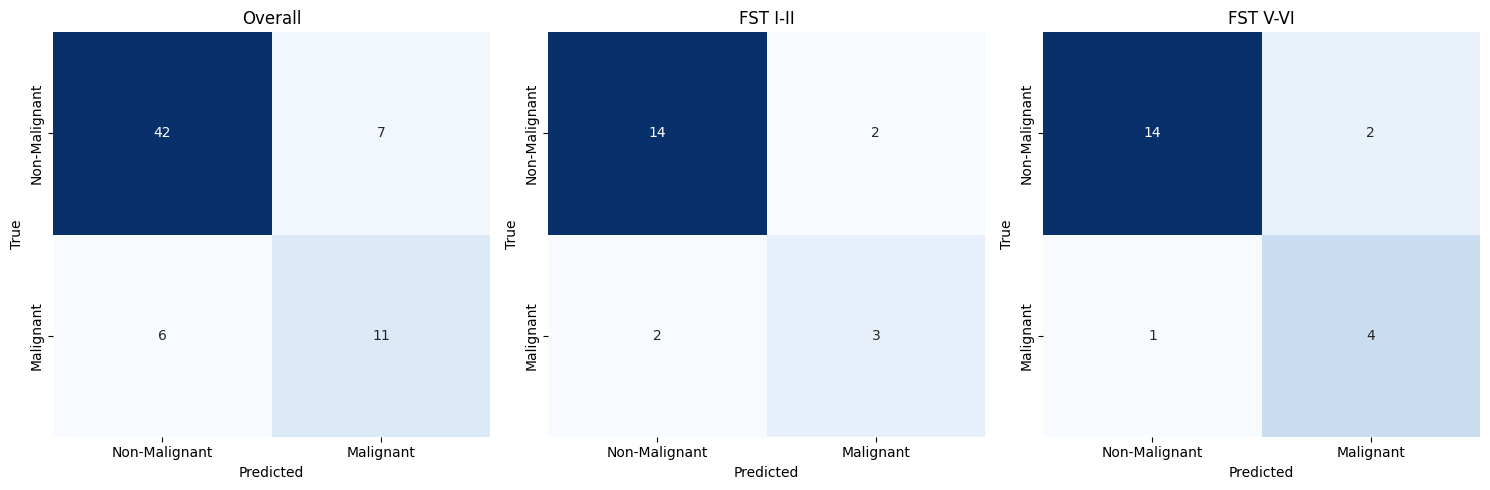

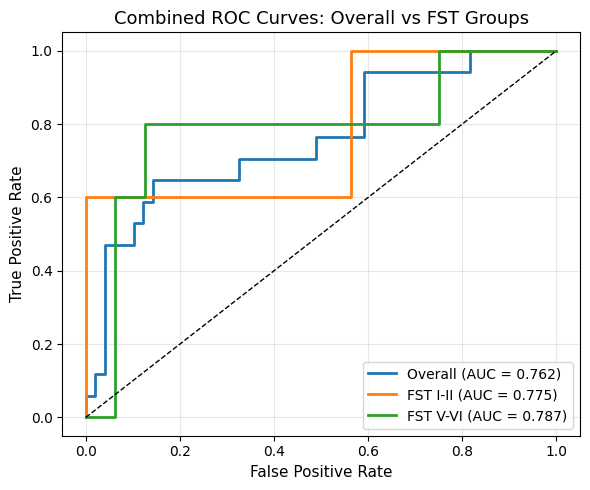

In [1045]:
# Load the PEFT model from checkpoint
checkpoint_dir = BASE_DIR / "models/checkpoints_main/PEFT_dino_base_l8_mixup"
checkpoint_dir_2 = BASE_DIR / "models/best/PEFT_dino_base_l8_mixup"
dino_v2_base_l8_mix, dino_v2_base_l8_history, dino_v2_base_l8_fst = evaluate_peft_model_pipeline(
    model_name_base,
    checkpoint_dir)

#### DINO V2 LARGE


Loading pre-trained model: facebook/dinov2-large


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/venv/lib/python3.12/site-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'facebook/dinov2-base' to 'facebook/dinov2-large'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/venv/lib/python3.12/site-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'facebook/dinov2-base' to 'facebook/dinov2-large'. Please ensure that the correct base model is loaded when loading this checkpoint.
 

Model loaded successfully.
trainable params: 1,576,962 || all params: 305,949,700 || trainable%: 0.5154
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20


  Training Epoch 1: 100%|██████████| 17/17 [08:01<00:00, 28.33s/it, loss=0.764]



  End of Epoch 1 | Train Loss: 0.7641 | Time: 481.67s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:12<00:00,  6.32s/it]




 ----- Validation Metrics (Epoch 1) ----- 
Train Loss:    0.7641
Val Loss:      0.7787
Val Accuracy:  0.4407
Val Precision: 0.6231
Val Recall:    0.4407
Val F1-score:  0.4555
Val AUC:       0.5145
Inference time: 12.6507s | Avg per image: 0.21442s
Baseline set: loss=0.7787

Epoch 2/20


  Training Epoch 2: 100%|██████████| 17/17 [07:34<00:00, 26.73s/it, loss=0.676]



  End of Epoch 2 | Train Loss: 0.6755 | Time: 454.40s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.72s/it]




 ----- Validation Metrics (Epoch 2) ----- 
Train Loss:    0.6755
Val Loss:      0.7359
Val Accuracy:  0.7288
Val Precision: 0.7186
Val Recall:    0.7288
Val F1-score:  0.7229
Val AUC:       0.6672
Inference time: 13.4441s | Avg per image: 0.22787s
Improved: loss=0.7359 (best so far)

Epoch 3/20


  Training Epoch 3: 100%|██████████| 17/17 [07:04<00:00, 24.97s/it, loss=0.663]



  End of Epoch 3 | Train Loss: 0.6629 | Time: 424.45s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.78s/it]




 ----- Validation Metrics (Epoch 3) ----- 
Train Loss:    0.6629
Val Loss:      0.7069
Val Accuracy:  0.5593
Val Precision: 0.6871
Val Recall:    0.5593
Val F1-score:  0.5824
Val AUC:       0.6860
Inference time: 11.5688s | Avg per image: 0.19608s
Improved: loss=0.7069 (best so far)

Epoch 4/20


  Training Epoch 4: 100%|██████████| 17/17 [07:33<00:00, 26.65s/it, loss=0.577]



  End of Epoch 4 | Train Loss: 0.5769 | Time: 453.04s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]




 ----- Validation Metrics (Epoch 4) ----- 
Train Loss:    0.5769
Val Loss:      0.6862
Val Accuracy:  0.5763
Val Precision: 0.7384
Val Recall:    0.5763
Val F1-score:  0.5951
Val AUC:       0.7311
Inference time: 11.4917s | Avg per image: 0.19477s
Improved: loss=0.6862 (best so far)

Epoch 5/20


  Training Epoch 5: 100%|██████████| 17/17 [06:20<00:00, 22.39s/it, loss=0.61] 


  End of Epoch 5 | Train Loss: 0.6096 | Time: 380.56s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]




 ----- Validation Metrics (Epoch 5) ----- 
Train Loss:    0.6096
Val Loss:      0.6152
Val Accuracy:  0.6949
Val Precision: 0.7490
Val Recall:    0.6949
Val F1-score:  0.7098
Val AUC:       0.7544
Inference time: 11.6518s | Avg per image: 0.19749s
Improved: loss=0.6152 (best so far)

Epoch 6/20


  Training Epoch 6: 100%|██████████| 17/17 [06:17<00:00, 22.19s/it, loss=0.543]



  End of Epoch 6 | Train Loss: 0.5430 | Time: 377.21s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.75s/it]




 ----- Validation Metrics (Epoch 6) ----- 
Train Loss:    0.5430
Val Loss:      0.6461
Val Accuracy:  0.6949
Val Precision: 0.7490
Val Recall:    0.6949
Val F1-score:  0.7098
Val AUC:       0.7544
Inference time: 11.5037s | Avg per image: 0.19498s
No improvement: loss=0.6461 | Patience: 1/5

Epoch 7/20


  Training Epoch 7: 100%|██████████| 17/17 [07:38<00:00, 26.97s/it, loss=0.512]



  End of Epoch 7 | Train Loss: 0.5117 | Time: 458.53s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.71s/it]




 ----- Validation Metrics (Epoch 7) ----- 
Train Loss:    0.5117
Val Loss:      0.6145
Val Accuracy:  0.6441
Val Precision: 0.7878
Val Recall:    0.6441
Val F1-score:  0.6620
Val AUC:       0.7762
Inference time: 13.4265s | Avg per image: 0.22757s
No improvement: loss=0.6145 | Patience: 2/5

Epoch 8/20


  Training Epoch 8: 100%|██████████| 17/17 [07:57<00:00, 28.12s/it, loss=0.458]



  End of Epoch 8 | Train Loss: 0.4581 | Time: 477.99s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:17<00:00,  8.61s/it]




 ----- Validation Metrics (Epoch 8) ----- 
Train Loss:    0.4581
Val Loss:      0.6341
Val Accuracy:  0.7288
Val Precision: 0.7523
Val Recall:    0.7288
Val F1-score:  0.7373
Val AUC:       0.7500
Inference time: 17.2200s | Avg per image: 0.29186s
No improvement: loss=0.6341 | Patience: 3/5

Epoch 9/20


  Training Epoch 9: 100%|██████████| 17/17 [09:08<00:00, 32.27s/it, loss=0.426]



  End of Epoch 9 | Train Loss: 0.4259 | Time: 548.67s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.73s/it]




 ----- Validation Metrics (Epoch 9) ----- 
Train Loss:    0.4259
Val Loss:      0.6056
Val Accuracy:  0.6780
Val Precision: 0.7410
Val Recall:    0.6780
Val F1-score:  0.6945
Val AUC:       0.7573
Inference time: 13.4746s | Avg per image: 0.22838s
Improved: loss=0.6056 (best so far)

Epoch 10/20


  Training Epoch 10: 100%|██████████| 17/17 [09:03<00:00, 31.96s/it, loss=0.45] 



  End of Epoch 10 | Train Loss: 0.4503 | Time: 543.33s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:14<00:00,  7.18s/it]




 ----- Validation Metrics (Epoch 10) ----- 
Train Loss:    0.4503
Val Loss:      0.6048
Val Accuracy:  0.7627
Val Precision: 0.7728
Val Recall:    0.7627
Val F1-score:  0.7669
Val AUC:       0.7762
Inference time: 14.3707s | Avg per image: 0.24357s
No improvement: loss=0.6048 | Patience: 1/5

Epoch 11/20


  Training Epoch 11: 100%|██████████| 17/17 [08:05<00:00, 28.54s/it, loss=0.409]



  End of Epoch 11 | Train Loss: 0.4087 | Time: 485.20s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.75s/it]




 ----- Validation Metrics (Epoch 11) ----- 
Train Loss:    0.4087
Val Loss:      0.6222
Val Accuracy:  0.6271
Val Precision: 0.7368
Val Recall:    0.6271
Val F1-score:  0.6476
Val AUC:       0.7718
Inference time: 13.4985s | Avg per image: 0.22879s
No improvement: loss=0.6222 | Patience: 2/5

Epoch 12/20


  Training Epoch 12: 100%|██████████| 17/17 [07:07<00:00, 25.15s/it, loss=0.419]



  End of Epoch 12 | Train Loss: 0.4190 | Time: 427.53s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:12<00:00,  6.48s/it]




 ----- Validation Metrics (Epoch 12) ----- 
Train Loss:    0.4190
Val Loss:      0.6732
Val Accuracy:  0.7797
Val Precision: 0.7842
Val Recall:    0.7797
Val F1-score:  0.7817
Val AUC:       0.7645
Inference time: 12.9630s | Avg per image: 0.21971s
No improvement: loss=0.6732 | Patience: 3/5

Epoch 13/20


  Training Epoch 13: 100%|██████████| 17/17 [07:47<00:00, 27.49s/it, loss=0.359]


  End of Epoch 13 | Train Loss: 0.3588 | Time: 467.40s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.77s/it]




 ----- Validation Metrics (Epoch 13) ----- 
Train Loss:    0.3588
Val Loss:      0.6079
Val Accuracy:  0.6780
Val Precision: 0.7582
Val Recall:    0.6780
Val F1-score:  0.6955
Val AUC:       0.7689
Inference time: 13.5515s | Avg per image: 0.22969s
No improvement: loss=0.6079 | Patience: 4/5

Epoch 14/20


  Training Epoch 14: 100%|██████████| 17/17 [07:57<00:00, 28.09s/it, loss=0.336]


  End of Epoch 14 | Train Loss: 0.3359 | Time: 477.52s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:12<00:00,  6.38s/it]




 ----- Validation Metrics (Epoch 14) ----- 
Train Loss:    0.3359
Val Loss:      0.5869
Val Accuracy:  0.7458
Val Precision: 0.7622
Val Recall:    0.7458
Val F1-score:  0.7521
Val AUC:       0.7689
Inference time: 12.7676s | Avg per image: 0.2164s
Improved: loss=0.5869 (best so far)

Epoch 15/20


  Training Epoch 15: 100%|██████████| 17/17 [08:22<00:00, 29.56s/it, loss=0.322]



  End of Epoch 15 | Train Loss: 0.3216 | Time: 502.56s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.54s/it]




 ----- Validation Metrics (Epoch 15) ----- 
Train Loss:    0.3216
Val Loss:      0.5878
Val Accuracy:  0.7288
Val Precision: 0.7659
Val Recall:    0.7288
Val F1-score:  0.7401
Val AUC:       0.7718
Inference time: 13.0778s | Avg per image: 0.22166s
No improvement: loss=0.5878 | Patience: 1/5

Epoch 16/20


  Training Epoch 16: 100%|██████████| 17/17 [08:01<00:00, 28.34s/it, loss=0.343]



  End of Epoch 16 | Train Loss: 0.3429 | Time: 481.85s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:12<00:00,  6.43s/it]




 ----- Validation Metrics (Epoch 16) ----- 
Train Loss:    0.3429
Val Loss:      0.6228
Val Accuracy:  0.7288
Val Precision: 0.7659
Val Recall:    0.7288
Val F1-score:  0.7401
Val AUC:       0.7631
Inference time: 12.8636s | Avg per image: 0.21803s
No improvement: loss=0.6228 | Patience: 2/5

Epoch 17/20


  Training Epoch 17: 100%|██████████| 17/17 [08:07<00:00, 28.65s/it, loss=0.292]


  End of Epoch 17 | Train Loss: 0.2925 | Time: 487.07s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.54s/it]




 ----- Validation Metrics (Epoch 17) ----- 
Train Loss:    0.2925
Val Loss:      0.6326
Val Accuracy:  0.7288
Val Precision: 0.7659
Val Recall:    0.7288
Val F1-score:  0.7401
Val AUC:       0.7631
Inference time: 13.0875s | Avg per image: 0.22182s
No improvement: loss=0.6326 | Patience: 3/5

Epoch 18/20


  Training Epoch 18: 100%|██████████| 17/17 [07:12<00:00, 25.46s/it, loss=0.32] 



  End of Epoch 18 | Train Loss: 0.3201 | Time: 432.85s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.69s/it]




 ----- Validation Metrics (Epoch 18) ----- 
Train Loss:    0.3201
Val Loss:      0.6353
Val Accuracy:  0.7119
Val Precision: 0.7429
Val Recall:    0.7119
Val F1-score:  0.7224
Val AUC:       0.7631
Inference time: 13.3889s | Avg per image: 0.22693s
No improvement: loss=0.6353 | Patience: 4/5

Epoch 19/20


  Training Epoch 19: 100%|██████████| 17/17 [08:14<00:00, 29.09s/it, loss=0.282]



  End of Epoch 19 | Train Loss: 0.2816 | Time: 494.52s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.51s/it]




 ----- Validation Metrics (Epoch 19) ----- 
Train Loss:    0.2816
Val Loss:      0.5935
Val Accuracy:  0.7119
Val Precision: 0.7429
Val Recall:    0.7119
Val F1-score:  0.7224
Val AUC:       0.7631
Inference time: 13.0253s | Avg per image: 0.22077s
No improvement: loss=0.5935 | Patience: 5/5

 EARLY STOPPING TRIGGERED!
   Best loss=0.5869 at Epoch 14
   No improvement for 5 consecutive epochs

   Model restored to best state (Epoch 14)

   Model restored to best state (Epoch 14)



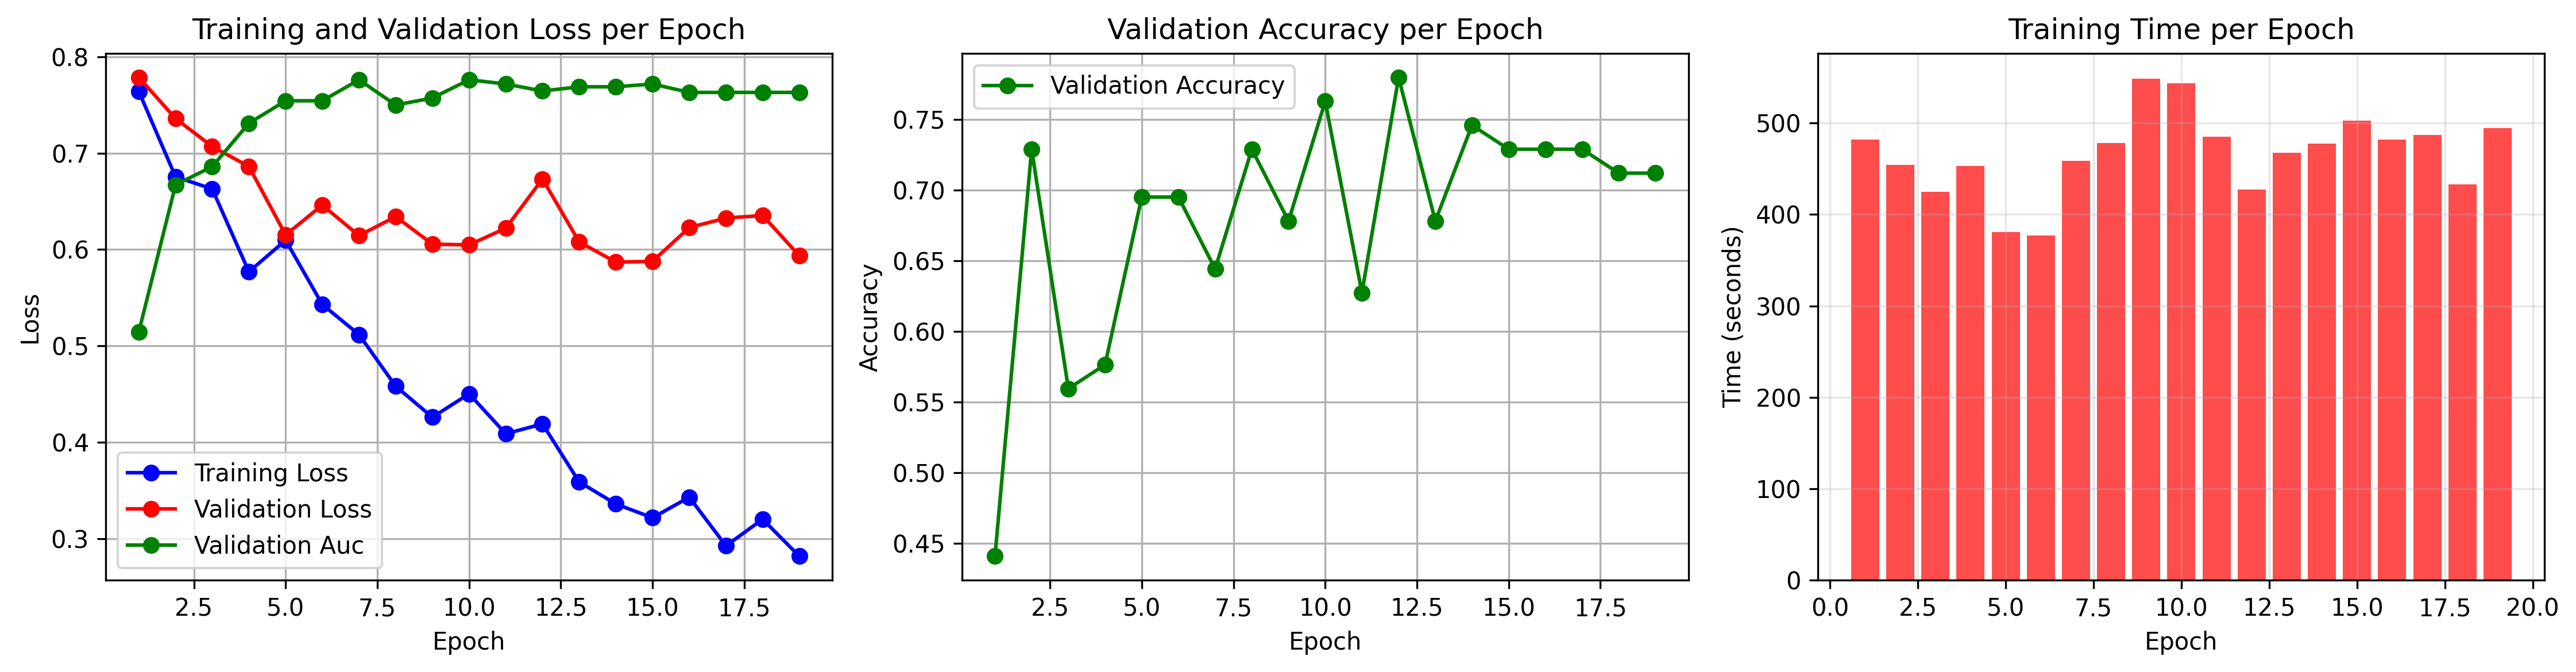


Total training time: 8856.33s

Training completed.
Ensured checkpoint directory exists: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_large_l8_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_large_l8_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_large_l8_mixup


In [ ]:

checkpoint = BASE_DIR / "models/checkpoints_main/PEFT_dino_large_l8_mixup"

dino_v2_base_l8_mix, history = train_peft_pipeline(
    model_name="facebook/dinov2-large",
    lora_config=lora_config_8,
    train_df=ddi_X_train,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    checkpoint_dir=checkpoint,
    label_col="malignant",
    lr=1e-4,
    epochs=20,
    batch_size=32,
    mix_up=True,
    early_stopping_patience=5,
    device=device
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating: 100%|██████████| 1/1 [00:16<00:00, 16.94s/it]


--- Overall Metrics ---
accuracy: 0.7121
precision: 0.7414
recall: 0.7121
f1: 0.7228
auc: 0.7467
inference_time: 0.2567

--- FST Analysis (I-II and V-VI) ---

--- FST Group: I-II ---
Samples: 21
  AUC: 0.7375
  Accuracy: 0.7143
  Precision (weighted): 0.7551
  Recall (weighted): 0.7143
  F1-score (weighted): 0.7286

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.7375
  Accuracy: 0.6190
  Precision (weighted): 0.6667
  Recall (weighted): 0.6190
  F1-score (weighted): 0.6381


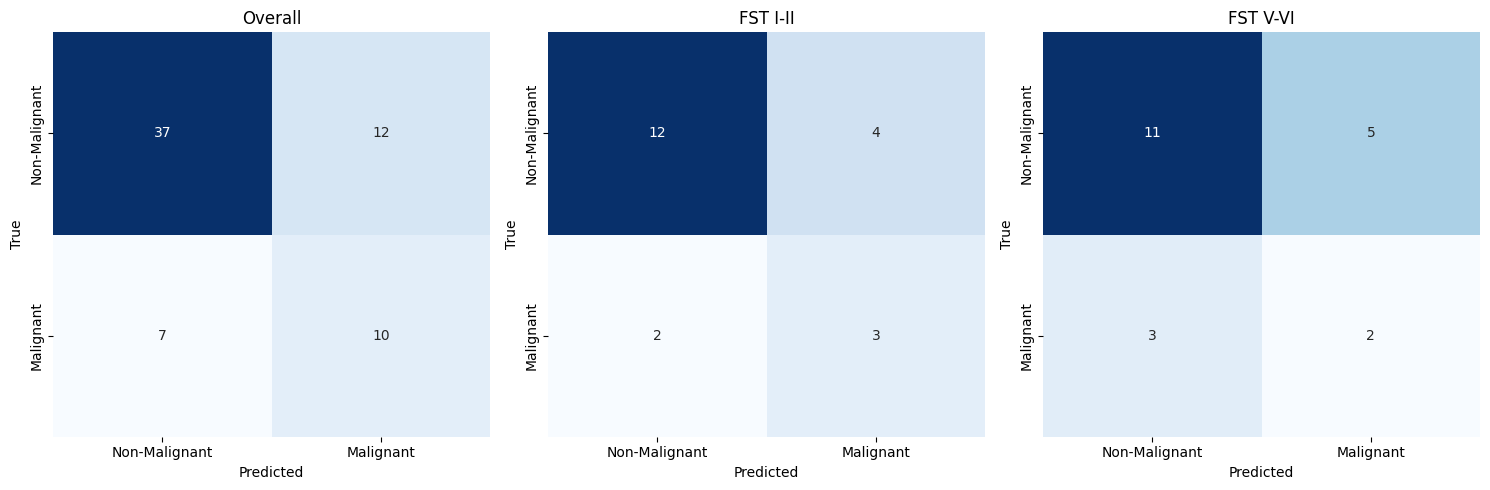

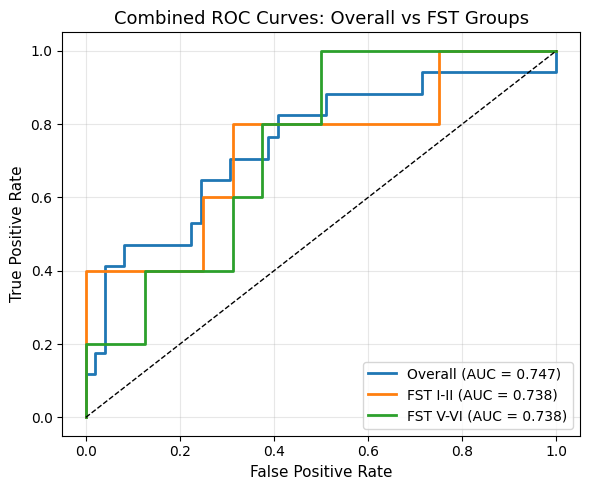

In [ ]:
# Load the PEFT model from checkpoint
checkpoint_dir = BASE_DIR / "models/checkpoints_main/PEFT_dino_large_l8_mixup"


dino_v2_large_l8_mix, dino_v2_large_l8_history, dino_v2_large_l8_fst = evaluate_peft_model_pipeline(
    model_name_large,
    checkpoint_dir)

### RANK 16


#### DINOV2 SMALL


Loading pre-trained model: facebook/dinov2-small


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.
trainable params: 591,362 || all params: 22,649,476 || trainable%: 2.6109
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20


  Training Epoch 1: 100%|██████████| 17/17 [01:08<00:00,  4.00s/it, loss=0.858]


  End of Epoch 1 | Train Loss: 0.8578 | Time: 68.07s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]




 ----- Validation Metrics (Epoch 1) ----- 
Train Loss:    0.8578
Val Loss:      0.6634
Val Accuracy:  0.5932
Val Precision: 0.7225
Val Recall:    0.5932
Val F1-score:  0.6145
Val AUC:       0.6686
Inference time: 3.0041s | Avg per image: 0.05092s
Baseline set: loss=0.6634

Epoch 2/20


  Training Epoch 2: 100%|██████████| 17/17 [01:10<00:00,  4.14s/it, loss=0.705]


  End of Epoch 2 | Train Loss: 0.7049 | Time: 70.42s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]




 ----- Validation Metrics (Epoch 2) ----- 
Train Loss:    0.7049
Val Loss:      0.7110
Val Accuracy:  0.4407
Val Precision: 0.7091
Val Recall:    0.4407
Val F1-score:  0.4313
Val AUC:       0.7137
Inference time: 2.8832s | Avg per image: 0.04887s
No improvement: loss=0.7110 | Patience: 1/5

Epoch 3/20


  Training Epoch 3: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it, loss=0.617]


  End of Epoch 3 | Train Loss: 0.6171 | Time: 68.77s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]




 ----- Validation Metrics (Epoch 3) ----- 
Train Loss:    0.6171
Val Loss:      0.6451
Val Accuracy:  0.5085
Val Precision: 0.7404
Val Recall:    0.5085
Val F1-score:  0.5155
Val AUC:       0.7427
Inference time: 3.4145s | Avg per image: 0.05787s
Improved: loss=0.6451 (best so far)

Epoch 4/20


  Training Epoch 4: 100%|██████████| 17/17 [01:06<00:00,  3.91s/it, loss=0.57] 


  End of Epoch 4 | Train Loss: 0.5701 | Time: 66.50s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]




 ----- Validation Metrics (Epoch 4) ----- 
Train Loss:    0.5701
Val Loss:      0.5921
Val Accuracy:  0.6949
Val Precision: 0.7656
Val Recall:    0.6949
Val F1-score:  0.7112
Val AUC:       0.7674
Inference time: 2.8488s | Avg per image: 0.04829s
Improved: loss=0.5921 (best so far)

Epoch 5/20


  Training Epoch 5: 100%|██████████| 17/17 [01:09<00:00,  4.11s/it, loss=0.535]


  End of Epoch 5 | Train Loss: 0.5350 | Time: 69.82s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]




 ----- Validation Metrics (Epoch 5) ----- 
Train Loss:    0.5350
Val Loss:      0.5712
Val Accuracy:  0.6610
Val Precision: 0.7331
Val Recall:    0.6610
Val F1-score:  0.6791
Val AUC:       0.7747
Inference time: 2.9100s | Avg per image: 0.04932s
Improved: loss=0.5712 (best so far)

Epoch 6/20


  Training Epoch 6: 100%|██████████| 17/17 [01:07<00:00,  4.00s/it, loss=0.46] 


  End of Epoch 6 | Train Loss: 0.4603 | Time: 67.94s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]




 ----- Validation Metrics (Epoch 6) ----- 
Train Loss:    0.4603
Val Loss:      0.6451
Val Accuracy:  0.4915
Val Precision: 0.7335
Val Recall:    0.4915
Val F1-score:  0.4953
Val AUC:       0.7674
Inference time: 2.9106s | Avg per image: 0.04933s
No improvement: loss=0.6451 | Patience: 1/5

Epoch 7/20


  Training Epoch 7: 100%|██████████| 17/17 [01:06<00:00,  3.92s/it, loss=0.529]


  End of Epoch 7 | Train Loss: 0.5286 | Time: 66.65s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]




 ----- Validation Metrics (Epoch 7) ----- 
Train Loss:    0.5286
Val Loss:      0.5627
Val Accuracy:  0.6949
Val Precision: 0.7656
Val Recall:    0.6949
Val F1-score:  0.7112
Val AUC:       0.7965
Inference time: 2.8917s | Avg per image: 0.04901s
Improved: loss=0.5627 (best so far)

Epoch 8/20


  Training Epoch 8: 100%|██████████| 17/17 [01:06<00:00,  3.90s/it, loss=0.437]


  End of Epoch 8 | Train Loss: 0.4371 | Time: 66.37s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]



 ----- Validation Metrics (Epoch 8) ----- 
Train Loss:    0.4371
Val Loss:      0.5656
Val Accuracy:  0.7119
Val Precision: 0.7297
Val Recall:    0.7119
Val F1-score:  0.7190
Val AUC:       0.7922
Inference time: 2.8423s | Avg per image: 0.04817s
No improvement: loss=0.5656 | Patience: 1/5

Epoch 9/20


  Training Epoch 9: 100%|██████████| 17/17 [01:06<00:00,  3.93s/it, loss=0.386]


  End of Epoch 9 | Train Loss: 0.3856 | Time: 66.88s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]




 ----- Validation Metrics (Epoch 9) ----- 
Train Loss:    0.3856
Val Loss:      0.5371
Val Accuracy:  0.7458
Val Precision: 0.7509
Val Recall:    0.7458
Val F1-score:  0.7481
Val AUC:       0.7849
Inference time: 2.8637s | Avg per image: 0.04854s
Improved: loss=0.5371 (best so far)

Epoch 10/20


  Training Epoch 10: 100%|██████████| 17/17 [01:06<00:00,  3.94s/it, loss=0.341]


  End of Epoch 10 | Train Loss: 0.3406 | Time: 66.97s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]




 ----- Validation Metrics (Epoch 10) ----- 
Train Loss:    0.3406
Val Loss:      0.6027
Val Accuracy:  0.7627
Val Precision: 0.7627
Val Recall:    0.7627
Val F1-score:  0.7627
Val AUC:       0.7965
Inference time: 2.6257s | Avg per image: 0.0445s
No improvement: loss=0.6027 | Patience: 1/5

Epoch 11/20


  Training Epoch 11: 100%|██████████| 17/17 [01:07<00:00,  3.96s/it, loss=0.33] 


  End of Epoch 11 | Train Loss: 0.3304 | Time: 67.28s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]




 ----- Validation Metrics (Epoch 11) ----- 
Train Loss:    0.3304
Val Loss:      0.6840
Val Accuracy:  0.7797
Val Precision: 0.7689
Val Recall:    0.7797
Val F1-score:  0.7720
Val AUC:       0.7791
Inference time: 2.6446s | Avg per image: 0.04482s
No improvement: loss=0.6840 | Patience: 2/5

Epoch 12/20


  Training Epoch 12: 100%|██████████| 17/17 [01:04<00:00,  3.80s/it, loss=0.304]


  End of Epoch 12 | Train Loss: 0.3045 | Time: 64.69s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]




 ----- Validation Metrics (Epoch 12) ----- 
Train Loss:    0.3045
Val Loss:      0.6267
Val Accuracy:  0.7627
Val Precision: 0.7627
Val Recall:    0.7627
Val F1-score:  0.7627
Val AUC:       0.7733
Inference time: 2.7369s | Avg per image: 0.04639s
No improvement: loss=0.6267 | Patience: 3/5

Epoch 13/20


  Training Epoch 13: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it, loss=0.295]


  End of Epoch 13 | Train Loss: 0.2951 | Time: 68.68s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]




 ----- Validation Metrics (Epoch 13) ----- 
Train Loss:    0.2951
Val Loss:      0.6037
Val Accuracy:  0.7458
Val Precision: 0.7509
Val Recall:    0.7458
Val F1-score:  0.7481
Val AUC:       0.7718
Inference time: 3.7903s | Avg per image: 0.06424s
No improvement: loss=0.6037 | Patience: 4/5

Epoch 14/20


  Training Epoch 14: 100%|██████████| 17/17 [01:07<00:00,  4.00s/it, loss=0.277]


  End of Epoch 14 | Train Loss: 0.2770 | Time: 68.00s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]




 ----- Validation Metrics (Epoch 14) ----- 
Train Loss:    0.2770
Val Loss:      0.6819
Val Accuracy:  0.7797
Val Precision: 0.7756
Val Recall:    0.7797
Val F1-score:  0.7774
Val AUC:       0.7660
Inference time: 2.5161s | Avg per image: 0.04265s
No improvement: loss=0.6819 | Patience: 5/5

 EARLY STOPPING TRIGGERED!
   Best loss=0.5371 at Epoch 9
   No improvement for 5 consecutive epochs

   Model restored to best state (Epoch 9)

   Model restored to best state (Epoch 9)



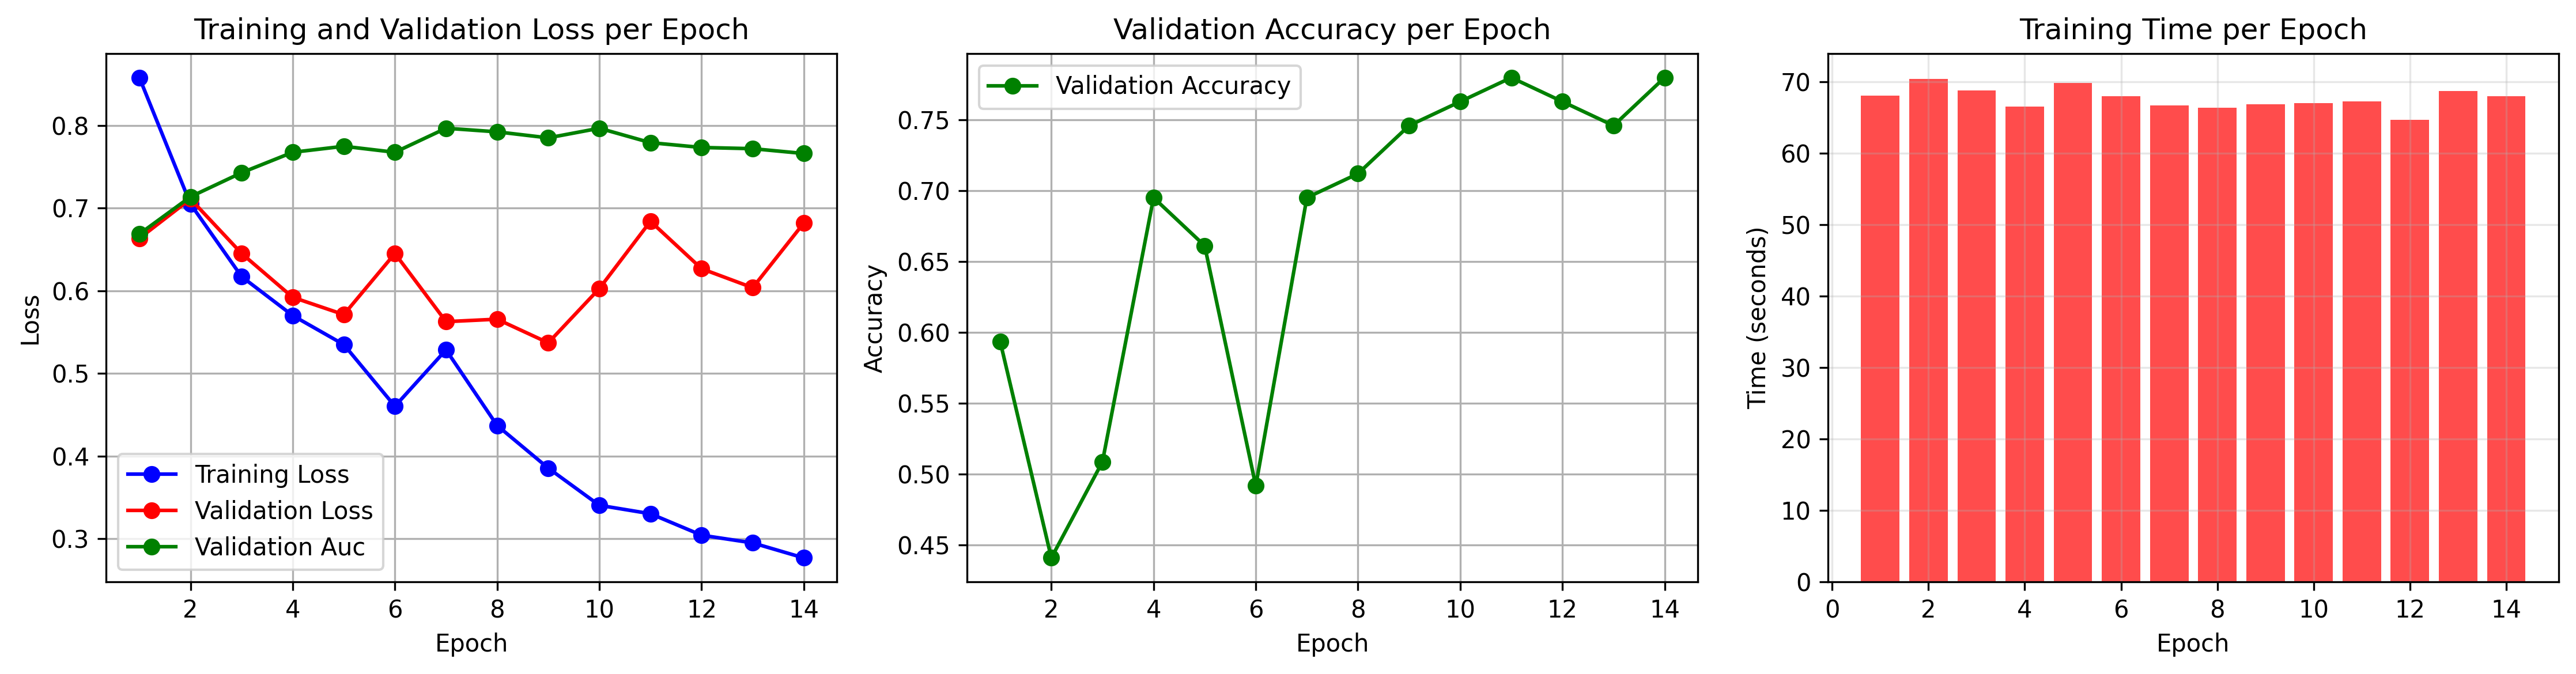


Total training time: 947.03s

Training completed.
Ensured checkpoint directory exists: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l16_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l16_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l16_mixup


In [ ]:

checkpoint = BASE_DIR / "models/checkpoints_main/PEFT_dino_small_l16_mixup"

dino_v2_small_l16_mix, history = train_peft_pipeline(
    model_name="facebook/dinov2-small",
    lora_config=lora_config_16,
    train_df=ddi_X_train,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    checkpoint_dir=checkpoint,
    label_col="malignant",
    lr=1e-4,
    epochs=20,
    batch_size=32,
    mix_up=True,
    early_stopping_patience=5,
    device=device
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


--- Overall Metrics ---
accuracy: 0.7273
precision: 0.7496
recall: 0.7273
f1: 0.7358
auc: 0.7419
inference_time: 0.0655

--- FST Analysis (I-II and V-VI) ---

--- FST Group: I-II ---
Samples: 21
  AUC: 0.7000
  Accuracy: 0.8571
  Precision (weighted): 0.8508
  Recall (weighted): 0.8571
  F1-score (weighted): 0.8514

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.6750
  Accuracy: 0.6190
  Precision (weighted): 0.7143
  Recall (weighted): 0.6190
  F1-score (weighted): 0.6463


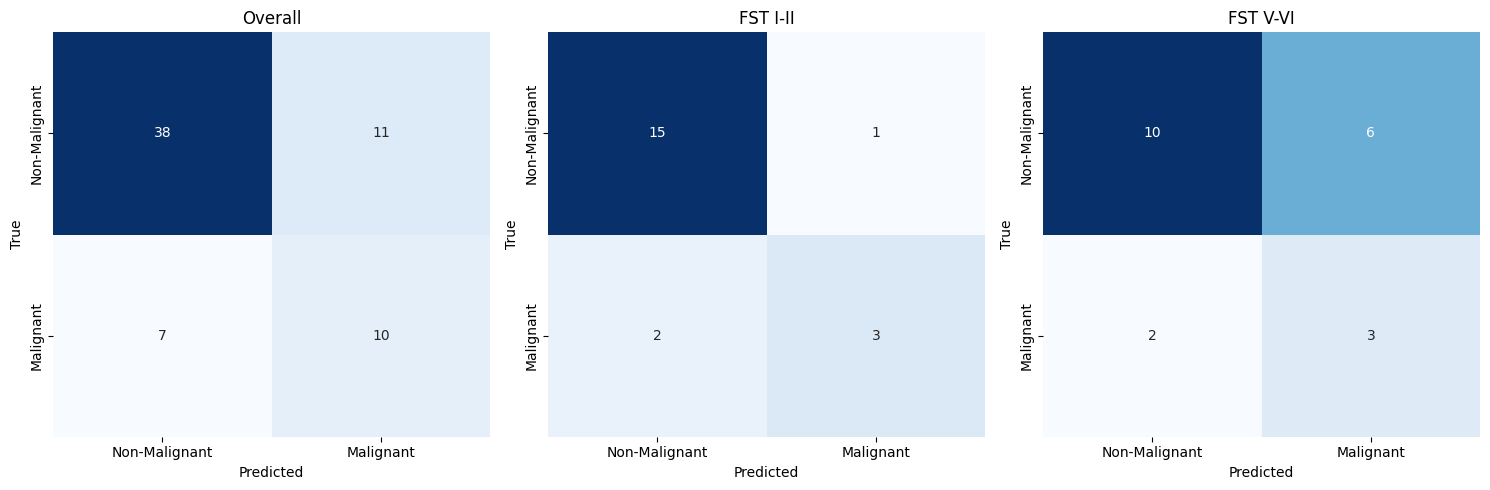

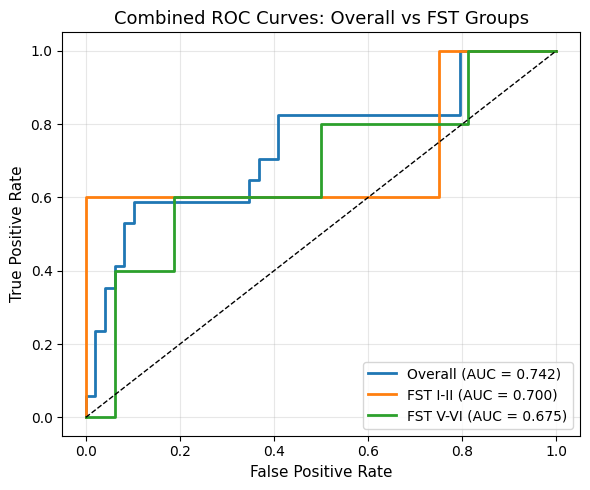

In [ ]:
# Load the PEFT model from checkpoint
checkpoint_dir = BASE_DIR / "models/checkpoints_main/PEFT_dino_small_l16_mixup"

dino_v2_small_l16_mix, dino_v2_small_l16_mix_history, dino_v2_small_l16_mix_fst = evaluate_peft_model_pipeline(
    model_name_small,
    checkpoint_dir)

#### DINOV2 BASE 


Loading pre-trained model: facebook/dinov2-base


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.
trainable params: 1,182,722 || all params: 87,766,276 || trainable%: 1.3476
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20
trainable params: 1,182,722 || all params: 87,766,276 || trainable%: 1.3476
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20


  Training Epoch 1: 100%|██████████| 17/17 [02:07<00:00,  7.50s/it, loss=0.828]


  End of Epoch 1 | Train Loss: 0.8277 | Time: 127.57s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]




 ----- Validation Metrics (Epoch 1) ----- 
Train Loss:    0.8277
Val Loss:      0.6861
Val Accuracy:  0.6610
Val Precision: 0.6743
Val Recall:    0.6610
Val F1-score:  0.6670
Val AUC:       0.6250
Inference time: 4.6398s | Avg per image: 0.07864s
Baseline set: loss=0.6861

Epoch 2/20


  Training Epoch 2: 100%|██████████| 17/17 [02:04<00:00,  7.34s/it, loss=0.642]


  End of Epoch 2 | Train Loss: 0.6417 | Time: 124.75s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:05<00:00,  2.50s/it]




 ----- Validation Metrics (Epoch 2) ----- 
Train Loss:    0.6417
Val Loss:      0.5314
Val Accuracy:  0.7627
Val Precision: 0.8307
Val Recall:    0.7627
Val F1-score:  0.7753
Val AUC:       0.8285
Inference time: 5.0112s | Avg per image: 0.08493s
Improved: loss=0.5314 (best so far)

Epoch 3/20


  Training Epoch 3: 100%|██████████| 17/17 [02:05<00:00,  7.38s/it, loss=0.539]


  End of Epoch 3 | Train Loss: 0.5392 | Time: 125.50s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.37s/it]




 ----- Validation Metrics (Epoch 3) ----- 
Train Loss:    0.5392
Val Loss:      0.5319
Val Accuracy:  0.7627
Val Precision: 0.7627
Val Recall:    0.7627
Val F1-score:  0.7627
Val AUC:       0.8328
Inference time: 4.7371s | Avg per image: 0.08029s
No improvement: loss=0.5319 | Patience: 1/5

Epoch 4/20


  Training Epoch 4: 100%|██████████| 17/17 [02:08<00:00,  7.55s/it, loss=0.469]


  End of Epoch 4 | Train Loss: 0.4694 | Time: 128.41s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.33s/it]




 ----- Validation Metrics (Epoch 4) ----- 
Train Loss:    0.4694
Val Loss:      0.5318
Val Accuracy:  0.7627
Val Precision: 0.7542
Val Recall:    0.7627
Val F1-score:  0.7575
Val AUC:       0.8503
Inference time: 4.6622s | Avg per image: 0.07902s
No improvement: loss=0.5318 | Patience: 2/5

Epoch 5/20


  Training Epoch 5: 100%|██████████| 17/17 [02:06<00:00,  7.46s/it, loss=0.308]


  End of Epoch 5 | Train Loss: 0.3077 | Time: 126.91s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.33s/it]




 ----- Validation Metrics (Epoch 5) ----- 
Train Loss:    0.3077
Val Loss:      0.5039
Val Accuracy:  0.7797
Val Precision: 0.7756
Val Recall:    0.7797
Val F1-score:  0.7774
Val AUC:       0.8663
Inference time: 4.6583s | Avg per image: 0.07895s
Improved: loss=0.5039 (best so far)

Epoch 6/20


  Training Epoch 6: 100%|██████████| 17/17 [02:03<00:00,  7.25s/it, loss=0.255]


  End of Epoch 6 | Train Loss: 0.2555 | Time: 123.32s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]




 ----- Validation Metrics (Epoch 6) ----- 
Train Loss:    0.2555
Val Loss:      0.5356
Val Accuracy:  0.8305
Val Precision: 0.8268
Val Recall:    0.8305
Val F1-score:  0.8165
Val AUC:       0.8837
Inference time: 4.9043s | Avg per image: 0.08312s
No improvement: loss=0.5356 | Patience: 1/5

Epoch 7/20


  Training Epoch 7: 100%|██████████| 17/17 [02:09<00:00,  7.64s/it, loss=0.215]


  End of Epoch 7 | Train Loss: 0.2145 | Time: 129.81s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:05<00:00,  2.66s/it]




 ----- Validation Metrics (Epoch 7) ----- 
Train Loss:    0.2145
Val Loss:      0.5468
Val Accuracy:  0.8305
Val Precision: 0.8268
Val Recall:    0.8305
Val F1-score:  0.8165
Val AUC:       0.8648
Inference time: 5.3168s | Avg per image: 0.09012s
No improvement: loss=0.5468 | Patience: 2/5

Epoch 8/20


  Training Epoch 8: 100%|██████████| 17/17 [02:22<00:00,  8.36s/it, loss=0.208]


  End of Epoch 8 | Train Loss: 0.2079 | Time: 142.14s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]




 ----- Validation Metrics (Epoch 8) ----- 
Train Loss:    0.2079
Val Loss:      0.6115
Val Accuracy:  0.7797
Val Precision: 0.7638
Val Recall:    0.7797
Val F1-score:  0.7571
Val AUC:       0.8372
Inference time: 4.9645s | Avg per image: 0.08414s
No improvement: loss=0.6115 | Patience: 3/5

Epoch 9/20


  Training Epoch 9: 100%|██████████| 17/17 [02:17<00:00,  8.10s/it, loss=0.107]


  End of Epoch 9 | Train Loss: 0.1067 | Time: 137.68s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.47s/it]




 ----- Validation Metrics (Epoch 9) ----- 
Train Loss:    0.1067
Val Loss:      0.6815
Val Accuracy:  0.7966
Val Precision: 0.7893
Val Recall:    0.7966
Val F1-score:  0.7714
Val AUC:       0.8619
Inference time: 4.9503s | Avg per image: 0.0839s
No improvement: loss=0.6815 | Patience: 4/5

Epoch 10/20


  Training Epoch 10: 100%|██████████| 17/17 [02:17<00:00,  8.10s/it, loss=0.144]


  End of Epoch 10 | Train Loss: 0.1442 | Time: 137.70s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:05<00:00,  2.61s/it]




 ----- Validation Metrics (Epoch 10) ----- 
Train Loss:    0.1442
Val Loss:      0.6141
Val Accuracy:  0.8136
Val Precision: 0.8085
Val Recall:    0.8136
Val F1-score:  0.7945
Val AUC:       0.8576
Inference time: 5.2237s | Avg per image: 0.08854s
No improvement: loss=0.6141 | Patience: 5/5

 EARLY STOPPING TRIGGERED!
   Best loss=0.5039 at Epoch 5
   No improvement for 5 consecutive epochs

   Model restored to best state (Epoch 5)

   Model restored to best state (Epoch 5)



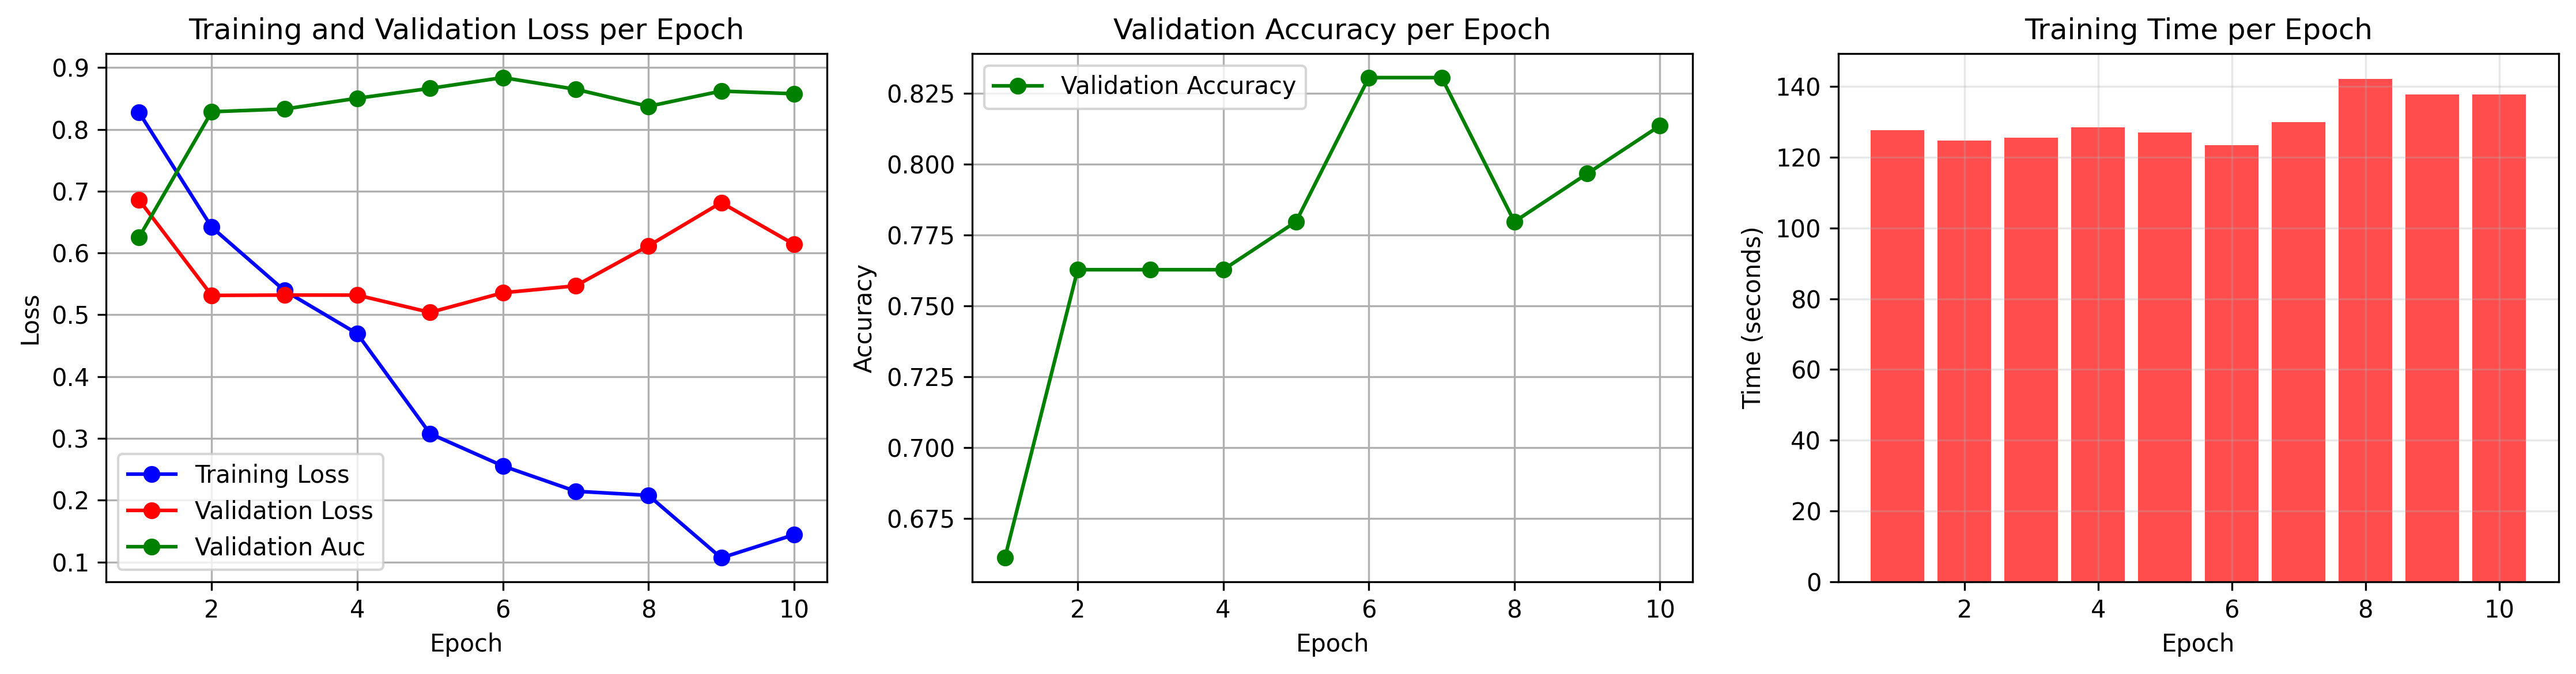


Total training time: 1303.79s

Training completed.
Ensured checkpoint directory exists: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_base_l16_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_base_l16_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_base_l16_mixup


In [ ]:

checkpoint = BASE_DIR / "models/checkpoints_main/PEFT_dino_base_l16_mixup"

dino_v2_base_l16_mix, history = train_peft_pipeline(
    model_name="facebook/dinov2-base",
    lora_config=lora_config_16,
    train_df=ddi_X_train,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    checkpoint_dir=checkpoint,
    label_col="malignant",
    lr=1e-4,
    epochs=20,
    batch_size=32,
    mix_up=True,
    early_stopping_patience=5,
    device=device
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1/1 [00:11<00:00, 11.39s/it]




--- Overall Metrics ---
accuracy: 0.8030
precision: 0.7938
recall: 0.8030
f1: 0.7964
auc: 0.7707
inference_time: 0.1726

--- FST Analysis (I-II and V-VI) ---

--- FST Group: I-II ---
Samples: 21
  AUC: 0.6750
  Accuracy: 0.8571
  Precision (weighted): 0.8508
  Recall (weighted): 0.8571
  F1-score (weighted): 0.8514

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.7625
  Accuracy: 0.7619
  Precision (weighted): 0.7794
  Recall (weighted): 0.7619
  F1-score (weighted): 0.7689


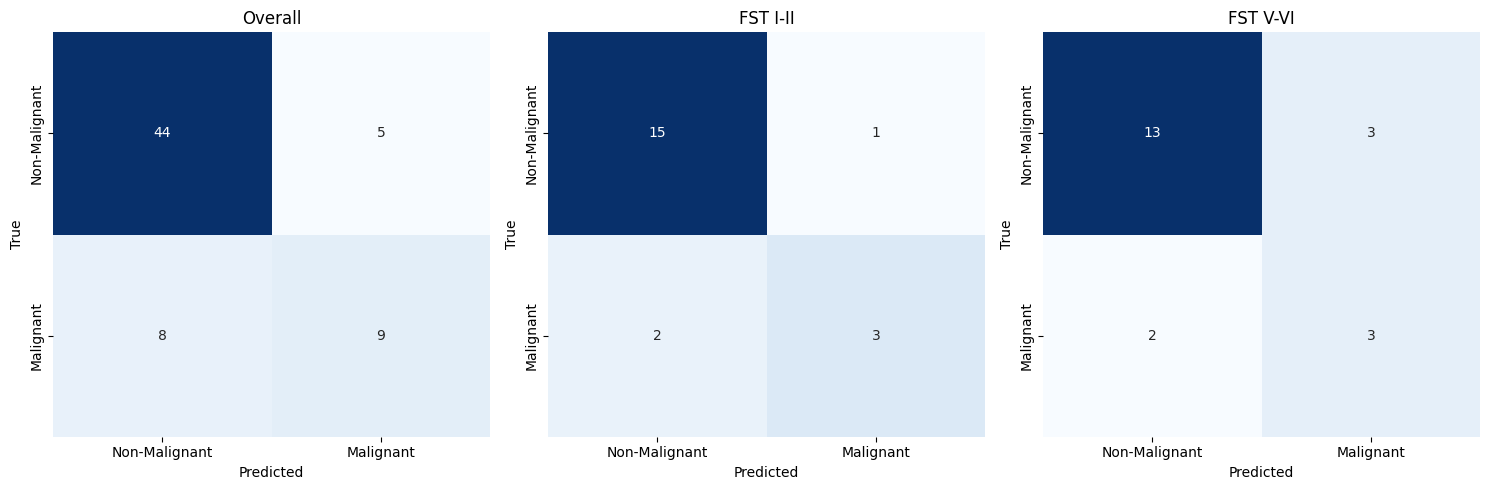

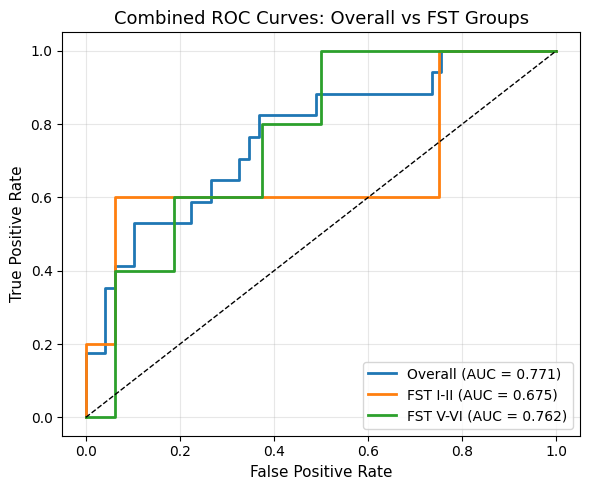

In [ ]:
# Load the PEFT model from checkpoint
checkpoint_dir = BASE_DIR / "models/checkpoints_main/PEFT_dino_base_l16_mixup"

dino_v2_base_l16_mix, dino_v2_base_l16_history, dino_v2_base_l16_fst = evaluate_peft_model_pipeline(
    model_name_base,
    checkpoint_dir)


#### DINOV2 LARGE


Loading pre-trained model: facebook/dinov2-large


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/venv/lib/python3.12/site-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'facebook/dinov2-base' to 'facebook/dinov2-large'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/venv/lib/python3.12/site-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'facebook/dinov2-base' to 'facebook/dinov2-large'. Please ensure that the correct base model is loaded when loading this checkpoint.
 

Model loaded successfully.
trainable params: 3,149,826 || all params: 307,522,564 || trainable%: 1.0243
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20


  Training Epoch 1: 100%|██████████| 17/17 [08:31<00:00, 30.10s/it, loss=1.01]



  End of Epoch 1 | Train Loss: 1.0091 | Time: 511.65s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:13<00:00,  6.55s/it]




 ----- Validation Metrics (Epoch 1) ----- 
Train Loss:    1.0091
Val Loss:      0.7918
Val Accuracy:  0.6102
Val Precision: 0.6177
Val Recall:    0.6102
Val F1-score:  0.6138
Val AUC:       0.5291
Inference time: 13.1098s | Avg per image: 0.2222s
Baseline set: loss=0.7918

Epoch 2/20


  Training Epoch 2: 100%|██████████| 17/17 [07:32<00:00, 26.61s/it, loss=0.748]



  End of Epoch 2 | Train Loss: 0.7480 | Time: 452.33s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:12<00:00,  6.26s/it]




 ----- Validation Metrics (Epoch 2) ----- 
Train Loss:    0.7480
Val Loss:      0.6683
Val Accuracy:  0.6780
Val Precision: 0.6716
Val Recall:    0.6780
Val F1-score:  0.6746
Val AUC:       0.6991
Inference time: 12.5308s | Avg per image: 0.21239s
Improved: loss=0.6683 (best so far)

Epoch 3/20


  Training Epoch 3: 100%|██████████| 17/17 [07:11<00:00, 25.38s/it, loss=0.596]



  End of Epoch 3 | Train Loss: 0.5958 | Time: 431.49s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:12<00:00,  6.28s/it]




 ----- Validation Metrics (Epoch 3) ----- 
Train Loss:    0.5958
Val Loss:      0.6411
Val Accuracy:  0.7627
Val Precision: 0.7474
Val Recall:    0.7627
Val F1-score:  0.7510
Val AUC:       0.7384
Inference time: 12.5628s | Avg per image: 0.21293s
Improved: loss=0.6411 (best so far)

Epoch 4/20


  Training Epoch 4: 100%|██████████| 17/17 [06:52<00:00, 24.27s/it, loss=0.554]



  End of Epoch 4 | Train Loss: 0.5544 | Time: 412.62s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]




 ----- Validation Metrics (Epoch 4) ----- 
Train Loss:    0.5544
Val Loss:      0.6229
Val Accuracy:  0.6271
Val Precision: 0.7178
Val Recall:    0.6271
Val F1-score:  0.6477
Val AUC:       0.7108
Inference time: 11.6532s | Avg per image: 0.19751s
Improved: loss=0.6229 (best so far)

Epoch 5/20


  Training Epoch 5: 100%|██████████| 17/17 [06:38<00:00, 23.46s/it, loss=0.501]



  End of Epoch 5 | Train Loss: 0.5005 | Time: 398.80s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]




 ----- Validation Metrics (Epoch 5) ----- 
Train Loss:    0.5005
Val Loss:      0.5863
Val Accuracy:  0.5932
Val Precision: 0.7450
Val Recall:    0.5932
Val F1-score:  0.6126
Val AUC:       0.7805
Inference time: 11.5767s | Avg per image: 0.19622s
Improved: loss=0.5863 (best so far)

Epoch 6/20


  Training Epoch 6: 100%|██████████| 17/17 [06:37<00:00, 23.38s/it, loss=0.467]



  End of Epoch 6 | Train Loss: 0.4668 | Time: 397.51s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]




 ----- Validation Metrics (Epoch 6) ----- 
Train Loss:    0.4668
Val Loss:      0.6026
Val Accuracy:  0.7458
Val Precision: 0.7409
Val Recall:    0.7458
Val F1-score:  0.7431
Val AUC:       0.7703
Inference time: 11.6423s | Avg per image: 0.19733s
No improvement: loss=0.6026 | Patience: 1/5

Epoch 7/20


  Training Epoch 7: 100%|██████████| 17/17 [07:34<00:00, 26.75s/it, loss=0.445]



  End of Epoch 7 | Train Loss: 0.4449 | Time: 454.68s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:12<00:00,  6.09s/it]




 ----- Validation Metrics (Epoch 7) ----- 
Train Loss:    0.4449
Val Loss:      0.7037
Val Accuracy:  0.7966
Val Precision: 0.7898
Val Recall:    0.7966
Val F1-score:  0.7921
Val AUC:       0.7369
Inference time: 12.1935s | Avg per image: 0.20667s
No improvement: loss=0.7037 | Patience: 2/5

Epoch 8/20


  Training Epoch 8: 100%|██████████| 17/17 [06:13<00:00, 22.00s/it, loss=0.351]



  End of Epoch 8 | Train Loss: 0.3512 | Time: 373.99s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.53s/it]




 ----- Validation Metrics (Epoch 8) ----- 
Train Loss:    0.3512
Val Loss:      0.6890
Val Accuracy:  0.7966
Val Precision: 0.7856
Val Recall:    0.7966
Val F1-score:  0.7866
Val AUC:       0.7573
Inference time: 11.0716s | Avg per image: 0.18765s
No improvement: loss=0.6890 | Patience: 3/5

Epoch 9/20


  Training Epoch 9: 100%|██████████| 17/17 [06:26<00:00, 22.74s/it, loss=0.416]


  End of Epoch 9 | Train Loss: 0.4156 | Time: 386.59s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.60s/it]




 ----- Validation Metrics (Epoch 9) ----- 
Train Loss:    0.4156
Val Loss:      0.6726
Val Accuracy:  0.8136
Val Precision: 0.8102
Val Recall:    0.8136
Val F1-score:  0.8116
Val AUC:       0.7413
Inference time: 11.2083s | Avg per image: 0.18997s
No improvement: loss=0.6726 | Patience: 4/5

Epoch 10/20


  Training Epoch 10: 100%|██████████| 17/17 [06:33<00:00, 23.14s/it, loss=0.308]



  End of Epoch 10 | Train Loss: 0.3075 | Time: 393.37s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.62s/it]




 ----- Validation Metrics (Epoch 10) ----- 
Train Loss:    0.3075
Val Loss:      0.5975
Val Accuracy:  0.8136
Val Precision: 0.8175
Val Recall:    0.8136
Val F1-score:  0.8153
Val AUC:       0.7660
Inference time: 11.2465s | Avg per image: 0.19062s
No improvement: loss=0.5975 | Patience: 5/5

 EARLY STOPPING TRIGGERED!
   Best loss=0.5863 at Epoch 5
   No improvement for 5 consecutive epochs

   Model restored to best state (Epoch 5)

   Model restored to best state (Epoch 5)



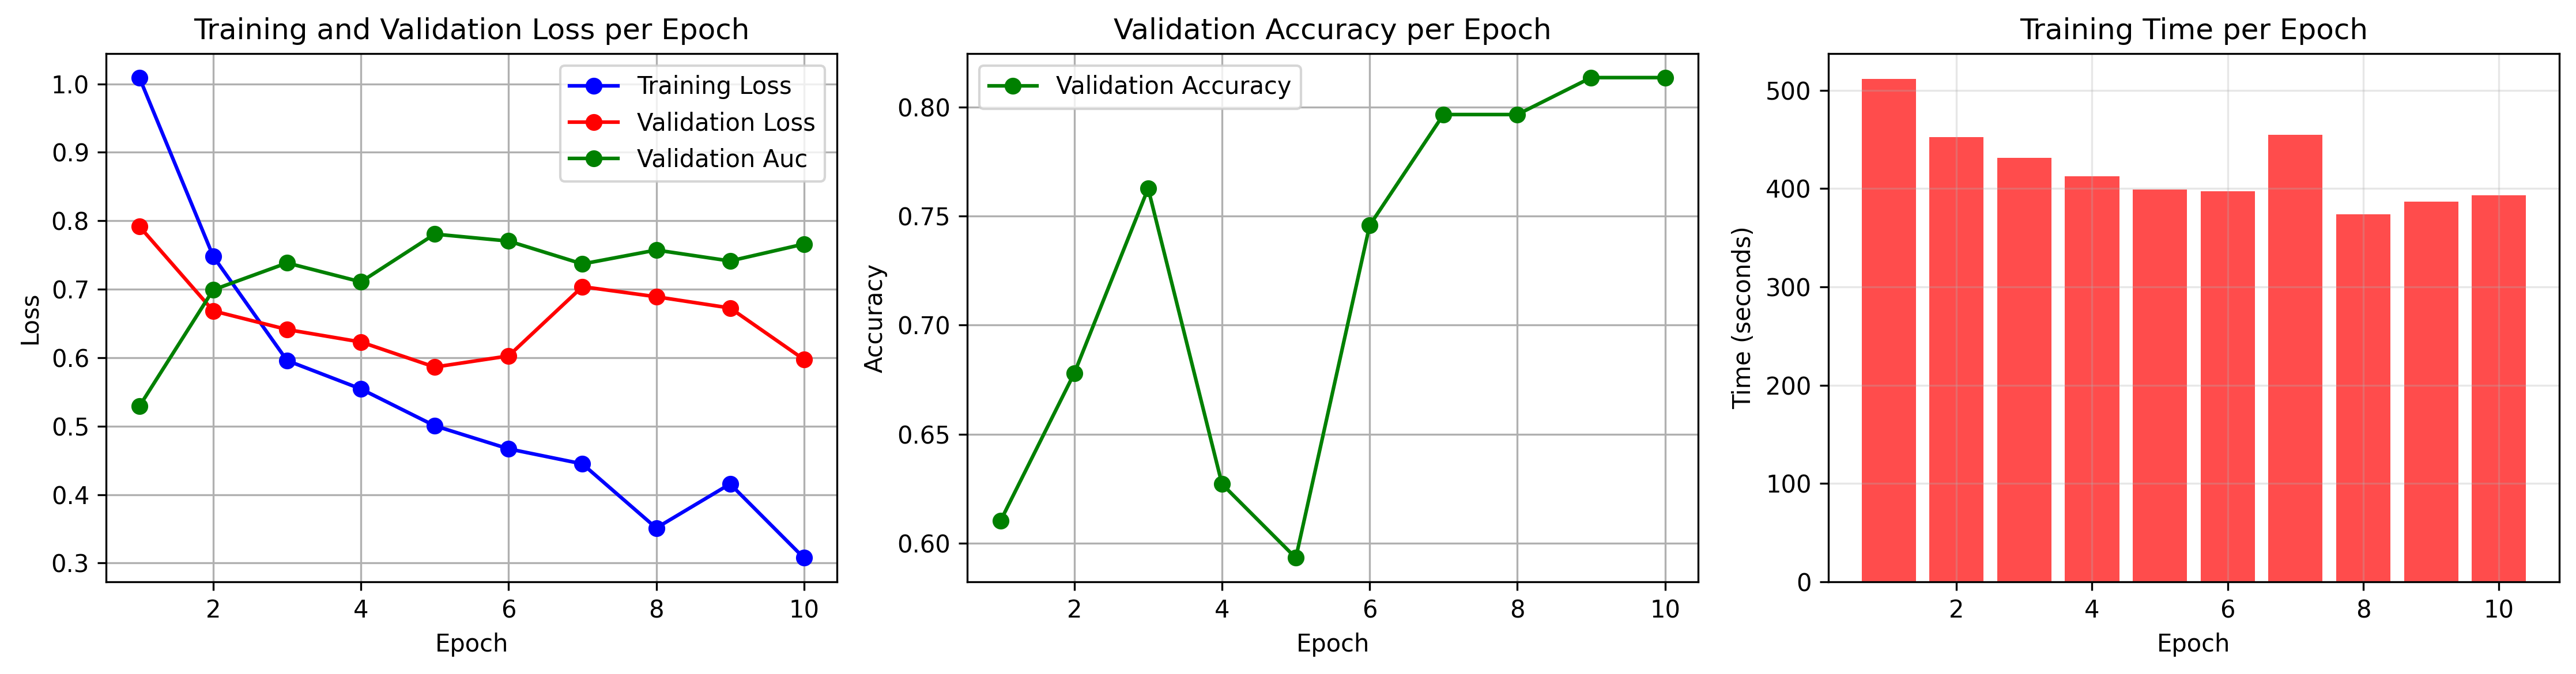


Total training time: 4213.01s

Training completed.
Ensured checkpoint directory exists: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_large_l16_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_large_l16_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_large_l16_mixup


In [ ]:

checkpoint = BASE_DIR / "models/checkpoints_main/PEFT_dino_large_l16_mixup"

dino_v2_large_l16_mix, history = train_peft_pipeline(
    model_name="facebook/dinov2-large",
    lora_config=lora_config_16,
    train_df=ddi_X_train,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    checkpoint_dir=checkpoint,
    label_col="malignant",
    lr=1e-4,
    epochs=20,
    batch_size=32,
    mix_up=True,
    early_stopping_patience=5,
    device=device
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating: 100%|██████████| 1/1 [00:17<00:00, 17.42s/it]


--- Overall Metrics ---
accuracy: 0.7727
precision: 0.7873
recall: 0.7727
f1: 0.7784
auc: 0.7707
inference_time: 0.2639

--- FST Analysis (I-II and V-VI) ---

--- FST Group: I-II ---
Samples: 21
  AUC: 0.7000
  Accuracy: 0.7143
  Precision (weighted): 0.7551
  Recall (weighted): 0.7143
  F1-score (weighted): 0.7286

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.8250
  Accuracy: 0.7619
  Precision (weighted): 0.7794
  Recall (weighted): 0.7619
  F1-score (weighted): 0.7689


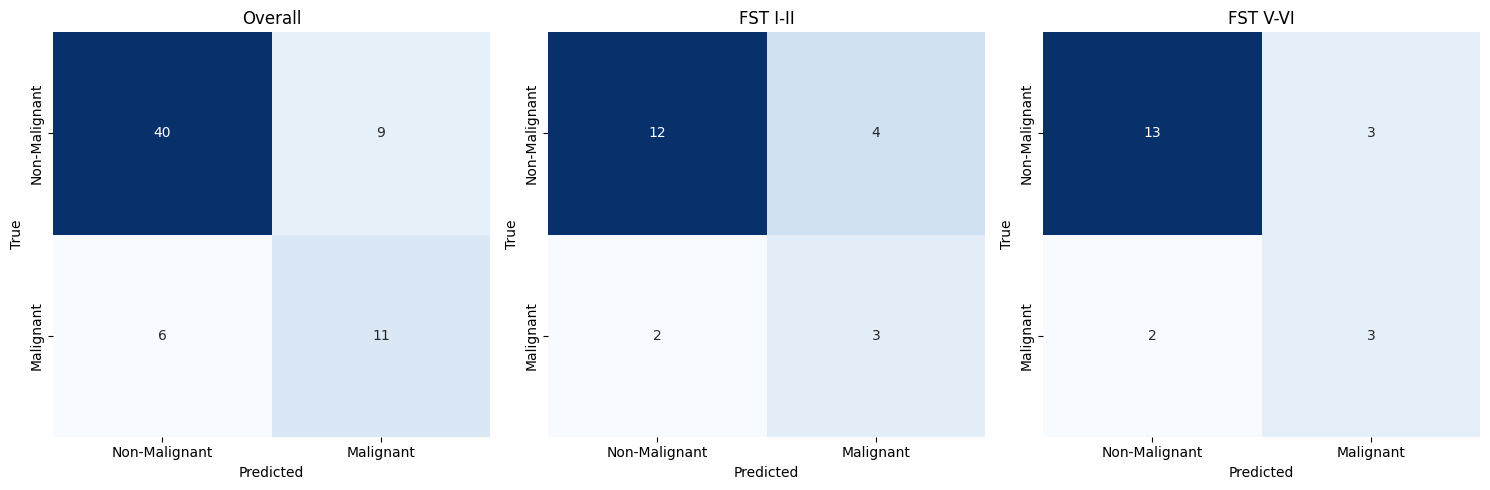

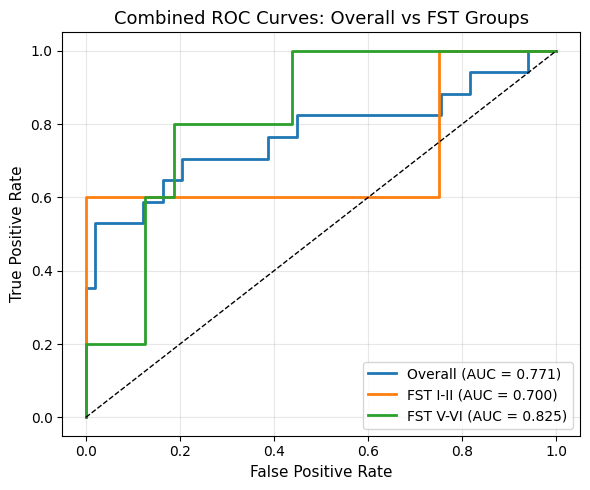

In [ ]:
# Load the PEFT model from checkpoint
checkpoint_dir = BASE_DIR / "models/checkpoints_main/PEFT_dino_large_l16_mixup"


dino_v2_large_l16_mix, dino_v2_large_l16_history, dino_v2_large_l16_fst = evaluate_peft_model_pipeline(
    model_name_large,
    checkpoint_dir)

### RANK 32

#### DINO V2 SMALL


Loading pre-trained model: facebook/dinov2-small


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.
trainable params: 1,181,186 || all params: 23,239,300 || trainable%: 5.0827
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20


  Training Epoch 1: 100%|██████████| 17/17 [01:03<00:00,  3.71s/it, loss=0.683]


  End of Epoch 1 | Train Loss: 0.6829 | Time: 63.15s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]




 ----- Validation Metrics (Epoch 1) ----- 
Train Loss:    0.6829
Val Loss:      0.5413
Val Accuracy:  0.7458
Val Precision: 0.7156
Val Recall:    0.7458
Val F1-score:  0.7081
Val AUC:       0.6657
Inference time: 2.2199s | Avg per image: 0.03763s
Baseline set: loss=0.5413

Epoch 2/20


  Training Epoch 2: 100%|██████████| 17/17 [01:14<00:00,  4.41s/it, loss=0.448]


  End of Epoch 2 | Train Loss: 0.4484 | Time: 74.92s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]




 ----- Validation Metrics (Epoch 2) ----- 
Train Loss:    0.4484
Val Loss:      0.5518
Val Accuracy:  0.7627
Val Precision: 0.8210
Val Recall:    0.7627
Val F1-score:  0.6870
Val AUC:       0.7180
Inference time: 2.6683s | Avg per image: 0.04523s
No improvement: loss=0.5518 | Patience: 1/5

Epoch 3/20


  Training Epoch 3: 100%|██████████| 17/17 [01:05<00:00,  3.88s/it, loss=0.317]


  End of Epoch 3 | Train Loss: 0.3169 | Time: 65.97s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]




 ----- Validation Metrics (Epoch 3) ----- 
Train Loss:    0.3169
Val Loss:      0.6143
Val Accuracy:  0.7627
Val Precision: 0.8210
Val Recall:    0.7627
Val F1-score:  0.6870
Val AUC:       0.7282
Inference time: 2.4377s | Avg per image: 0.04132s
No improvement: loss=0.6143 | Patience: 2/5

Epoch 4/20


  Training Epoch 4: 100%|██████████| 17/17 [01:06<00:00,  3.89s/it, loss=0.247]


  End of Epoch 4 | Train Loss: 0.2466 | Time: 66.13s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]




 ----- Validation Metrics (Epoch 4) ----- 
Train Loss:    0.2466
Val Loss:      0.5879
Val Accuracy:  0.7627
Val Precision: 0.8210
Val Recall:    0.7627
Val F1-score:  0.6870
Val AUC:       0.7544
Inference time: 2.5184s | Avg per image: 0.04268s
No improvement: loss=0.5879 | Patience: 3/5

Epoch 5/20


  Training Epoch 5: 100%|██████████| 17/17 [01:06<00:00,  3.89s/it, loss=0.225]


  End of Epoch 5 | Train Loss: 0.2252 | Time: 66.12s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]




 ----- Validation Metrics (Epoch 5) ----- 
Train Loss:    0.2252
Val Loss:      0.5018
Val Accuracy:  0.8136
Val Precision: 0.8057
Val Recall:    0.8136
Val F1-score:  0.8071
Val AUC:       0.7645
Inference time: 2.4003s | Avg per image: 0.04068s
Improved: loss=0.5018 (best so far)

Epoch 6/20


  Training Epoch 6: 100%|██████████| 17/17 [01:06<00:00,  3.93s/it, loss=0.193]


  End of Epoch 6 | Train Loss: 0.1926 | Time: 66.83s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]




 ----- Validation Metrics (Epoch 6) ----- 
Train Loss:    0.1926
Val Loss:      0.5317
Val Accuracy:  0.7966
Val Precision: 0.8057
Val Recall:    0.7966
Val F1-score:  0.8002
Val AUC:       0.7573
Inference time: 2.4136s | Avg per image: 0.04091s
No improvement: loss=0.5317 | Patience: 1/5

Epoch 7/20


  Training Epoch 7: 100%|██████████| 17/17 [01:07<00:00,  3.95s/it, loss=0.154]


  End of Epoch 7 | Train Loss: 0.1540 | Time: 67.23s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]




 ----- Validation Metrics (Epoch 7) ----- 
Train Loss:    0.1540
Val Loss:      0.5008
Val Accuracy:  0.7966
Val Precision: 0.7848
Val Recall:    0.7966
Val F1-score:  0.7798
Val AUC:       0.7951
Inference time: 2.8156s | Avg per image: 0.04772s
No improvement: loss=0.5008 | Patience: 2/5

Epoch 8/20


  Training Epoch 8: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it, loss=0.158]


  End of Epoch 8 | Train Loss: 0.1581 | Time: 68.74s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]




 ----- Validation Metrics (Epoch 8) ----- 
Train Loss:    0.1581
Val Loss:      0.5280
Val Accuracy:  0.7627
Val Precision: 0.7446
Val Recall:    0.7627
Val F1-score:  0.7211
Val AUC:       0.8038
Inference time: 2.6858s | Avg per image: 0.04552s
No improvement: loss=0.5280 | Patience: 3/5

Epoch 9/20


  Training Epoch 9: 100%|██████████| 17/17 [01:09<00:00,  4.09s/it, loss=0.154]


  End of Epoch 9 | Train Loss: 0.1538 | Time: 69.56s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]




 ----- Validation Metrics (Epoch 9) ----- 
Train Loss:    0.1538
Val Loss:      0.5057
Val Accuracy:  0.8136
Val Precision: 0.8046
Val Recall:    0.8136
Val F1-score:  0.8014
Val AUC:       0.7994
Inference time: 2.6035s | Avg per image: 0.04413s
No improvement: loss=0.5057 | Patience: 4/5

Epoch 10/20


  Training Epoch 10: 100%|██████████| 17/17 [01:07<00:00,  3.96s/it, loss=0.175]


  End of Epoch 10 | Train Loss: 0.1753 | Time: 67.29s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]




 ----- Validation Metrics (Epoch 10) ----- 
Train Loss:    0.1753
Val Loss:      0.5465
Val Accuracy:  0.7797
Val Precision: 0.7838
Val Recall:    0.7797
Val F1-score:  0.7344
Val AUC:       0.7951
Inference time: 2.5624s | Avg per image: 0.04343s
No improvement: loss=0.5465 | Patience: 5/5

 EARLY STOPPING TRIGGERED!
   Best loss=0.5018 at Epoch 5
   No improvement for 5 consecutive epochs

   Model restored to best state (Epoch 5)

   Model restored to best state (Epoch 5)



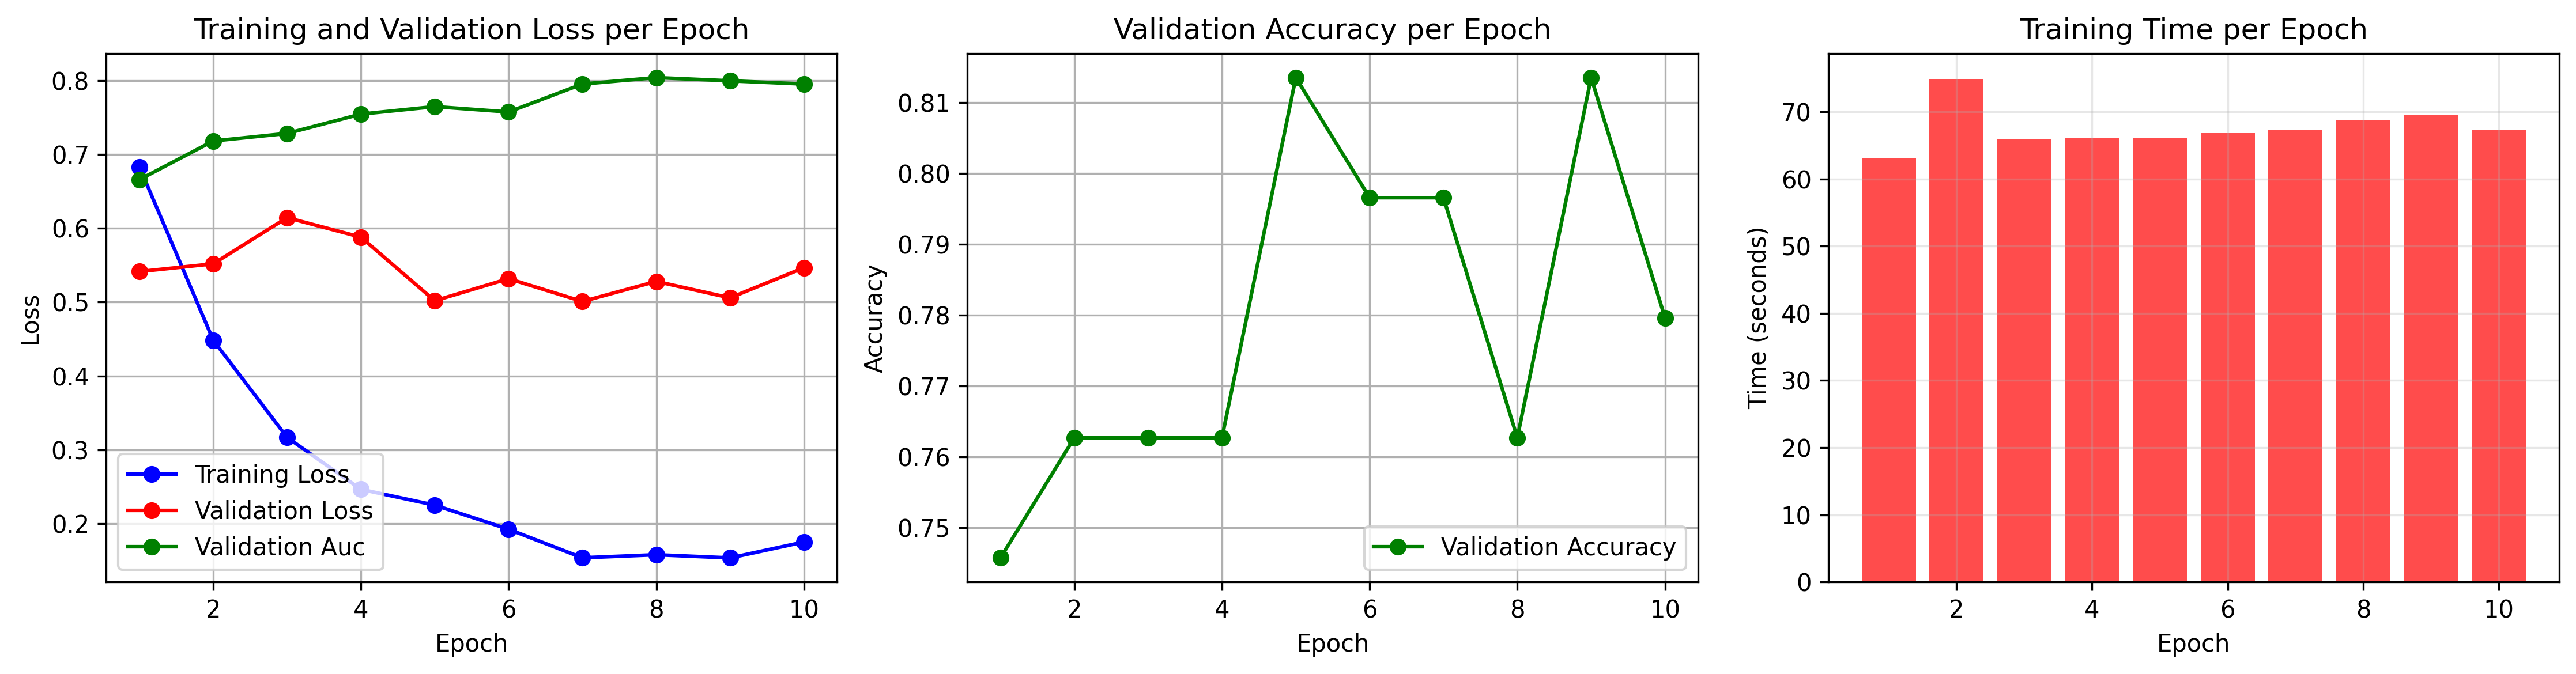


Total training time: 675.94s

Training completed.
Ensured checkpoint directory exists: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l32_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l32_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l32_mixup


In [ ]:

checkpoint = BASE_DIR / "models/checkpoints_main/PEFT_dino_small_l32_mixup"

dino_v2_small_l32_mix, history = train_peft_pipeline(
    model_name="facebook/dinov2-small",
    lora_config=lora_config_32,
    train_df=ddi_X_train,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    checkpoint_dir=checkpoint,
    label_col="malignant",
    lr=1e-4,
    epochs=20,
    batch_size=32,
    early_stopping_patience=5,
    mix_up=True,
    device=torch.device("cpu")
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


--- Overall Metrics ---
accuracy: 0.7727
precision: 0.7533
recall: 0.7727
f1: 0.7298
auc: 0.7095
inference_time: 0.0344

--- FST Analysis (I-II and V-VI) ---

--- FST Group: I-II ---
Samples: 21
  AUC: 0.7375
  Accuracy: 0.8095
  Precision (weighted): 0.8476
  Recall (weighted): 0.8095
  F1-score (weighted): 0.7566

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.4375
  Accuracy: 0.7143
  Precision (weighted): 0.5714
  Recall (weighted): 0.7143
  F1-score (weighted): 0.6349


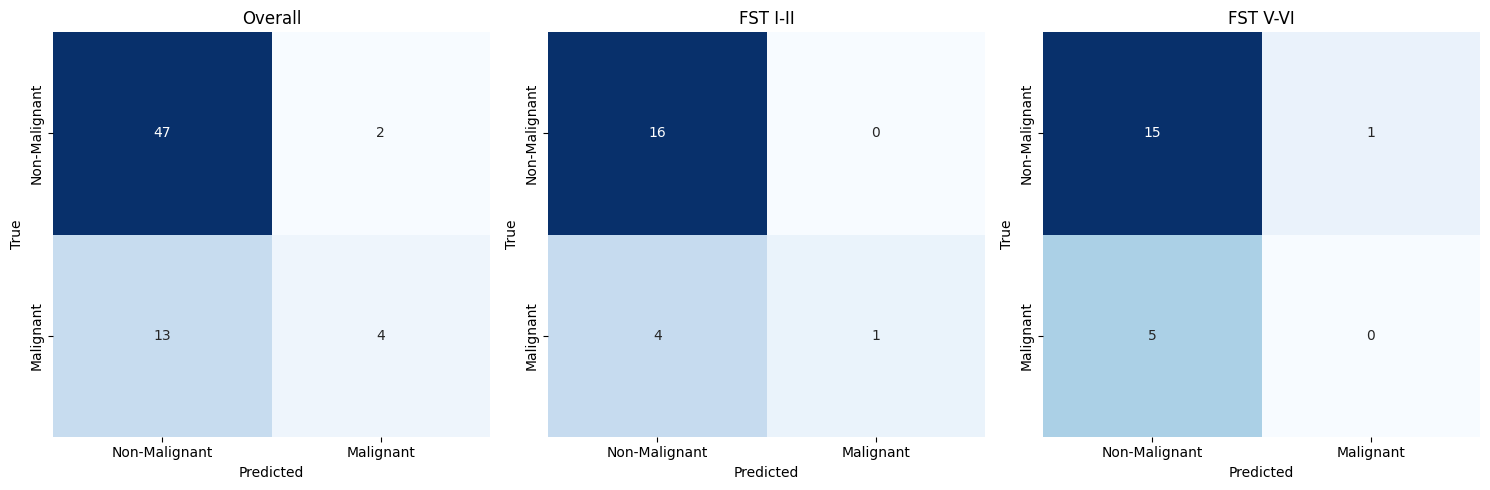

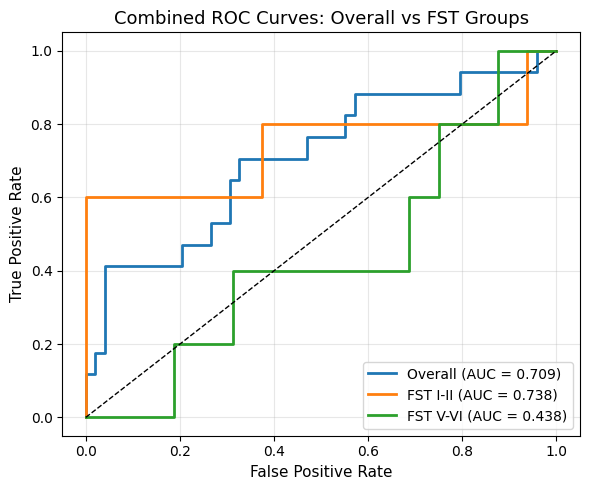

In [880]:
# Load the PEFT model from checkpoint
checkpoint_dir = "/Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_small_l32_mixup"

dino_v2_small_l32_mix, dino_v2_small_l32_mix_history, dino_v2_small_l32_mix_fst = evaluate_peft_model_pipeline(
    model_name_small,
    checkpoint_dir)

#### DINO V2 BASE

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading pre-trained model: facebook/dinov2-base
Model loaded successfully.
trainable params: 2,362,370 || all params: 88,945,924 || trainable%: 2.6560
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20
trainable params: 2,362,370 || all params: 88,945,924 || trainable%: 2.6560
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20


  Training Epoch 1: 100%|██████████| 17/17 [02:09<00:00,  7.61s/it, loss=0.859]


  End of Epoch 1 | Train Loss: 0.8585 | Time: 129.33s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]




 ----- Validation Metrics (Epoch 1) ----- 
Train Loss:    0.8585
Val Loss:      0.6929
Val Accuracy:  0.4407
Val Precision: 0.6741
Val Recall:    0.4407
Val F1-score:  0.4407
Val AUC:       0.7297
Inference time: 4.5959s | Avg per image: 0.0779s
Baseline set: loss=0.6929

Epoch 2/20


  Training Epoch 2: 100%|██████████| 17/17 [02:02<00:00,  7.19s/it, loss=0.639]


  End of Epoch 2 | Train Loss: 0.6393 | Time: 122.24s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]




 ----- Validation Metrics (Epoch 2) ----- 
Train Loss:    0.6393
Val Loss:      0.6733
Val Accuracy:  0.5254
Val Precision: 0.7828
Val Recall:    0.5254
Val F1-score:  0.5290
Val AUC:       0.7747
Inference time: 4.5985s | Avg per image: 0.07794s
Improved: loss=0.6733 (best so far)

Epoch 3/20


  Training Epoch 3: 100%|██████████| 17/17 [02:06<00:00,  7.44s/it, loss=0.49] 


  End of Epoch 3 | Train Loss: 0.4902 | Time: 126.49s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]




 ----- Validation Metrics (Epoch 3) ----- 
Train Loss:    0.4902
Val Loss:      0.5613
Val Accuracy:  0.7119
Val Precision: 0.7429
Val Recall:    0.7119
Val F1-score:  0.7224
Val AUC:       0.7878
Inference time: 4.3140s | Avg per image: 0.07312s
Improved: loss=0.5613 (best so far)

Epoch 4/20


  Training Epoch 4: 100%|██████████| 17/17 [02:01<00:00,  7.17s/it, loss=0.345]


  End of Epoch 4 | Train Loss: 0.3452 | Time: 121.94s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]




 ----- Validation Metrics (Epoch 4) ----- 
Train Loss:    0.3452
Val Loss:      0.5185
Val Accuracy:  0.6780
Val Precision: 0.7410
Val Recall:    0.6780
Val F1-score:  0.6945
Val AUC:       0.8096
Inference time: 4.5445s | Avg per image: 0.07703s
Improved: loss=0.5185 (best so far)

Epoch 5/20


  Training Epoch 5: 100%|██████████| 17/17 [02:06<00:00,  7.47s/it, loss=0.312]


  End of Epoch 5 | Train Loss: 0.3120 | Time: 126.96s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]




 ----- Validation Metrics (Epoch 5) ----- 
Train Loss:    0.3120
Val Loss:      0.5841
Val Accuracy:  0.8136
Val Precision: 0.8102
Val Recall:    0.8136
Val F1-score:  0.8116
Val AUC:       0.7980
Inference time: 4.5467s | Avg per image: 0.07706s
No improvement: loss=0.5841 | Patience: 1/5

Epoch 6/20


  Training Epoch 6: 100%|██████████| 17/17 [02:07<00:00,  7.51s/it, loss=0.182]


  End of Epoch 6 | Train Loss: 0.1819 | Time: 127.73s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]




 ----- Validation Metrics (Epoch 6) ----- 
Train Loss:    0.1819
Val Loss:      0.6551
Val Accuracy:  0.7797
Val Precision: 0.7647
Val Recall:    0.7797
Val F1-score:  0.7653
Val AUC:       0.7805
Inference time: 4.5531s | Avg per image: 0.07717s
No improvement: loss=0.6551 | Patience: 2/5

Epoch 7/20


  Training Epoch 7: 100%|██████████| 17/17 [02:04<00:00,  7.33s/it, loss=0.221]


  End of Epoch 7 | Train Loss: 0.2208 | Time: 124.70s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]




 ----- Validation Metrics (Epoch 7) ----- 
Train Loss:    0.2208
Val Loss:      0.5000
Val Accuracy:  0.7627
Val Precision: 0.7979
Val Recall:    0.7627
Val F1-score:  0.7725
Val AUC:       0.8285
Inference time: 4.5808s | Avg per image: 0.07764s
Improved: loss=0.5000 (best so far)

Epoch 8/20


  Training Epoch 8: 100%|██████████| 17/17 [02:07<00:00,  7.52s/it, loss=0.152]


  End of Epoch 8 | Train Loss: 0.1521 | Time: 127.79s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]




 ----- Validation Metrics (Epoch 8) ----- 
Train Loss:    0.1521
Val Loss:      0.6497
Val Accuracy:  0.8136
Val Precision: 0.8085
Val Recall:    0.8136
Val F1-score:  0.7945
Val AUC:       0.8503
Inference time: 4.5652s | Avg per image: 0.07738s
No improvement: loss=0.6497 | Patience: 1/5

Epoch 9/20


  Training Epoch 9: 100%|██████████| 17/17 [01:52<00:00,  6.64s/it, loss=0.0963]


  End of Epoch 9 | Train Loss: 0.0963 | Time: 112.89s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]




 ----- Validation Metrics (Epoch 9) ----- 
Train Loss:    0.0963
Val Loss:      0.6820
Val Accuracy:  0.7966
Val Precision: 0.7848
Val Recall:    0.7966
Val F1-score:  0.7798
Val AUC:       0.8038
Inference time: 3.6431s | Avg per image: 0.06175s
No improvement: loss=0.6820 | Patience: 2/5

Epoch 10/20


  Training Epoch 10: 100%|██████████| 17/17 [01:50<00:00,  6.50s/it, loss=0.121]


  End of Epoch 10 | Train Loss: 0.1211 | Time: 110.43s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]




 ----- Validation Metrics (Epoch 10) ----- 
Train Loss:    0.1211
Val Loss:      0.6795
Val Accuracy:  0.7966
Val Precision: 0.7848
Val Recall:    0.7966
Val F1-score:  0.7798
Val AUC:       0.8212
Inference time: 4.3616s | Avg per image: 0.07393s
No improvement: loss=0.6795 | Patience: 3/5

Epoch 11/20


  Training Epoch 11: 100%|██████████| 17/17 [02:05<00:00,  7.38s/it, loss=0.176]


  End of Epoch 11 | Train Loss: 0.1759 | Time: 125.47s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]




 ----- Validation Metrics (Epoch 11) ----- 
Train Loss:    0.1759
Val Loss:      0.6896
Val Accuracy:  0.7627
Val Precision: 0.7411
Val Recall:    0.7627
Val F1-score:  0.7333
Val AUC:       0.8256
Inference time: 4.5586s | Avg per image: 0.07726s
No improvement: loss=0.6896 | Patience: 4/5

Epoch 12/20


  Training Epoch 12: 100%|██████████| 17/17 [02:06<00:00,  7.42s/it, loss=0.221]


  End of Epoch 12 | Train Loss: 0.2213 | Time: 126.21s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]




 ----- Validation Metrics (Epoch 12) ----- 
Train Loss:    0.2213
Val Loss:      0.7125
Val Accuracy:  0.7797
Val Precision: 0.7683
Val Recall:    0.7797
Val F1-score:  0.7470
Val AUC:       0.8256
Inference time: 4.3107s | Avg per image: 0.07306s
No improvement: loss=0.7125 | Patience: 5/5

 EARLY STOPPING TRIGGERED!
   Best loss=0.5000 at Epoch 7
   No improvement for 5 consecutive epochs

   Model restored to best state (Epoch 7)

   Model restored to best state (Epoch 7)



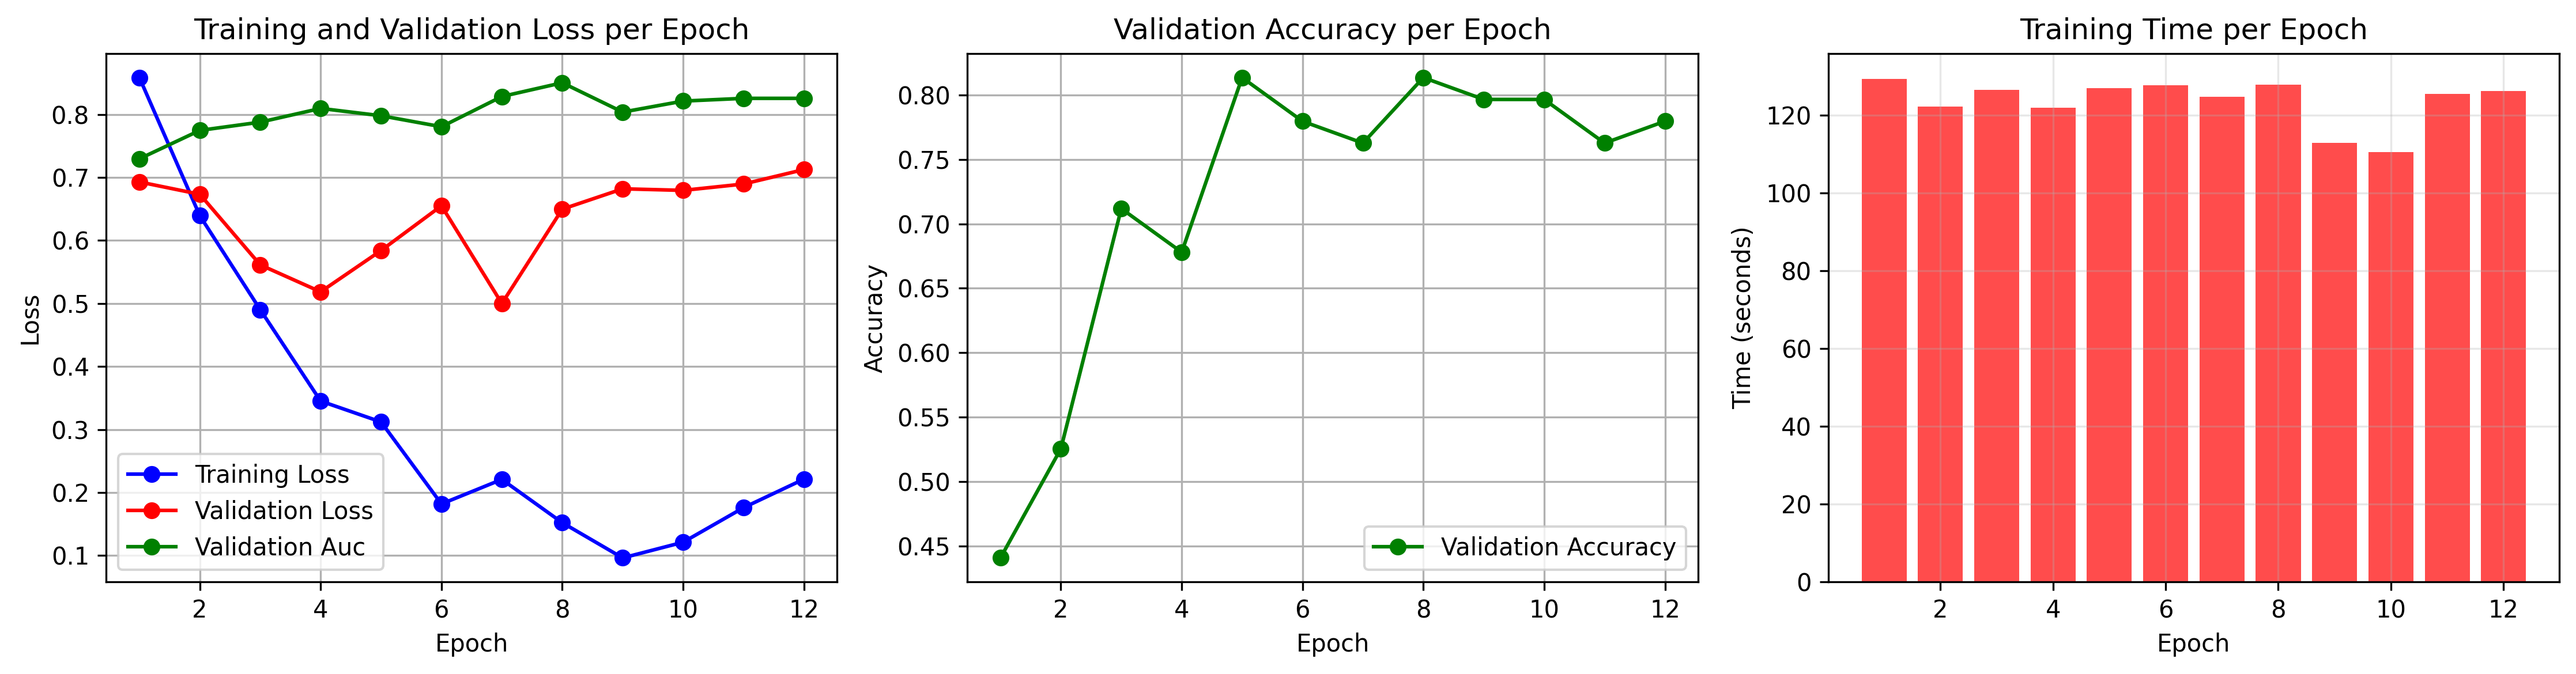


Total training time: 1482.18s

Training completed.
Ensured checkpoint directory exists: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_base_l32_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_base_l32_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_base_l32_mixup


In [ ]:

checkpoint = BASE_DIR / "models/checkpoints_main/PEFT_dino_base_l32_mixup"

dino_v2_base_l32_mix, history = train_peft_pipeline(
    model_name="facebook/dinov2-base",
    lora_config=lora_config_32,
    train_df=ddi_X_train,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    checkpoint_dir=checkpoint,
    label_col="malignant",
    lr=1e-4,
    epochs=20,
    batch_size=32,
    early_stopping_patience=5,
    mix_up=True,
    device=torch.device("cpu")
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating: 100%|██████████| 1/1 [00:07<00:00,  7.89s/it]


--- Overall Metrics ---
accuracy: 0.7576
precision: 0.7292
recall: 0.7576
f1: 0.7294
auc: 0.7023
inference_time: 0.1195

--- FST Analysis (I-II and V-VI) ---

--- FST Group: I-II ---
Samples: 21
  AUC: 0.7125
  Accuracy: 0.8571
  Precision (weighted): 0.8797
  Recall (weighted): 0.8571
  F1-score (weighted): 0.8327

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.6375
  Accuracy: 0.6667
  Precision (weighted): 0.6422
  Recall (weighted): 0.6667
  F1-score (weighted): 0.6532


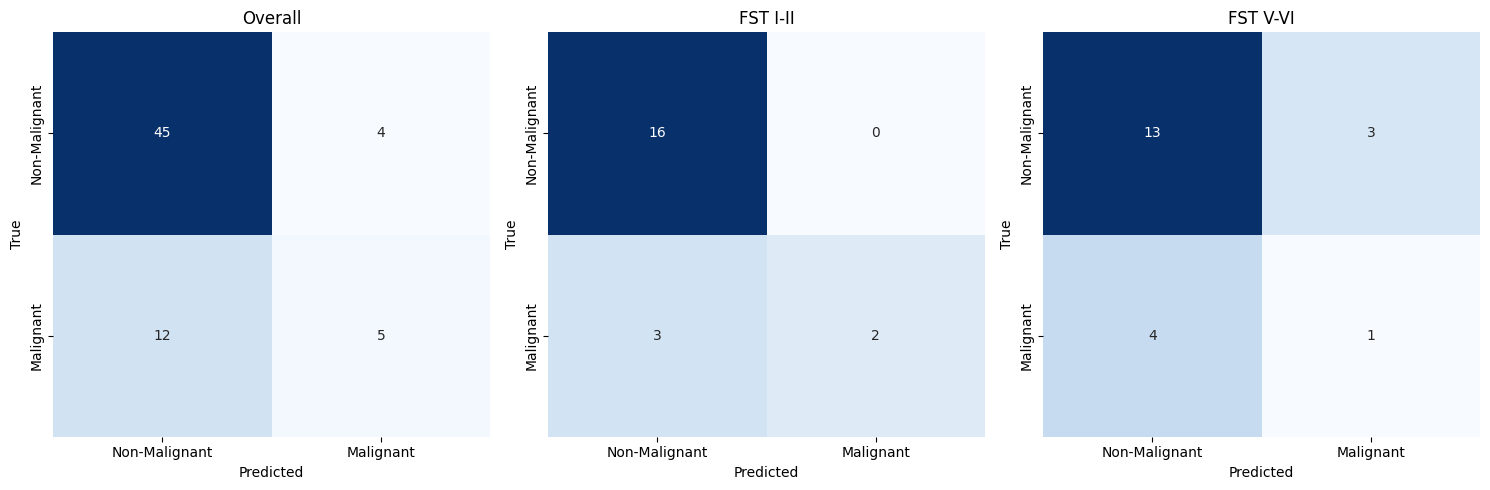

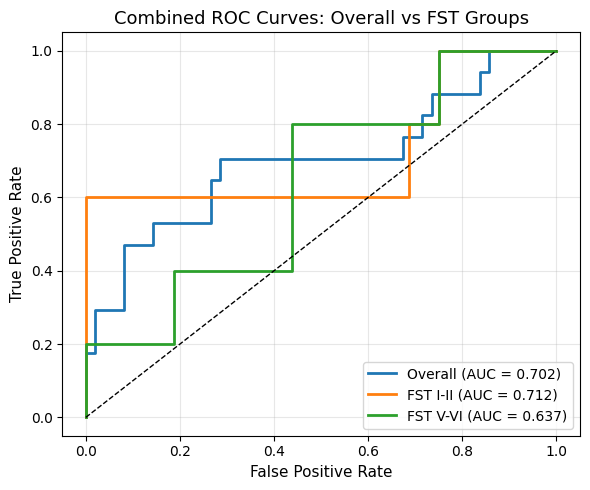

In [ ]:
# Load the PEFT model from checkpoint
checkpoint_dir = BASE_DIR / "models/checkpoints_main/PEFT_dino_base_l32_mixup"

dino_v2_base_l32_mix, dino_v2_base_l32_history, dino_v2_base_l32_fst = evaluate_peft_model_pipeline(
    model_name_base,
    checkpoint_dir)

#### DINO V2 LARGE


Loading pre-trained model: facebook/dinov2-large


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /facebook/dinov2-large/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x17d0f7e90>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 3c582041-348e-422c-817d-0e71d74ad5bb)')' thrown while requesting HEAD https://huggingface.co/facebook/dinov2-large/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Retrying in 1s [Retry 1/5].
Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['clas

Model loaded successfully.
trainable params: 6,295,554 || all params: 310,668,292 || trainable%: 2.0265
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20
trainable params: 6,295,554 || all params: 310,668,292 || trainable%: 2.0265
Using device: cpu
PEFT model moved to device.
Optimizer (AdamW) defined.
Learning rate scheduler defined with 340 total iterations.
Training for 20 epochs, batch_size=32, lr=0.0001
Starting training for up to 20 epochs on cpu...
Early stopping: Metric=loss, Patience=5, Min_delta=0.001


Epoch 1/20


  Training Epoch 1: 100%|██████████| 17/17 [06:55<00:00, 24.45s/it, loss=0.792]



  End of Epoch 1 | Train Loss: 0.7918 | Time: 415.62s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.94s/it]




 ----- Validation Metrics (Epoch 1) ----- 
Train Loss:    0.7918
Val Loss:      0.8136
Val Accuracy:  0.6780
Val Precision: 0.7108
Val Recall:    0.6780
Val F1-score:  0.6898
Val AUC:       0.5552
Inference time: 11.8900s | Avg per image: 0.20152s
Baseline set: loss=0.8136

Epoch 2/20


  Training Epoch 2: 100%|██████████| 17/17 [06:53<00:00, 24.34s/it, loss=0.652]



  End of Epoch 2 | Train Loss: 0.6521 | Time: 413.77s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.92s/it]




 ----- Validation Metrics (Epoch 2) ----- 
Train Loss:    0.6521
Val Loss:      0.7895
Val Accuracy:  0.7288
Val Precision: 0.7093
Val Recall:    0.7288
Val F1-score:  0.7155
Val AUC:       0.6584
Inference time: 11.8535s | Avg per image: 0.20091s
Improved: loss=0.7895 (best so far)

Epoch 3/20


  Training Epoch 3: 100%|██████████| 17/17 [06:43<00:00, 23.73s/it, loss=0.574]



  End of Epoch 3 | Train Loss: 0.5735 | Time: 403.42s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.78s/it]




 ----- Validation Metrics (Epoch 3) ----- 
Train Loss:    0.5735
Val Loss:      0.6888
Val Accuracy:  0.7458
Val Precision: 0.7622
Val Recall:    0.7458
Val F1-score:  0.7521
Val AUC:       0.6919
Inference time: 11.5575s | Avg per image: 0.19589s
Improved: loss=0.6888 (best so far)

Epoch 4/20


  Training Epoch 4: 100%|██████████| 17/17 [06:50<00:00, 24.14s/it, loss=0.519]



  End of Epoch 4 | Train Loss: 0.5185 | Time: 410.40s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.87s/it]




 ----- Validation Metrics (Epoch 4) ----- 
Train Loss:    0.5185
Val Loss:      0.6579
Val Accuracy:  0.6949
Val Precision: 0.7656
Val Recall:    0.6949
Val F1-score:  0.7112
Val AUC:       0.7384
Inference time: 11.7352s | Avg per image: 0.1989s
Improved: loss=0.6579 (best so far)

Epoch 5/20


  Training Epoch 5: 100%|██████████| 17/17 [07:03<00:00, 24.94s/it, loss=0.41] 



  End of Epoch 5 | Train Loss: 0.4098 | Time: 423.92s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]




 ----- Validation Metrics (Epoch 5) ----- 
Train Loss:    0.4098
Val Loss:      0.6590
Val Accuracy:  0.7627
Val Precision: 0.7845
Val Recall:    0.7627
Val F1-score:  0.7701
Val AUC:       0.7195
Inference time: 11.6646s | Avg per image: 0.19771s
No improvement: loss=0.6590 | Patience: 1/5

Epoch 6/20


  Training Epoch 6: 100%|██████████| 17/17 [06:42<00:00, 23.68s/it, loss=0.378]



  End of Epoch 6 | Train Loss: 0.3784 | Time: 402.55s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]




 ----- Validation Metrics (Epoch 6) ----- 
Train Loss:    0.3784
Val Loss:      0.7137
Val Accuracy:  0.7797
Val Precision: 0.7842
Val Recall:    0.7797
Val F1-score:  0.7817
Val AUC:       0.7515
Inference time: 11.6468s | Avg per image: 0.1974s
No improvement: loss=0.7137 | Patience: 2/5

Epoch 7/20


  Training Epoch 7: 100%|██████████| 17/17 [06:40<00:00, 23.55s/it, loss=0.302]



  End of Epoch 7 | Train Loss: 0.3016 | Time: 400.31s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:11<00:00,  5.78s/it]




 ----- Validation Metrics (Epoch 7) ----- 
Train Loss:    0.3016
Val Loss:      0.8569
Val Accuracy:  0.7797
Val Precision: 0.7647
Val Recall:    0.7797
Val F1-score:  0.7653
Val AUC:       0.7674
Inference time: 11.5581s | Avg per image: 0.1959s
No improvement: loss=0.8569 | Patience: 3/5

Epoch 8/20


  Training Epoch 8: 100%|██████████| 17/17 [07:15<00:00, 25.61s/it, loss=0.267]



  End of Epoch 8 | Train Loss: 0.2673 | Time: 435.31s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:12<00:00,  6.02s/it]




 ----- Validation Metrics (Epoch 8) ----- 
Train Loss:    0.2673
Val Loss:      0.7309
Val Accuracy:  0.8305
Val Precision: 0.8305
Val Recall:    0.8305
Val F1-score:  0.8305
Val AUC:       0.7776
Inference time: 12.0480s | Avg per image: 0.2042s
No improvement: loss=0.7309 | Patience: 4/5

Epoch 9/20


  Training Epoch 9: 100%|██████████| 17/17 [07:07<00:00, 25.14s/it, loss=0.271]



  End of Epoch 9 | Train Loss: 0.2707 | Time: 427.44s
  Evaluating on Validation set...


  Evaluating Model: 100%|██████████| 2/2 [00:12<00:00,  6.21s/it]




 ----- Validation Metrics (Epoch 9) ----- 
Train Loss:    0.2707
Val Loss:      0.8257
Val Accuracy:  0.8136
Val Precision: 0.8046
Val Recall:    0.8136
Val F1-score:  0.8014
Val AUC:       0.7805
Inference time: 12.4297s | Avg per image: 0.21067s
No improvement: loss=0.8257 | Patience: 5/5

 EARLY STOPPING TRIGGERED!
   Best loss=0.6579 at Epoch 4
   No improvement for 5 consecutive epochs

   Model restored to best state (Epoch 4)

   Model restored to best state (Epoch 4)



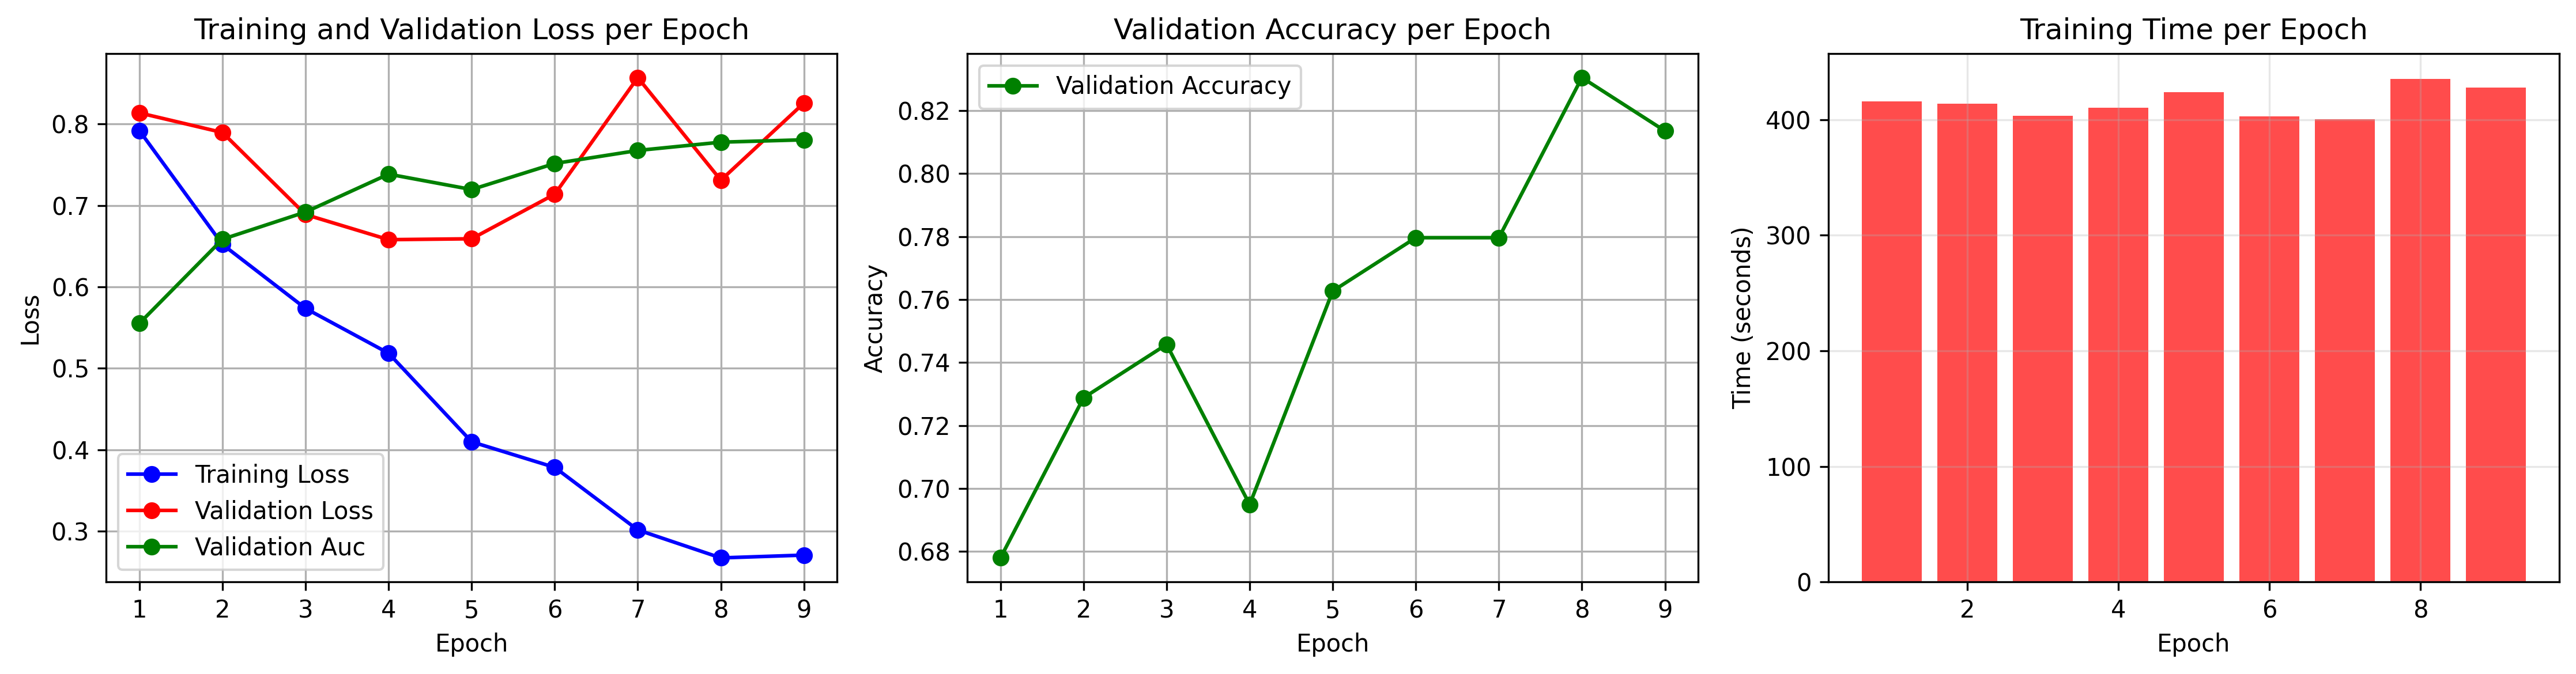


Total training time: 3732.74s

Training completed.
Ensured checkpoint directory exists: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_large_l32_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_large_l32_mixup

PEFT model checkpoint saved to: /Users/okundiakessy/Documents/All-things-Python/Thesis/Skin_Cancer_Detection/models/checkpoints_main/PEFT_dino_large_l32_mixup


In [ ]:

checkpoint = BASE_DIR / "models/checkpoints_main/PEFT_dino_large_l32_mixup"

dino_v2_large_l32_mix, history = train_peft_pipeline(
    model_name="facebook/dinov2-large",
    lora_config=lora_config_32,
    train_df=ddi_X_train,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    checkpoint_dir=checkpoint,
    label_col="malignant",
    lr=1e-4,
    epochs=20,
    batch_size=32,
    mix_up=True,
    early_stopping_patience=5,
    device=device
)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating: 100%|██████████| 1/1 [00:15<00:00, 15.13s/it]


--- Overall Metrics ---
accuracy: 0.8030
precision: 0.7938
recall: 0.8030
f1: 0.7964
auc: 0.7563
inference_time: 0.2293

--- FST Analysis (I-II and V-VI) ---

--- FST Group: I-II ---
Samples: 21
  AUC: 0.7750
  Accuracy: 0.8571
  Precision (weighted): 0.8508
  Recall (weighted): 0.8571
  F1-score (weighted): 0.8514

--- FST Group: V-VI ---
Samples: 21
  AUC: 0.7875
  Accuracy: 0.8095
  Precision (weighted): 0.7937
  Recall (weighted): 0.8095
  F1-score (weighted): 0.7913


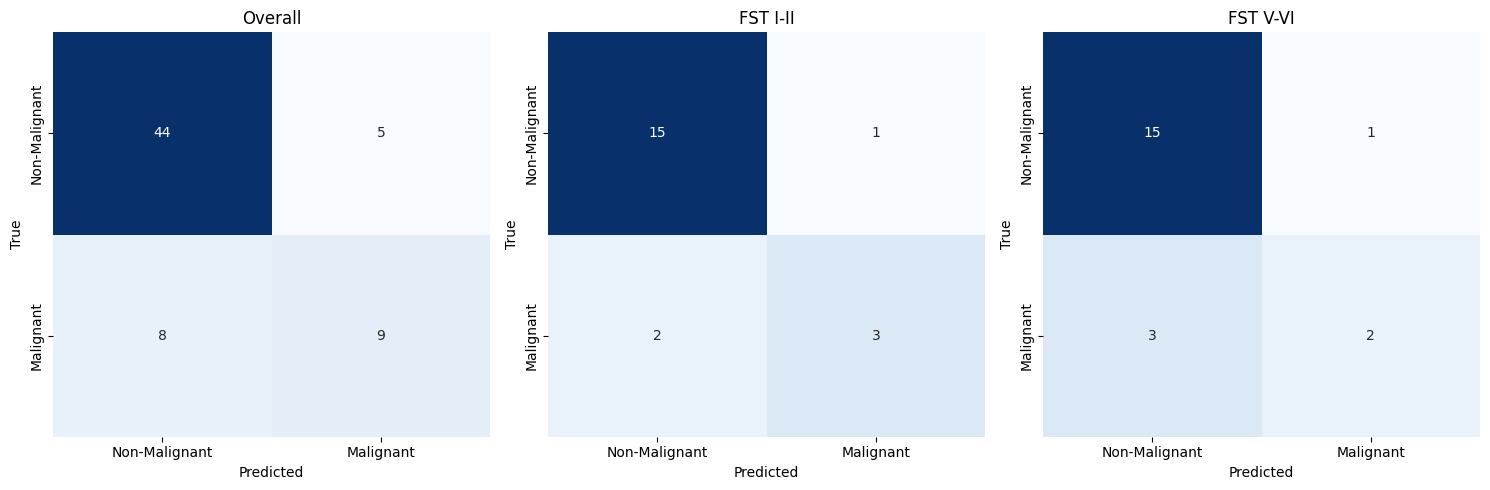

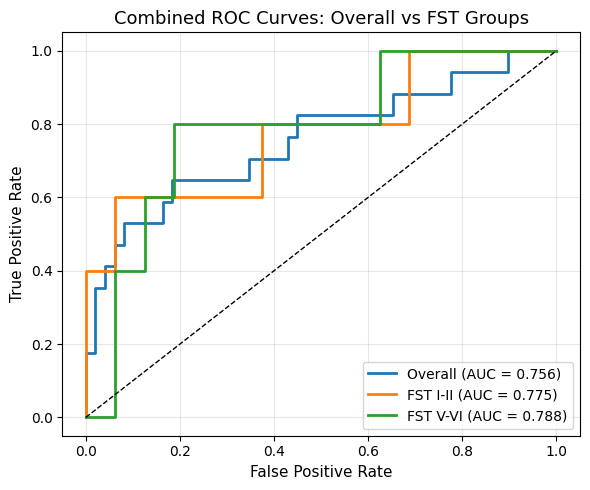

In [ ]:
# Load the PEFT model from checkpoint
checkpoint_dir = BASE_DIR / "models/checkpoints_main/PEFT_dino_large_l32_mixup"

dino_v2_large_l32_mix, dino_v2_large_l32_history, dino_v2_large_l32_fst = evaluate_peft_model_pipeline(
    model_name_large,
    checkpoint_dir)

##### Observations:

The results across all LoRA configurations demonstrate that low-rank adaptation can effectively improve both overall performance and fairness across skin tone subgroups, with consistent trends observed across model sizes. For DINOv2-Small, LoRA fine-tuning leads to improved balance between Fitzpatrick subgroups, with rank 8 achieving the smallest AUC disparity while maintaining competitive overall recall and the lowest average inference time. Increasing the rank beyond 8 does not yield further fairness improvements and, in some cases, introduces larger subgroup disparities despite marginal gains in recall.

For DINOv2-Base, the rank 8 configuration provides the best trade-off between performance and fairness, achieving strong overall AUC and recall while substantially reducing both AUC and recall gaps between FST I–II and FST V–VI. Higher ranks increase adaptation capacity but do not consistently improve subgroup balance and incur higher computational cost, particularly in training and inference time.

DINOv2-Large exhibits strong overall performance across all ranks, with rank 8 completely eliminating the AUC gap between skin tone subgroups. However, this comes at a higher computational cost compared to smaller backbones. Rank 16 and rank 32 maintain low fairness gaps for recall but do not consistently outperform rank 8 in terms of overall efficiency.

Overall, these results indicate that modest LoRA ranks are sufficient to achieve substantial fairness gains across skin tone subgroups, and that increasing adapter rank beyond this point yields diminishing returns in both performance and fairness. This highlights the effectiveness of low-rank adaptation as a practical and computationally efficient approach for mitigating skin tone–related performance disparities in dermatological image analysis.

## BEST MODEL RESULTS AND EXPLAINABILITY

In this section, we present the results for the best-performing model configuration, namely the DINOv2-Base model fine-tuned with Low-Rank Adaptation at rank 8. We first examine the quantitative performance of this configuration, including overall metrics and skin tone–stratified results, to assess both predictive accuracy and fairness. These results are then complemented with qualitative analysis using Gradient-weighted Class Activation Mapping (Grad-CAM), which visualises the regions of the input images that most strongly influence the model’s predictions. By combining metric-based evaluation with attention map visualisation, this section provides a holistic assessment of model behaviour, highlighting not only performance improvements achieved through LoRA fine-tuning but also the interpretability and reliability of the learned representations.

In [1043]:
def plot_model_comparison(
    model1_results,
    model2_results,
    model1_name="Model 1",
    model2_name="Model 2",
    metric="auc", 
    model_name=None
):
    import numpy as np
    import matplotlib.pyplot as plt

    # Validate metric
    metric = metric.lower()

    groups = ["Overall", "FST I-II", "FST V-VI"]

    # Extract values
    m1_vals = [
        model1_results["overall"][metric],
        model1_results["fst"]["I-II"][metric],
        model1_results["fst"]["V-VI"][metric],
    ]

    m2_vals = [
        model2_results["overall"][metric],
        model2_results["fst"]["I-II"][metric],
        model2_results["fst"]["V-VI"][metric],
    ]

    x = np.arange(len(groups))
    width = 0.35

    # FST group color scheme
    overall_color = "gray"
    fst_light_brown = "#C19A6B"   # I-II
    fst_dark_brown = "#8B4513"    # V-VI

    group_colors = [
        overall_color,
        fst_light_brown,
        fst_dark_brown
    ]

    plt.figure(figsize=(8, 4))

    # Model 1 bars (left)
    for i in range(len(groups)):
        bar = plt.bar(
            x[i] - width/2,
            m1_vals[i],
            width,
            color=group_colors[i],
            edgecolor="black"
        )
        plt.text(
            x[i] - width/2,
            m1_vals[i] + 0.02,
            f"{model1_name}\n{m1_vals[i]:.3f}",
            ha="center", va="bottom",
            fontsize=8, fontweight="bold",
            rotation=45
        )

    # Model 2 bars (right)
    for i in range(len(groups)):
        bar = plt.bar(
            x[i] + width/2,
            m2_vals[i],
            width,
            color=group_colors[i],
            edgecolor="black"
        )
        plt.text(
            x[i] + width/2,
            m2_vals[i] + 0.02,
            f"{model2_name}\n{m2_vals[i]:.3f}",
            ha="center", va="bottom",
            fontsize=8, fontweight="bold",
            rotation=45
        )

    # Labels & formatting
    plt.xticks(x, groups, fontsize=12)
    plt.ylabel(metric.upper(), fontsize=14)
    plt.title(f"Comparison of {model_name} {metric.upper()} score accross FST I-II and FST V-VI", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.ylim(0, 1.15)
    plt.tight_layout()
    plt.show()

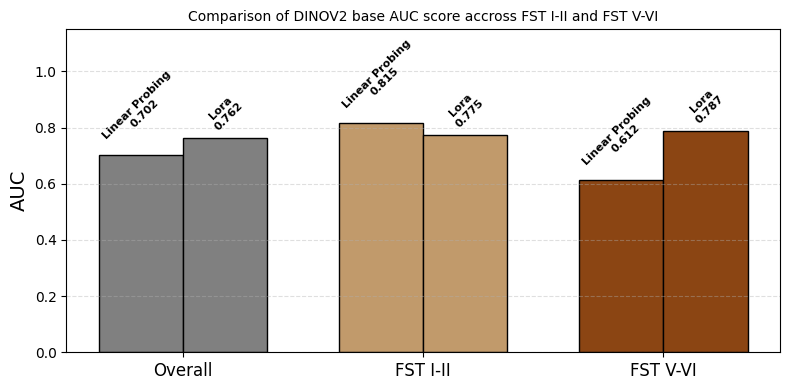

In [1041]:
plot_model_comparison(
    model1_results={"overall": dino_v2_base_overall_metrics, "fst": dino_v2_base_overall_fst_metrics},
    model2_results={"overall": dino_v2_base_l8_history, "fst": dino_v2_base_l8_fst},
    model1_name="Linear Probing",
    model2_name="Lora",
    metric="auc",
    model_name="DINOV2 base"
)

##### Observations:

The AUC visualisation highlights a substantial improvement in fairness after applying LoRA fine-tuning. While the linear probe exhibits a pronounced performance disparity between Fitzpatrick skin tone subgroups, with a large AUC gap of 0.2026, the LoRA rank 8 configuration significantly reduces this gap to 0.0125. This reduction is primarily driven by a marked improvement in performance on darker skin tones (FST V–VI), where AUC increases from 0.6122 to 0.7875, without a severe degradation in performance for lighter skin tones (FST I–II). Importantly, this fairness gain is achieved alongside an improvement in overall AUC compared to the linear probe baseline, indicating that LoRA fine-tuning can mitigate subgroup disparities without compromising, and in fact improving, overall model performance.

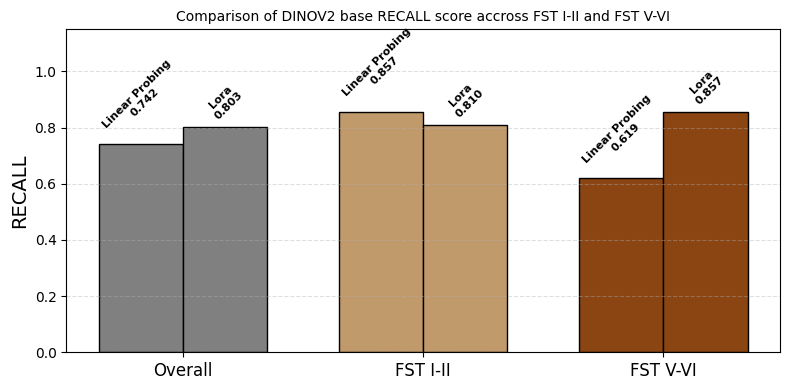

In [1044]:
plot_model_comparison(
    model1_results={"overall": dino_v2_base_overall_metrics, "fst": dino_v2_base_overall_fst_metrics},
    model2_results={"overall": dino_v2_base_l8_history, "fst": dino_v2_base_l8_fst},
    model1_name="Linear Probing",
    model2_name="Lora",
    metric="recall",
    model_name="DINOV2 base"
)

The recall visualisation further demonstrates the fairness benefits of LoRA fine-tuning. The linear probe shows a substantial disparity in sensitivity between skin tone subgroups, with recall dropping from 0.8571 for FST I–II to 0.6190 for FST V–VI, resulting in a large recall gap of 0.2381. In contrast, the LoRA rank 8 configuration markedly reduces this disparity, achieving balanced recall across both subgroups at 0.8095 for FST I–II and 0.8571 for FST V–VI, and reducing the recall gap to 0.0476. Notably, this improvement is driven by a significant increase in sensitivity for darker skin tones without sacrificing overall recall performance, reinforcing the effectiveness of low-rank adaptation in mitigating clinically critical false negatives while maintaining strong model performance.

### EXPLAINABILITY USING GRADIENT BASED CLASS ACTIVATION MAPS
Below, we use Gradient-weighted Class Activation Mapping (Grad-CAM) to analyse and visualise the regions of the input images that contribute most to the predictions of our best-performing model. Grad-CAM provides insight into whether the model focuses on lesion-specific features or is influenced by background artefacts, thereby supporting qualitative assessment of both model performance and reliability. These visualisations complement the quantitative evaluation by offering an interpretable view of the model’s decision-making process and highlighting potential areas for further improvement.

In [1016]:

class DatasetWithDDIFile(torch.utils.data.Dataset):
    """
    Wraps an existing dataset that returns (image, label) and injects DDI_file
    from the dataframe row at the same index.
    """
    def __init__(self, base_dataset, df, file_col="DDI_file"):
        self.base_dataset = base_dataset
        self.df = df.reset_index(drop=True)
        self.file_col = file_col

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        ddi_file = self.df.loc[idx, self.file_col]
        return image, label, ddi_file

wrapped_test_dataset = DatasetWithDDIFile(test_dataset, ddi_X_test, file_col="DDI_file")
eval_test_loader = DataLoader(wrapped_test_dataset, batch_size=32, shuffle=False,)

def evaluate_testset_and_build_df(
    model,
    dataloader,
    device,
    test_df: pd.DataFrame,
    file_col: str = "DDI_file",
):
    """
    Expects dataloader batches in the form: (images, labels, ddi_file)

    Returns:
      - df_out: test_df + [y_pred, proba_score, is_correct, is_wrong, pred_label, true_label]
      - metrics: dict with accuracy/precision/recall/f1/auroc + timing
    """
    model.eval()

    all_files = []
    all_labels = []
    all_preds = []
    all_probs = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels, ddi_files in tqdm(dataloader, desc="Evaluating full test set"):
            images = images.to(device)
            labels = labels.to(device)

            if labels.ndim > 1:
                labels = labels.squeeze()

            logits = model(pixel_values=images).logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            # Maximum probability (confidence) for the predicted class
            max_proba, _ = torch.max(probs, dim=1)

            all_files.extend(list(ddi_files))
            all_labels.extend(labels.detach().cpu().numpy().tolist())
            all_preds.extend(preds.detach().cpu().numpy().tolist())
            all_probs.extend(max_proba.detach().cpu().numpy().tolist())

    end_time = time.time()
    total_inference_time = end_time - start_time
    n = len(all_labels)
    avg_inference_time = (total_inference_time / n) if n > 0 else 0.0

    # Prediction table keyed by DDI_file
    pred_df = pd.DataFrame({
        file_col: all_files,
        "y_true": all_labels,
        "y_pred": all_preds,
        "proba_score": all_probs,
    })

    # Correctness
    pred_df["is_correct"] = pred_df["y_true"] == pred_df["y_pred"]
    pred_df["is_wrong"] = ~pred_df["is_correct"]

    # Human-readable labels (adjust if your coding differs)
    pred_df["pred_label"] = pred_df["y_pred"].map({0: "Benign", 1: "Malignant"})
    pred_df["true_label"] = pred_df["y_true"].map({0: "Benign", 1: "Malignant"})

    # Merge back into original test dataframe
    df_out = test_df.merge(pred_df, on=file_col, how="left")

    # Metrics
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    auroc = np.nan
    if len(np.unique(y_true)) >= 2:
        try:
            auroc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auroc = np.nan

    metrics = {
        "accuracy": float(accuracy),
        "precision_weighted": float(precision),
        "recall_weighted": float(recall),
        "f1_weighted": float(f1),
        "auroc": float(auroc) if not np.isnan(auroc) else np.nan,
        "total_inference_time_sec": float(total_inference_time),
        "avg_inference_time_sec": float(avg_inference_time),
        "n_samples": int(n),
    }

    return df_out, metrics

class ViTGradCAM:
        
        def __init__(self, model, use_cuda=True):
            self.model = model
            self.device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
            self.model.to(self.device)
            self.model.eval()
            
            #Target the last layer
            self.target_layer = self.model.dinov2.encoder.layer[-1] 
            self.gradients = None
            self.activations = None
            
            # Register hooks
            self._register_hooks()

        def _register_hooks(self):
            """Register forward and backward hooks."""
            def forward_hook(module, input, output):
                # For ViT, output is usually a tuple (hidden_states, attentions)
                if isinstance(output, tuple):
                    self.activations = output[0]
                else:
                    self.activations = output
            
            def backward_hook(module, grad_input, grad_output):
                if isinstance(grad_output, tuple):
                    self.gradients = grad_output[0]
                else:
                    self.gradients = grad_output
            
            self.target_layer.register_forward_hook(forward_hook)
            self.target_layer.register_full_backward_hook(backward_hook)
        
        def generate_cam(self, input_image, target_class=None, eigen_smooth=False):
    
            # Ensure input has batch dimension
            if input_image.dim() == 3:
                input_image = input_image.unsqueeze(0)
            
            input_image = input_image.to(self.device)
            input_image.requires_grad = True
            
            # Forward pass
            self.model.zero_grad()
            output = self.model(pixel_values=input_image)
            
            # Get logits
            if hasattr(output, 'logits'):
                logits = output.logits
            else:
                logits = output
            
            # Compute softmax probabilities
            probs = torch.softmax(logits, dim=1)

            # Predicted class + probability
            prediction = torch.argmax(probs, dim=1).item()
            prediction_prob = probs[0, prediction].item()
            
            # Use target class or predicted class
            target_class = prediction
            
            # Backward pass
            one_hot = torch.zeros_like(logits)
            one_hot[0, target_class] = 1
            logits.backward(gradient=one_hot, retain_graph=True)
            
            # Get gradients and activations
            gradients = self.gradients.detach().cpu()
            activations = self.activations.detach().cpu()
            
            # For ViT: [batch, num_patches + 1, hidden_dim]
            # Remove CLS token (first token)
            if gradients.shape[1] > 1:
                gradients = gradients[:, 1:, :]  # Remove CLS token
                activations = activations[:, 1:, :]
            
            # Compute weights (global average pooling of gradients)
            weights = torch.mean(gradients, dim=1, keepdim=True)
            
            # Weighted combination
            cam = torch.sum(weights * activations, dim=-1)
            cam = cam.squeeze(0)  # Remove batch dimension
            
            # Apply ReLU
            cam = F.relu(cam)
            
            # Reshape to 2D (assuming square patches)
            patch_size = int(np.sqrt(cam.shape[0]))
            cam = cam.reshape(patch_size, patch_size)
            
            # Normalize
            cam = cam - cam.min()
            if cam.max() > 0:
                cam = cam / cam.max()
            
            return cam.numpy(), prediction, prediction_prob
        
        def visualize(self, input_image, original_image, 
                    alpha=0.5, colormap=cv2.COLORMAP_JET):
            # Generate CAM
            cam, prediction, prediction_prob = self.generate_cam(input_image)
            
            # Convert original image to numpy if needed
            if isinstance(original_image, Image.Image):
                original_image = np.array(original_image)
            
            # Resize CAM to match image size
            img_h, img_w = original_image.shape[:2]
            cam_resized = cv2.resize(cam, (img_w, img_h))
            
            # Apply colormap
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), colormap)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            
            # Ensure original image is RGB
            if len(original_image.shape) == 2:
                original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
            
            # Overlay
            visualization = (alpha * heatmap + (1 - alpha) * original_image).astype(np.uint8)
            
            return visualization, cam_resized, prediction, prediction_prob

def visualize_gradcam_from_df(
    model,
    df,
    image_root,
    num_samples=6,
    class_names=None,
    title = None,
):

    if class_names is None:
        class_names = ["Benign", "Malignant"]

    gradcam = ViTGradCAM(model)

    df_vis = df.head(num_samples)

    fig, axes = plt.subplots(
        len(df_vis), 3,
        figsize=(4, 2 * len(df_vis)),
        dpi=150
    )

    if len(df_vis) == 1:
        axes = axes.reshape(1, -1)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for idx, (_, row) in enumerate(df_vis.iterrows()):
        img_path = Path(image_root) / row["DDI_file"]

        # Load + preprocess image
        img = Image.open(img_path).convert("RGB")
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean.squeeze(), std=std.squeeze())
        ])
        image_tensor = transform(img)

        # Denormalise for display
        original_image = (image_tensor * std + mean).clamp(0, 1)
        original_image = (
            original_image.permute(1, 2, 0).numpy() * 255
        ).astype(np.uint8)

        # Grad-CAM
        visualization, cam, prediction, predicted_proba = gradcam.visualize(
            image_tensor,
            original_image
        )

        true_label = int(row["y_true"])

        # Column 1: Original
        axes[idx, 0].imshow(original_image)
        axes[idx, 0].set_title(
            f"Original\nTrue: {class_names[true_label]}", fontsize = 7
        )
        axes[idx, 0].axis("off")

        # Column 2: Heatmap
        axes[idx, 1].imshow(cam, cmap="jet")
        axes[idx, 1].set_title("Grad-CAM Heatmap", fontsize = 7)
        axes[idx, 1].axis("off")

        # Column 3: Overlay
        color = "green" if row["is_correct"] else "red"
        axes[idx, 2].imshow(visualization)
        axes[idx, 2].set_title(
            f"Pred: {class_names[prediction]}\n"
            f"Prob: {predicted_proba:.2f}\n"
            f"({'Correct' if row['is_correct'] else 'Wrong'})",
            color=color,
            fontsize = 7
        )
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.suptitle(title, fontsize = 7)
    plt.show()

In [ ]:
evaluated_test_df, _ = evaluate_testset_and_build_df(dino_v2_base_l8_mix,eval_test_loader, device, ddi_X_test)
evaluated_test_df.head()

Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
0         410     411  000411.png         12      False   
1         125     126  000126.png         56       True   
2         248     249  000249.png         56      False   
3         645     646  000646.png         34      False   
4         370     371  000371.png         12      False   

                                       disease fst_group skin_tone_malignant  \
0                               epidermal-cyst      I-II            12_False   
1                               kaposi-sarcoma      V-VI             56_True   
2  abrasions-ulcerations-and-physical-injuries      V-VI            56_False   
3                             melanocytic-nevi    III-IV            34_False   
4               seborrheic-keratosis-irritated      I-II            12_False   

   y_true  y_pred  proba_score  is_correct  is_wrong pred_label true_label  
0       0       0     0.961995        True     False     Benign     Benign  
1       1       1     0.688515        True     False  Malignant  Malignant  
2       0       0     0.739596        True     False     Benign     Benign  
3       0       0     0.845736        True     False     Benign     Benign  
4       0       0     0.872052        True     False     Benign     Benign

In [958]:
# FST I–II (lighter skin tones)
evaluated_test_df_fst_I_II = evaluated_test_df[evaluated_test_df["fst_group"] == "I-II"].copy()

# FST V–VI (darker skin tones)
evaluated_test_df_fst_V_VI = evaluated_test_df[evaluated_test_df["fst_group"] == "V-VI"].copy()

In [1059]:
#---- Extract predictions with hard errors for the FST groups into data frames

hard_errors_I_II = (
    evaluated_test_df_fst_I_II[
        (evaluated_test_df_fst_I_II["is_wrong"]) &
        (evaluated_test_df_fst_I_II["y_true"] == 1)
    ]
    .sort_values("proba_score", ascending=False)
)

hard_errors_I_IV = (
    evaluated_test_df_fst_V_VI [
        (evaluated_test_df_fst_V_VI["is_wrong"]) &
        (evaluated_test_df_fst_V_VI["y_true"] == 1)
    ]
    .sort_values("proba_score", ascending=False)
)

hard_errors_I_II_benign = (
    evaluated_test_df_fst_I_II[
        (evaluated_test_df_fst_I_II["is_wrong"]) &
        (evaluated_test_df_fst_I_II["y_true"] == 0)
    ]
    .sort_values("proba_score", ascending=False)
)

hard_errors_I_IV_benign = (
    evaluated_test_df_fst_V_VI [
        (evaluated_test_df_fst_V_VI["is_wrong"]) &
        (evaluated_test_df_fst_V_VI["y_true"] == 0)
    ]
    .sort_values("proba_score", ascending=False)
)
#---- Extract malignant predictions with high confidence  for the FST groups into data frames

high_conf_predictions_I_II = (
    evaluated_test_df_fst_I_II[
        (evaluated_test_df_fst_I_II["is_correct"]) &
        (evaluated_test_df_fst_I_II["y_true"] == 1)
    ]
    .sort_values("proba_score", ascending=False)
)

high_conf_predictions_V_IV = (
    evaluated_test_df_fst_V_VI[
        (evaluated_test_df_fst_V_VI["is_correct"]) &
        (evaluated_test_df_fst_V_VI["y_true"] == 1)
    ]
    .sort_values("proba_score", ascending=False)
)

high_conf_predictions_I_II_benign = (
    evaluated_test_df_fst_I_II[
        (evaluated_test_df_fst_I_II["is_correct"]) &
        (evaluated_test_df_fst_I_II["y_true"] == 0)
    ]
    .sort_values("proba_score", ascending=False)
)

high_conf_predictions_V_IV_benign = (
    evaluated_test_df_fst_V_VI[
        (evaluated_test_df_fst_V_VI["is_correct"]) &
        (evaluated_test_df_fst_V_VI["y_true"] == 0)
    ]
    .sort_values("proba_score", ascending=False)
)



Visualisation of hard erros made by the best performing model

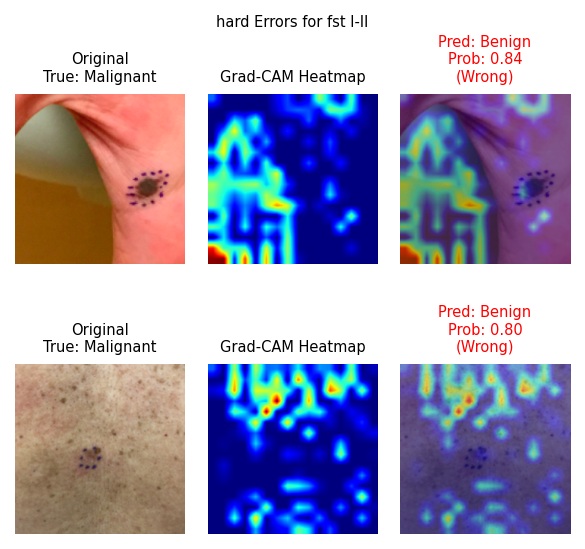

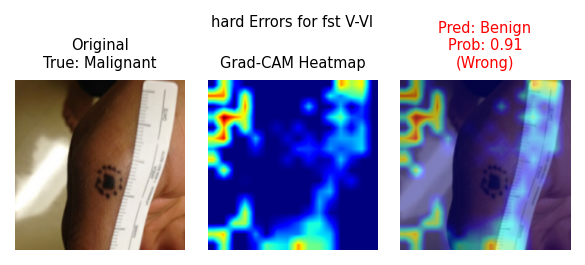

In [ ]:
#Visualize hdard erros for Malignat prediction
visualize_gradcam_from_df(
    model=dino_v2_base_l8_mix,
    df=hard_errors_I_II,
    image_root=ddi_image_base_dir,
    num_samples=2,
    title = "hard Errors for malignant predictions: fst I-II "
)

visualize_gradcam_from_df(
    model=dino_v2_base_l8_mix,
    df=hard_errors_I_IV,
    image_root=ddi_image_base_dir,
    num_samples=2,
    title = "hard Errors for malignant predictions: fst V-VI"
)


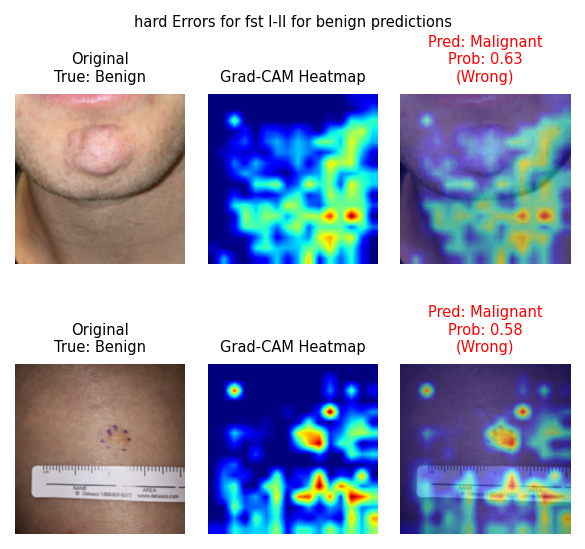

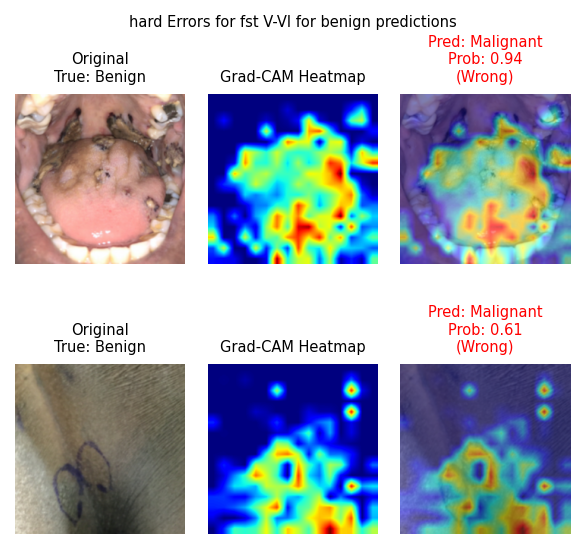

In [ ]:
visualize_gradcam_from_df(
    model=dino_v2_base_l8_mix,
    df=hard_errors_I_II_benign,
    image_root=ddi_image_base_dir,
    num_samples=2,
    title = "hard Errors for for benign predictions: fst I-II"
)

visualize_gradcam_from_df(
    model=dino_v2_base_l8_mix,
    df=hard_errors_I_IV_benign,
    image_root=ddi_image_base_dir,
    num_samples=2,
    title = "hard Errors for benign predictions: fst V-VI "
)

Visualisation of predictions with high confidence interval

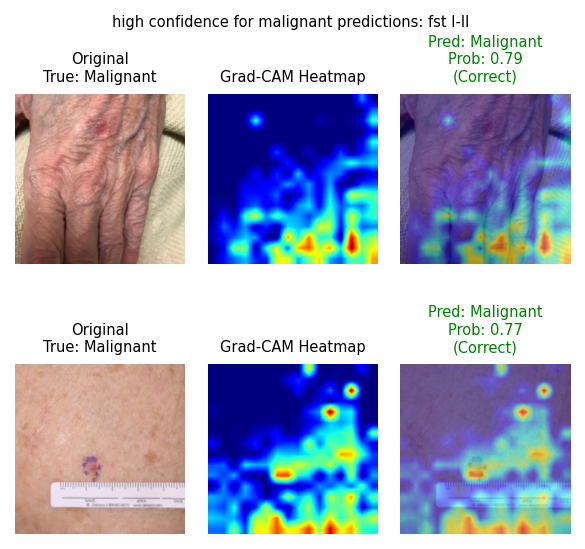

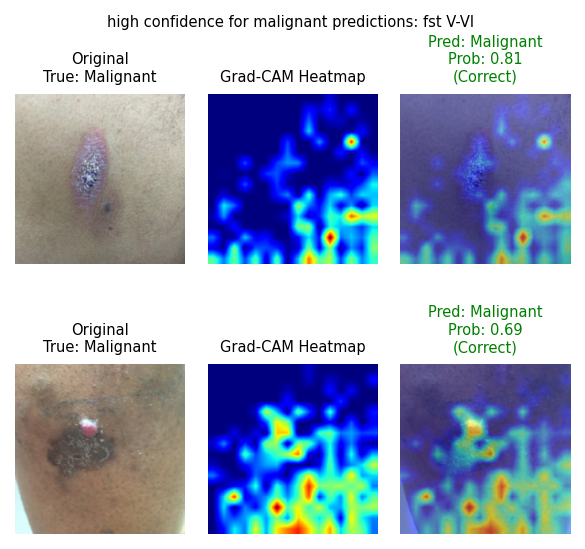

In [ ]:
#Visualize High confidence prediction for malignant

visualize_gradcam_from_df(
    model=dino_v2_base_l8_mix,
    df=high_conf_predictions_I_II,
    image_root=ddi_image_base_dir,
    num_samples=2,
    title = "high confidence for malignant predictions: fst I-II "
)

visualize_gradcam_from_df(
    model=dino_v2_base_l8_mix,
    df=high_conf_predictions_V_IV,
    image_root=ddi_image_base_dir,
    num_samples=2,
    title = "high confidence for malignant predictions: fst V-VI "
)



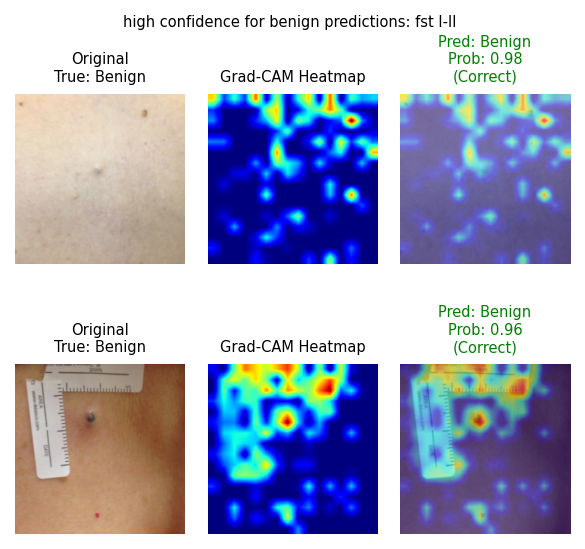

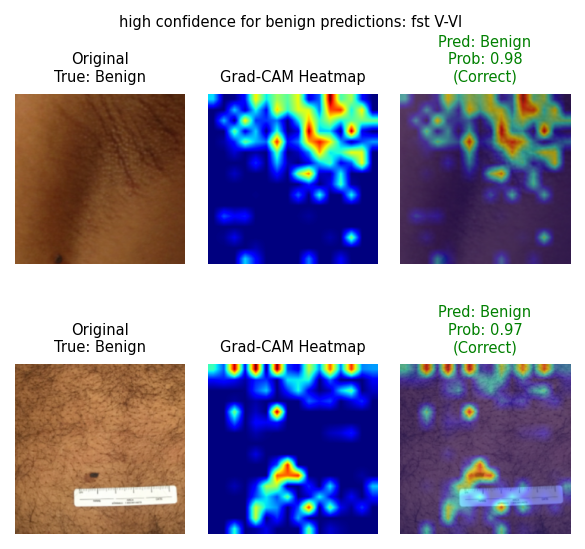

In [ ]:
#Visualize High confidence prediction for Benign

visualize_gradcam_from_df(
    model=dino_v2_base_l8_mix,
    df=high_conf_predictions_I_II_benign,
    image_root=ddi_image_base_dir,
    num_samples=2,
    title = "high confidence for benign predictions: fst I-II "
)

visualize_gradcam_from_df(
    model=dino_v2_base_l8_mix,
    df=high_conf_predictions_V_IV_benign,
    image_root=ddi_image_base_dir,
    num_samples=2,
    title = "high confidence for benign predictions: fst V-VI "
)

In [1062]:
high_conf_predictions_I_II

Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
6          409     410  000410.png         12       True   
56         407     408  000408.png         12       True   
32         405     406  000406.png         12       True   

                            disease fst_group skin_tone_malignant  y_true  \
6   squamous-cell-carcinoma-in-situ      I-II             12_True       1   
56  squamous-cell-carcinoma-in-situ      I-II             12_True       1   
32     basal-cell-carcinoma-nodular      I-II             12_True       1   

    y_pred  proba_score  is_correct  is_wrong pred_label true_label  
6        1     0.793464        True     False  Malignant  Malignant  
56       1     0.765721        True     False  Malignant  Malignant  
32       1     0.751002        True     False  Malignant  Malignant

##### Observations:

Grad-CAM visualisations reveal that the model is influenced by image artefacts such as background regions and measurement rulers, indicating that non-lesion features can contribute to the decision-making process. This suggests that further improvements in predictive performance may be achievable through the reduction or removal of such artefacts during data preprocessing or dataset curation. Nevertheless, for predictions made with high confidence, the model predominantly attends to lesion-specific regions, demonstrating that clinically relevant visual features are being captured despite the presence of confounding artefacts.

# CONCLUSION

In this work, we explored the use of Low-Rank Adaptation (LoRA) as a parameter-efficient fine-tuning strategy for Vision Transformer–based skin cancer detection, with a particular focus on mitigating performance disparities across Fitzpatrick skin tone groups. Using the DDI dataset, we demonstrated that pretrained DINOv2 models exhibit inherent skin tone–related biases, which can be revealed through linear probing and subgroup-level evaluation. 

By fine-tuning only a small fraction of model parameters, LoRA was shown to substantially reduce fairness gaps in both AUC and recall while maintaining strong overall performance and computational efficiency. Qualitative analysis using Grad-CAM further provided insight into model behaviour, highlighting both lesion-focused attention in high-confidence predictions and sensitivity to image artefacts. 

While the study is limited by dataset scope, image modality, and subgroup granularity, the results provide encouraging evidence that Low Rank Adapters can play a meaningful role in developing more equitable and scalable dermatological AI systems especially in the domain of Skin Cancer Detection, and point toward several promising directions for future investigation.